# Self-supervised scene classification
Note that a lot of this code has been based on the practical session of the course.

In [1]:
import torch
from torchvision import datasets, transforms, models
import torchvision
from torch.optim import Adam, SGD

from sklearn.metrics import accuracy_score, classification_report

import matplotlib.pyplot as plt

import os
import time

import pandas as pd
import numpy as np

from PIL import Image

from torch import nn, optim
from tqdm import tqdm

from sklearn.metrics import classification_report, confusion_matrix

import pickle
import itertools
import copy
import seaborn as sns

from hyperopt import hp, fmin, tpe, rand, STATUS_OK, Trials

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
## settings
INPUT_SHAPE = (224, 224, 3)
NUM_CLASSES = 15
BATCH_SIZE = 15
NUM_EPOCHS = 20
LEARNING_RATE = 0.00005
OPTIMIZER = "Adam"

## 2 15-Scene Dataset
The dataset contains 15 categories of different scenes [1]. The categories are office,
kitchen, living room, bedroom, store, industrial, tall building, inside cite, street, highway,
coast, open country, mountain, forest, and suburb. The dataset has been divided into
two parts train and test. Each part has equally 15 different classes of scenes. The train
set is used during the training process in order to ”teach” the model how to classify images. The validation set is used to evaluate the model after each epoch, it is not seen
by the model during training. You will find the dataset in the BlackBoard platform, located at UA 2500WETANN: Artificial Neural Material > Practical Session > datasets >
self-supervised scene classification Project.

In [4]:
def get_scene_data_loader(batch_size):
    """
    Returns a train and validation data loader for the 15 scene dataset.

    :param batch_size: the batch size to use

    :return: the train and validation data loader
    """

    # # Transformations to be applied on the images
    # transform = transforms.Compose([
    #     transforms.Resize(INPUT_SHAPE[:2]),
    #     transforms.ToTensor()
    # ])

    # Since we're working with efficientnet, use the same transformations
    transform = torchvision.models.EfficientNet_B0_Weights.IMAGENET1K_V1.transforms()

    # print the transformations
    # print(transform)

    # Load the dataset
    # data_folder = '15SceneData_small'
    data_folder = '15SceneData'
    # data_folder = '/content/drive/My Drive/ann/15SceneData_small'

    train_folder = os.path.join(data_folder, 'train')
    val_folder = os.path.join(data_folder, 'validation')

    train_dataset = datasets.ImageFolder(root=train_folder, transform=transform)
    val_dataset = datasets.ImageFolder(root=val_folder, transform=transform)

    # Create the data loaders
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

    # get the labels
    global LABELS
    LABELS = train_dataset.classes

    return train_loader, val_loader

In [5]:
train_loader, val_loader = get_scene_data_loader(BATCH_SIZE)

In [6]:
def visualize_3x3_images(images, labels, class_names=None):
    """
    Visualizes a 3x3 plot of images with their corresponding labels.

    :param images: the images to plot
    :param labels: the labels to plot
    """
    if class_names is None:
        class_names = LABELS

    fig, axes = plt.subplots(nrows=3, ncols=3)
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].permute(1, 2, 0))
        ax.set_title(f"{class_names[labels[i]]}")
        ax.axis('off')

    plt.show()

In [7]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

torch.cuda.empty_cache() if torch.cuda.is_available() else None

Using device: cuda:0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


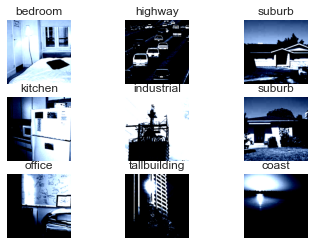

In [8]:
# Get a batch of images and labels
images, labels = next(iter(train_loader))
visualize_3x3_images(images, labels)

## 3 Classification schemes
In this section, the fully-supervised and self-supervised methods that should be implemented in this assignment are explained in more detail.

In [9]:
def get_n_fc_layers(model):
    """
    Returns the number of fully connected layers of a model.

    :param model: the model to get the number of fully connected layers from

    :return: the number of fully connected layers
    """
    n_fc_layers = 0
    for layer in model.children():
        if isinstance(layer, torch.nn.Linear):
            n_fc_layers += 1

    return n_fc_layers

In [ ]:
class TrainLogger:
    def __init__(self, train_config, train_loader, val_loader, model, descr="", verbose=True):
        self.train_config = train_config

        self.train_loss_list_per_epoch = []
        self.train_loss_list_per_itr = []
        self.train_loss_list_all_itr = []
        self.train_accuracy_per_epoch = []

        self.val_loss_list = []
        self.val_accuracy_per_epoch = []

        self.time_s = time.time()

        time_str = time.strftime("%Y%m%d_%H%M%S")
        self.identifier = descr + "_" + time_str

        self.output_folder = os.path.join("outputs", self.identifier)
        os.makedirs(self.output_folder, exist_ok=True)

        self.time_e = None

        self.train_size = len(train_loader.dataset)
        self.val_size = len(val_loader.dataset)

        self.batch_size = train_loader.batch_size

        self.fc_layers = get_n_fc_layers(model)

        self.verbose = verbose

    def notify_itr_end(self, itr, train_loss):
        if itr % 10 == 0:
            self.train_loss_list_per_itr.append(train_loss.item())

    def notify_epoch_end(self, epoch, model, eval_loss, eval_acc, train_loss=None, train_acc=None):

        if train_loss is None:
            train_loss = np.mean(self.train_loss_list_per_itr)
        self.train_loss_list_per_epoch.append(train_loss)
        self.train_loss_list_all_itr.extend(self.train_loss_list_per_itr)
        self.train_loss_list_per_itr = []

        self.train_accuracy_per_epoch.append(train_acc)

        self.val_loss_list.append(eval_loss)
        self.val_accuracy_per_epoch.append(eval_acc)

        # try:
        #     self.save_model(model, epoch)
        # except Exception as e:
        #     print(f"Ignoring exception occurred while saving model: {e}")

        self.save_log_info()

        if self.verbose:
            print(f'Epoch {epoch} finished. '
                  f'Train loss: {self.train_loss_list_per_epoch[-1]}, '
                  f'Val loss: {eval_loss}, '
                  f'Val accuracy: {eval_acc}')

    def getting_worse(self, early_stop_count):
        if len(self.val_loss_list) < early_stop_count+1:
            return False

        epoch_before = self.val_loss_list[-early_stop_count-1]

        past_epochs = self.val_loss_list[-early_stop_count:]
        best_recent = np.min(past_epochs)

        return epoch_before < best_recent

    def get_train_duration(self):
        """Returns the duration of the training in minutes"""
        return (self.time_e - self.time_s) / 60

    def notify_train_end(self, model):
        self.time_e = time.time()
        self.save_log_info()
        self.save_model(model)
        self.plot_all()

    def analysis(self):
        # print loss and accuracy for train and validation per epoch
        print("Epoch: \tTrain loss / \tValidation loss ; \tTrain accuracy / \tValidation accuracy")
        prev_train_loss = None
        prev_train_acc = None
        prev_val_loss = None
        prev_val_acc = None

        first_val_loss_increase = None
        for i in range(len(self.train_loss_list_per_epoch)):
            curr_train_loss = self.train_loss_list_per_epoch[i]
            curr_val_loss = self.val_loss_list[i]
            curr_train_acc = self.train_accuracy_per_epoch[i]
            curr_val_acc = self.val_accuracy_per_epoch[i]

            # add + or - to indicate if the loss or accuracy is better than the previous epoch
            train_loss_arrow = "+" if prev_train_loss is None or curr_train_loss < prev_train_loss else "-"
            train_acc_arrow = "+" if prev_train_acc is None or curr_train_acc > prev_train_acc else "-"
            val_loss_arrow = "+" if prev_val_loss is None or curr_val_loss < prev_val_loss else "-"
            val_acc_arrow = "+" if prev_val_acc is None or curr_val_acc > prev_val_acc else "-"

            if first_val_loss_increase is None and prev_val_loss is not None and curr_val_loss > prev_val_loss:
                first_val_loss_increase = i

            arrows = train_loss_arrow + val_loss_arrow + train_acc_arrow + val_acc_arrow

            print(f"{arrows} {i}: \t{curr_train_loss:.4f} / \t{curr_val_loss:.4f} ; \t{curr_train_acc:.4f} / \t{curr_val_acc:.4f}")

            prev_train_loss = curr_train_loss
            prev_train_acc = curr_train_acc
            prev_val_loss = curr_val_loss
            prev_val_acc = curr_val_acc

        print("\n")
        print(f"Training duration: {self.get_train_duration()} minutes")
        print(f"Best validation accuracy: {self.get_best_val_acc(epoch=True)}")
        print(f"Best validation loss: {self.get_best_loss(epoch=True)}")
        print(f"First validation loss increase: {first_val_loss_increase}")

        self.plot_all(save=False)

    def plot_all(self, save=True):
        plt.plot(np.arange(len(self.train_loss_list_per_epoch)), self.train_loss_list_per_epoch, color='blue',
                 label='Train')
        plt.plot(np.arange(len(self.val_loss_list)), self.val_loss_list, color='red', label='Validation')
        plt.legend()
        plt.title('Train and Validation Loss')
        plt.savefig(f'{self.output_folder}/train_val_loss.png')  if save else None

        plt.show()

        plt.cla()

        plt.plot(np.arange(len(self.val_accuracy_per_epoch)), self.val_accuracy_per_epoch, color='green',
                 label='Validation')
        plt.title('Validation Accuracy')
        plt.savefig(f'{self.output_folder}/validation_accuracy.png') if save else None

        plt.show()

        plt.cla()

    def get_info_table(self):
        table = ""

        table_values = {
            "Input image size": self.train_config.input_size,
            "Learning rate": self.train_config.lr,
            "Optimizer": self.train_config.optimizer,
            "Batch size": self.batch_size,
            "Number of epochs": self.train_config.num_epochs,
            "Number of fully-connected layers": self.fc_layers
        }

        for key, value in table_values.items():
            table += f"{key}\t{value}\n"

        return table

    def save_model(self, model, epoch=None):
        if epoch is not None:
            filename = f'{self.output_folder}/model_epoch_{epoch}.pt'
        else:
            filename = f'{self.output_folder}/model.pt'

        torch.save(model.state_dict(), filename)

    def save_log_info(self):
        filename = f'{self.output_folder}/log.pickle'

        with open(filename, 'wb') as f:
            pickle.dump(self, f)

        print(f"Saved log info to {filename}") if self.verbose else None

    def get_best_val_acc(self, epoch=False):
        # epoch or not indicates whether the epoch number should also be returned
        if epoch:
            return np.max(self.val_accuracy_per_epoch), np.argmax(self.val_accuracy_per_epoch)
        else:
            return np.max(self.val_accuracy_per_epoch)

    def get_best_train_acc(self, epoch=False):
        # epoch or not indicates whether the epoch number should also be returned
        if epoch:
            return np.max(self.train_accuracy_per_epoch), np.argmax(self.train_accuracy_per_epoch)
        else:
            return np.max(self.train_accuracy_per_epoch)

    def get_best_loss(self, epoch=False):
        # epoch or not indicates whether the epoch number should also be returned
        if epoch:
            return np.min(self.val_loss_list), np.argmin(self.val_loss_list)
        else:
            return np.min(self.val_loss_list)

def load_log_info(path):
    with open(path, 'rb') as f:
        log = pickle.load(f)
    return log

In [11]:
class TrainConfig:
    def __init__(self, lr=LEARNING_RATE, num_epochs=NUM_EPOCHS, criterion=None, optimizer=OPTIMIZER,
                 input_size=INPUT_SHAPE, batch_size=BATCH_SIZE):
        self.lr = lr
        self.num_epochs = num_epochs
        self.criterion = criterion if criterion else torch.nn.CrossEntropyLoss()
        self.optimizer = optimizer
        self.batch_size = batch_size # warning: be sure to use train_with_custom_batch_size

        if input_size != INPUT_SHAPE:
            print(
                f"Warning: different input size from config not supported (since this is the train config and not loader config)")

        self.input_size = input_size

    def get_optimizer(self, model):
        if self.optimizer == "Adam":
            return Adam(model.parameters(), lr=self.lr)
        elif self.optimizer == "SGD":
            return SGD(model.parameters(), lr=self.lr)
        else:
            raise NotImplementedError("Optimizer not implemented")

In [12]:
def evaluation(model, validation_loader, criterion, pretext_task=None):
    val_loss = []

    real_label = None
    pred_label = None
    for inputs, labels in validation_loader:

        if pretext_task is not None:
            inputs, labels = pretext_task(inputs, labels)

        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        val_loss.append(loss.item())

        _, preds = torch.max(outputs, 1)
        if real_label is None:
            real_label = labels.data
            pred_label = preds
        else:
            real_label = torch.cat((real_label, labels.data), dim=0)
            pred_label = torch.cat((pred_label, preds), dim=0)

        del inputs
        del labels

    real_label = real_label.detach().cpu().numpy()
    pred_label = pred_label.detach().cpu().numpy()

    eval_acc = accuracy_score(real_label, pred_label)
    # report = classification_report(real_label, pred_label)
    # eval_acc = float(report.split('accuracy')[1].split(' ')[27])

    return np.mean(val_loss), eval_acc

In [13]:
def train(model, train_loader, validation_loader, train_config, pretext_task=None, log_descr=None, verbose=True, early_stop_count=None):

    # print(f"pretext_task: {pretext_task}")

    model.to(DEVICE)

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = train_config.get_optimizer(model)

    log = TrainLogger(train_config=train_config,
                      train_loader=train_loader,
                      val_loader=validation_loader,
                      model=model,
                      descr=log_descr,
                      verbose=verbose)

    for epoch in range(train_config.num_epochs):
        for itr, (inputs, labels) \
                in tqdm(enumerate(train_loader),
                        total=len(train_loader),
                        disable=not verbose):

            if pretext_task is not None:
                # change the inputs and labels to the pretext task
                inputs, labels = pretext_task(inputs, labels)

            model.train(True)

            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            # clearing old gradients from the last step
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # computing the derivative of the loss w.r.t. the parameters
            loss.backward()
            # optimizer takes a step in updating parameters based on the gradients of the parameters.
            optimizer.step()

            log.notify_itr_end(itr, train_loss=loss)

        # Evaluate model for each update iteration
        model.eval()
        with torch.no_grad():
            eval_loss, eval_acc = evaluation(model, validation_loader, criterion, pretext_task)

        # calculate the train accuracy
        train_loss, train_acc = evaluation(model, train_loader, criterion, pretext_task)

        log.notify_epoch_end(epoch, model=model, eval_loss=eval_loss, eval_acc=eval_acc, train_loss=train_loss,
                             train_acc=train_acc)

        if early_stop_count is not None and log.getting_worse(early_stop_count):
            print("Early stopping") if verbose else None
            break

    log.notify_train_end(model)

    return model, log

In [14]:
# global train_loader, val_loader
# train_loader, val_loader = None, None

def train_on_custom_batch_size(model, train_config, pretext_task=None, log_descr=None, verbose=True, early_stop_count=None):

    batch_size = train_config.batch_size

    global train_loader, val_loader
    if train_loader is None or val_loader is None or batch_size != train_loader.batch_size:
        # print(f"Creating new data loaders with batch size {batch_size}")
        train_loader, val_loader = get_scene_data_loader(batch_size)
        # print(f"Created new data loaders with batch size {train_loader.batch_size}")

    model, log = train(model, train_loader, val_loader, train_config, pretext_task=pretext_task, log_descr=log_descr, verbose=verbose, early_stop_count=early_stop_count)

    return model, log

In [15]:
# load the model
def load_model(path, num_classes=NUM_CLASSES, evaluation_mode=True):
    model_efficient_b0 = torchvision.models.efficientnet_b0(weights='IMAGENET1K_V1')

    classifier_in = model_efficient_b0.classifier[-1].in_features
    model_efficient_b0.classifier[-1] = torch.nn.Linear(in_features=classifier_in, out_features=num_classes)

    model_efficient_b0.load_state_dict(torch.load(path))

    if evaluation_mode:
        model_efficient_b0.eval()

    return model_efficient_b0

In [16]:
def make_trainable(model, train_features: bool, train_classifier: bool):
    for params in model.features.parameters():
        params.requires_grad = train_features

    for params in model.classifier.parameters():
        params.requires_grad = train_classifier

In [17]:
def modify_classification_head(model, num_classes):
    classifier_in = model.classifier[-1].in_features
    model.classifier[-1] = torch.nn.Linear(in_features=classifier_in, out_features=num_classes)
    return model

## Hyperparameter tuning

In [18]:
def tune_parameters(parameter_generator, gen_len,  model, train_config, pretext_task=None, early_stop_count=2, descr=""):

    results = []
    current_best = -np.inf
    best_parameter_set = None

    print(f"Starting hyperparameter search with {gen_len} parameter sets at {time.strftime('%Y-%m-%d %H:%M:%S')}")

    for parameter_set in tqdm(parameter_generator, total=gen_len):
        try:
            lr, batch_size = parameter_set

            train_config.lr = lr
            train_config.batch_size = batch_size

            # copy the model, since we don't want to change the original
            model_old = copy.deepcopy(model)

            model, log = train_on_custom_batch_size(model, train_config, pretext_task=pretext_task,
                                                    log_descr=f"hypersearch_{descr}_{parameter_set}", verbose=False,
                                                    early_stop_count=early_stop_count)

            results.append((parameter_set, log))

            if log.get_best_val_acc() > current_best:
                current_best = log.get_best_val_acc()
                best_parameter_set = parameter_set

                print(f"New best parameter set: {best_parameter_set}, with val accuracy {current_best} and train accuracy {log.get_best_train_acc()}")

            model = model_old

        except Exception as e:
            print(f"Exception occurred while testing parameter set {parameter_set}: {e}")
            continue

    print(f"Best parameter set: {best_parameter_set}, with accuracy {current_best}")

    # save results to a pickle file
    time_str = time.strftime("%Y%m%d_%H%M%S")
    identifier = f"hypersearch_{descr}_{time_str}"
    filename = f"outputs/{identifier}.pickle"
    with open(filename, 'wb') as f:
        pickle.dump(results, f)

    return results, best_parameter_set

In [19]:
def grid_search_generator(lr_search_space, batch_size_search_space):

    combinations = list(itertools.product(lr_search_space, batch_size_search_space))

    for combination in combinations:
        yield combination


def grid_search(model, train_config, pretext_task=None,
        lr_search_space=None, batch_size_search_space=None, early_stop_count=2, descr=""):
    """
    Performs a grid search over the learning rate and batch size hyperparameters.
    *_search_space should be a list of values to try. if None, the values from train_config are used.

    Best to set num_epoch large enough, since early stopping is used.
    """
    if lr_search_space is None:
      lr_search_space = [train_config.lr]
    if batch_size_search_space is None:
      batch_size_search_space = [train_loader.batch_size]


    gen_len = len(lr_search_space) * len(batch_size_search_space)

    generator = grid_search_generator(lr_search_space, batch_size_search_space)

    results, best_parameter_set = tune_parameters(generator, gen_len, model, train_config, pretext_task=pretext_task, early_stop_count=early_stop_count, descr=descr)

In [20]:
def random_search_generator(lr_search_space, batch_size_search_space, n_combinations):
    for i in range(n_combinations):
        lr = np.random.choice(lr_search_space)
        batch_size = np.random.choice(batch_size_search_space)
        yield (lr, batch_size)

def random_search(model, train_config, pretext_task=None,
        lr_search_space=None, batch_size_search_space=None, n_combinations=10, early_stop_count=2, descr=""):
    # warning; search space are currently only lists, should be extended if you want to keep using this one

    if lr_search_space is None:
      lr_search_space = [train_config.lr]
    if batch_size_search_space is None:
      batch_size_search_space = [train_loader.batch_size]

    gen_len = n_combinations

    generator = random_search_generator(lr_search_space, batch_size_search_space, n_combinations)

    results, best_parameter_set = tune_parameters(generator, gen_len, model, train_config, pretext_task=pretext_task, early_stop_count=early_stop_count, descr=descr)

    return results, best_parameter_set

### Bayesian Optimization
https://kevinvecmanis.io/statistics/machine%20learning/python/smbo/2019/06/01/Bayesian-Optimization.html also explains visualization

In [21]:
torch.cuda.empty_cache()

In [22]:
global HYPEROPT_MODEL_PARAMS
HYPEROPT_MODEL_PARAMS = {
    "model": None,
    "pretext_task": None,
    'train_config': None,
    "best_loss": np.inf,
    "best_parameter_set": None,
    "all_results": [],
}

def objective(params):

    global HYPEROPT_MODEL_PARAMS
    model = HYPEROPT_MODEL_PARAMS["model"]
    pretext_task = HYPEROPT_MODEL_PARAMS["pretext_task"]
    train_config = HYPEROPT_MODEL_PARAMS["train_config"]
    best_loss = HYPEROPT_MODEL_PARAMS["best_loss"]

    lr = params['lr']
    batch_size = params['batch_size']

    train_config.lr = lr
    train_config.batch_size = int(batch_size)

    parameter_set = (lr, batch_size)

    # copy the model, since we don't want to change the original
    model = copy.deepcopy(model)

    model, log = train_on_custom_batch_size(model, train_config, pretext_task=pretext_task,
                                            log_descr=f"hypersearch_bayesian_{parameter_set}", verbose=False,
                                            early_stop_count=2)

    loss = log.get_best_loss()
    if loss < best_loss:
        HYPEROPT_MODEL_PARAMS["best_loss"] = loss
        HYPEROPT_MODEL_PARAMS["best_parameter_set"] = parameter_set

        print(f"New best parameter set: {parameter_set}, with loss {loss}, accuracy {log.get_best_val_acc()}")

    HYPEROPT_MODEL_PARAMS["all_results"].append((parameter_set, log))

    return {'loss': loss, 'status': STATUS_OK}

In [23]:
def train_hyperopt(model, train_config, pretext_task=None, descr=""):
    global HYPEROPT_MODEL_PARAMS
    HYPEROPT_MODEL_PARAMS["model"] = model
    HYPEROPT_MODEL_PARAMS["pretext_task"] = pretext_task
    HYPEROPT_MODEL_PARAMS["train_config"] = train_config
    HYPEROPT_MODEL_PARAMS["best_loss"] = np.inf
    HYPEROPT_MODEL_PARAMS["best_parameter_set"] = None
    HYPEROPT_MODEL_PARAMS["all_results"] = []

    space = {
      'lr': hp.loguniform('lr', np.log(0.000001), np.log(0.01)),
        'batch_size': hp.randint('batch_size', 8, 16+1)
      }

    start = time.time()
    print(f"Starting hyperparameter search at {time.strftime('%Y-%m-%d %H:%M:%S')}")
    trials = Trials()
    best = fmin(
      objective,
      space = space,
      algo = tpe.suggest,
      max_evals = 20,
      trials = trials
    )

    print(f"Best parameter set: {HYPEROPT_MODEL_PARAMS['best_parameter_set']}, with loss {HYPEROPT_MODEL_PARAMS['best_loss']}")

    print(f"Hyperopt took {time.time() - start} seconds")

    timestr = time.strftime("%Y%m%d_%H%M%S")
    filename = f"outputs/hyperopt_{descr}_{timestr}"
    pickle.dump(trials, open(f"{filename}_trials.pickle", "wb"))
    pickle.dump(HYPEROPT_MODEL_PARAMS["all_results"], open(f"{filename}_all.pickle", "wb"))
    # trials = pickle.load(open("trials.p", "rb")) # Pass this to Hyperopt during the next training run.

    return best, trials

In [24]:
# import Line2D
from matplotlib.lines import Line2D

def plot_paramsearch(results):

    # plot lr logarithmicly and loss using seaborn
    lrs = [param_set[0] for param_set, log in results]
    losses = [log.get_best_loss() for param_set, log in results]

    df = pd.DataFrame({"lr": lrs, "loss": losses})

    sns.scatterplot(data=df, x="lr", y="loss")
    plt.xscale("log")

    plt.show()


    # plot epoch and lrs with the loss as hue
    lrs = [param_set[0] for param_set, log in results]
    losses = [log.get_best_loss() for param_set, log in results]
    trial = range(len(losses))

    df = pd.DataFrame({"lr": lrs, "loss": losses, "trial": trial})

    # hue palette should be green for low loss and red for high loss
    palette = sns.color_palette("RdYlGn", len(df["loss"]))
    palette = palette[::-1] # reverse the palette
    sns.scatterplot(data=df, x="trial", y="lr", hue="loss", palette=palette)
    # since loss is a float, create a simple legend instead of per value
    legend_elements = [Line2D([0], [0], marker='o', color='w', label='loss',
                              markerfacecolor=palette[0], markersize=10),
                       Line2D([0], [0], marker='o', color='w', label='loss',
                              markerfacecolor=palette[-1], markersize=10)]
    plt.legend(handles=legend_elements, labels=["low loss", "high loss"])

    plt.yscale("log")


    plt.show()

checkpoint1

In [25]:
#

## 3.1 Supervised learning scheme
In this section, you should fine-tune a convolutional neural network architecture, pretrained on the ImageNet [2] dataset, on the 15 scene dataset. In this assignment you will
use a pre-trained EfficientNet-B0 architecture. Following the exercise session on Transfer
Learning, you should make all layers in feature extraction and classifier parts of the model
trainable. The bellow address provides you with the scheme of the architecture of the
EfficientNet-B0.
https://towardsdatascience.com/complete-architectural-details-of-all-efficientnet-models-5fd

In [26]:

model_efficient_b0 = torchvision.models.efficientnet_b0(weights='IMAGENET1K_V1')

make_trainable(model_efficient_b0, train_features=True, train_classifier=True)

# Number of classes is different, so change the last classification layer
modify_classification_head(model_efficient_b0, num_classes=NUM_CLASSES)

train_config = TrainConfig()

model_efficient_b0, train_log = train(model_efficient_b0, train_loader, val_loader, train_config,
                                      log_descr="supervised")

 34%|███▍      | 34/100 [00:07<00:15,  4.35it/s]


KeyboardInterrupt: 

In [47]:
log = load_log_info("outputs/supervised_20230815_131432/log.pickle")
log.__dict__

{'train_config': <__main__.TrainConfig at 0x15411d507f0>,
 'train_loss_list_per_epoch': [2.4382914781570433,
  1.6310137629508972,
  1.0452701270580291,
  0.6058094352483749,
  0.4736965179443359],
 'train_loss_list_per_itr': [],
 'train_loss_list_all_itr': [2.7217161655426025,
  2.628272533416748,
  2.4737870693206787,
  2.4755609035491943,
  2.5443220138549805,
  2.4686734676361084,
  2.406768321990967,
  2.2747182846069336,
  2.3324897289276123,
  2.0566062927246094,
  2.0880448818206787,
  2.1191513538360596,
  1.865885853767395,
  1.9637813568115234,
  1.5787184238433838,
  1.6249650716781616,
  1.4071656465530396,
  1.353121280670166,
  1.1650749444961548,
  1.1442288160324097,
  1.411100149154663,
  1.2891322374343872,
  0.930435299873352,
  1.4221676588058472,
  1.0019599199295044,
  0.9947680234909058,
  0.76671302318573,
  0.6601670980453491,
  0.9153639674186707,
  1.0608938932418823,
  0.8233617544174194,
  0.899783730506897,
  0.6796985268592834,
  0.542612612247467,
  1.0

### Hyperparameter tuning

In [23]:
model_efficient_b0 = torchvision.models.efficientnet_b0(weights='IMAGENET1K_V1')

make_trainable(model_efficient_b0, train_features=True, train_classifier=True)

# Number of classes is different, so change the last classification layer
modify_classification_head(model_efficient_b0, num_classes=NUM_CLASSES)

train_config = TrainConfig()

# grid search
lr_search_space = [0.00001, 0.00005, 0.0001, 0.001]

results, best_parameter_set = grid_search(model_efficient_b0, train_config,
                                          lr_search_space=lr_search_space)

Starting hyperparameter search with 4 parameter sets at 2023-08-21 22:50:59


  0%|          | 0/4 [00:09<?, ?it/s]


KeyboardInterrupt: 

In [20]:
results

[((1e-05, 15), <__main__.TrainLogger at 0x2396ac759d0>),
 ((5e-05, 15), <__main__.TrainLogger at 0x2396ac75c10>),
 ((0.0001, 15), <__main__.TrainLogger at 0x2396ac75a30>),
 ((0.001, 15), <__main__.TrainLogger at 0x2395f506850>)]

In [21]:
for param_set, log in results:
    print(f"Parameter set: {param_set}, with accuracy {log.get_best_val_acc()}")


Parameter set: (1e-05, 15), with accuracy 0.3280757097791798
Parameter set: (5e-05, 15), with accuracy 0.6876971608832808
Parameter set: (0.0001, 15), with accuracy 0.7539432176656151
Parameter set: (0.001, 15), with accuracy 0.7097791798107256


New best parameter set: (2.4580329188666907e-06, 16), with loss 1.9867718653245405, accuracy 0.7025125628140704
New best parameter set: (0.0008772258695981423, 12), with loss 0.4101988827757328, accuracy 0.8653266331658291
New best parameter set: (1.6743571446497773e-05, 12), with loss 0.22438496032572655, accuracy 0.9306532663316583
New best parameter set: (0.0001552289872947037, 12), with loss 0.2202281747200343, accuracy 0.9306532663316583
New best parameter set: (2.4048700592767286e-05, 16), with loss 0.20642680079143316, accuracy 0.932998324958124
100%|██████████| 20/20 [3:05:19<00:00, 555.95s/trial, best loss: 0.20642680079143316]  
Best parameter set: (2.4048700592767286e-05, 16), with loss 0.20642680079143316
Hyperopt took 11119.08417391777 seconds


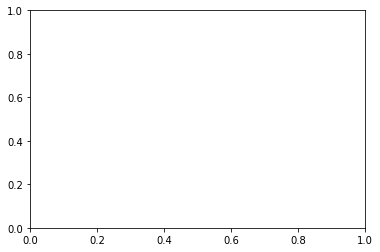

In [28]:
# hyperopt
model_efficient_b0 = torchvision.models.efficientnet_b0(weights='IMAGENET1K_V1')
make_trainable(model_efficient_b0, train_features=True, train_classifier=True)
modify_classification_head(model_efficient_b0, num_classes=NUM_CLASSES)

train_config = TrainConfig()

best, trials = train_hyperopt(model_efficient_b0, train_config, descr="supervised")

100%|██████████| 94/94 [00:19<00:00,  4.79it/s]


Saved log info to outputs\supervised-optimized_20230823_014852/log.pickle
Epoch 0 finished. Train loss: 2.390536917016861, Val loss: 2.4304652214050293, Val accuracy: 0.41105527638190953


100%|██████████| 94/94 [00:14<00:00,  6.36it/s]


Saved log info to outputs\supervised-optimized_20230823_014852/log.pickle
Epoch 1 finished. Train loss: 1.989301142540384, Val loss: 2.054415683695339, Val accuracy: 0.6700167504187605


100%|██████████| 94/94 [00:22<00:00,  4.13it/s]


Saved log info to outputs\supervised-optimized_20230823_014852/log.pickle
Epoch 2 finished. Train loss: 1.5217870410452499, Val loss: 1.611402594469448, Val accuracy: 0.7772194304857621


100%|██████████| 94/94 [00:22<00:00,  4.23it/s]


Saved log info to outputs\supervised-optimized_20230823_014852/log.pickle
Epoch 3 finished. Train loss: 1.0607408969960315, Val loss: 1.1735193369222834, Val accuracy: 0.8291457286432161


100%|██████████| 94/94 [00:24<00:00,  3.89it/s]


Saved log info to outputs\supervised-optimized_20230823_014852/log.pickle
Epoch 4 finished. Train loss: 0.7438963657998025, Val loss: 0.8700043597323371, Val accuracy: 0.8666666666666667


100%|██████████| 94/94 [00:21<00:00,  4.34it/s]


Saved log info to outputs\supervised-optimized_20230823_014852/log.pickle
Epoch 5 finished. Train loss: 0.4972896120966749, Val loss: 0.6463841284341353, Val accuracy: 0.8763819095477386


100%|██████████| 94/94 [00:19<00:00,  4.70it/s]


Saved log info to outputs\supervised-optimized_20230823_014852/log.pickle
Epoch 6 finished. Train loss: 0.34957794147603055, Val loss: 0.5081015485015145, Val accuracy: 0.8877721943048577


100%|██████████| 94/94 [00:16<00:00,  5.57it/s]


Saved log info to outputs\supervised-optimized_20230823_014852/log.pickle
Epoch 7 finished. Train loss: 0.24828258537231607, Val loss: 0.4250639522458143, Val accuracy: 0.9015075376884422


100%|██████████| 94/94 [00:20<00:00,  4.64it/s]


Saved log info to outputs\supervised-optimized_20230823_014852/log.pickle
Epoch 8 finished. Train loss: 0.17964387439349863, Val loss: 0.3645930451186583, Val accuracy: 0.9128978224455612


100%|██████████| 94/94 [00:17<00:00,  5.47it/s]


Saved log info to outputs\supervised-optimized_20230823_014852/log.pickle
Epoch 9 finished. Train loss: 0.13614692602385867, Val loss: 0.323837761015178, Val accuracy: 0.9112227805695142


100%|██████████| 94/94 [00:19<00:00,  4.83it/s]


Saved log info to outputs\supervised-optimized_20230823_014852/log.pickle
Epoch 10 finished. Train loss: 0.10295147321959759, Val loss: 0.3013069100956866, Val accuracy: 0.9149078726968174


100%|██████████| 94/94 [00:17<00:00,  5.28it/s]


Saved log info to outputs\supervised-optimized_20230823_014852/log.pickle
Epoch 11 finished. Train loss: 0.07394511367570847, Val loss: 0.26781017082260256, Val accuracy: 0.9266331658291457


100%|██████████| 94/94 [00:17<00:00,  5.47it/s]


Saved log info to outputs\supervised-optimized_20230823_014852/log.pickle
Epoch 12 finished. Train loss: 0.058499662522622876, Val loss: 0.2594614742911436, Val accuracy: 0.9219430485762145


100%|██████████| 94/94 [00:17<00:00,  5.48it/s]


Saved log info to outputs\supervised-optimized_20230823_014852/log.pickle
Epoch 13 finished. Train loss: 0.04592211271061542, Val loss: 0.23942751556953645, Val accuracy: 0.9269681742043551


100%|██████████| 94/94 [00:20<00:00,  4.48it/s]


Saved log info to outputs\supervised-optimized_20230823_014852/log.pickle
Epoch 14 finished. Train loss: 0.03809394418915853, Val loss: 0.24219760430209777, Val accuracy: 0.9262981574539364


100%|██████████| 94/94 [00:18<00:00,  5.01it/s]


Saved log info to outputs\supervised-optimized_20230823_014852/log.pickle
Epoch 15 finished. Train loss: 0.03331327889154249, Val loss: 0.23730675178893748, Val accuracy: 0.9276381909547738


100%|██████████| 94/94 [00:18<00:00,  4.95it/s]


Saved log info to outputs\supervised-optimized_20230823_014852/log.pickle
Epoch 16 finished. Train loss: 0.02682858671834494, Val loss: 0.23518276200654673, Val accuracy: 0.9293132328308208


100%|██████████| 94/94 [00:16<00:00,  5.70it/s]


Saved log info to outputs\supervised-optimized_20230823_014852/log.pickle
Epoch 17 finished. Train loss: 0.020392858249908115, Val loss: 0.2219026348688067, Val accuracy: 0.9323283082077052


100%|██████████| 94/94 [00:16<00:00,  5.55it/s]


Saved log info to outputs\supervised-optimized_20230823_014852/log.pickle
Epoch 18 finished. Train loss: 0.01842671339003805, Val loss: 0.2274961555426452, Val accuracy: 0.9293132328308208


100%|██████████| 94/94 [00:16<00:00,  5.62it/s]


Saved log info to outputs\supervised-optimized_20230823_014852/log.pickle
Epoch 19 finished. Train loss: 0.014201085350694174, Val loss: 0.21570056939826293, Val accuracy: 0.932998324958124


100%|██████████| 94/94 [00:19<00:00,  4.76it/s]


Saved log info to outputs\supervised-optimized_20230823_014852/log.pickle
Epoch 20 finished. Train loss: 0.012788103076015064, Val loss: 0.22366162788939667, Val accuracy: 0.931323283082077


100%|██████████| 94/94 [00:17<00:00,  5.50it/s]


Saved log info to outputs\supervised-optimized_20230823_014852/log.pickle
Epoch 21 finished. Train loss: 0.010206680286655877, Val loss: 0.22200930090172882, Val accuracy: 0.932998324958124


100%|██████████| 94/94 [00:17<00:00,  5.41it/s]


Saved log info to outputs\supervised-optimized_20230823_014852/log.pickle
Epoch 22 finished. Train loss: 0.008685936650974637, Val loss: 0.20657820810867664, Val accuracy: 0.9353433835845896


100%|██████████| 94/94 [00:16<00:00,  5.57it/s]


Saved log info to outputs\supervised-optimized_20230823_014852/log.pickle
Epoch 23 finished. Train loss: 0.007463077506783636, Val loss: 0.20918912356121735, Val accuracy: 0.9323283082077052


100%|██████████| 94/94 [00:16<00:00,  5.69it/s]


Saved log info to outputs\supervised-optimized_20230823_014852/log.pickle
Epoch 24 finished. Train loss: 0.0069532104262566945, Val loss: 0.21525617293455704, Val accuracy: 0.9326633165829146


100%|██████████| 94/94 [00:16<00:00,  5.59it/s]


Saved log info to outputs\supervised-optimized_20230823_014852/log.pickle
Epoch 25 finished. Train loss: 0.00576170187374141, Val loss: 0.21909929435939235, Val accuracy: 0.9340033500837521


100%|██████████| 94/94 [00:17<00:00,  5.51it/s]


Saved log info to outputs\supervised-optimized_20230823_014852/log.pickle
Epoch 26 finished. Train loss: 0.005248823359192527, Val loss: 0.2147216624804439, Val accuracy: 0.9323283082077052


100%|██████████| 94/94 [00:18<00:00,  5.20it/s]


Saved log info to outputs\supervised-optimized_20230823_014852/log.pickle
Epoch 27 finished. Train loss: 0.004971491426794215, Val loss: 0.22396287532712528, Val accuracy: 0.930318257956449


100%|██████████| 94/94 [00:16<00:00,  5.56it/s]


Saved log info to outputs\supervised-optimized_20230823_014852/log.pickle
Epoch 28 finished. Train loss: 0.0046163894003257155, Val loss: 0.21441000458450718, Val accuracy: 0.9340033500837521


100%|██████████| 94/94 [00:18<00:00,  5.20it/s]


Saved log info to outputs\supervised-optimized_20230823_014852/log.pickle
Epoch 29 finished. Train loss: 0.0036447397891451864, Val loss: 0.20575731231975444, Val accuracy: 0.935678391959799


100%|██████████| 94/94 [00:17<00:00,  5.46it/s]


Saved log info to outputs\supervised-optimized_20230823_014852/log.pickle
Epoch 30 finished. Train loss: 0.003602775641063109, Val loss: 0.2165089781186917, Val accuracy: 0.9340033500837521


100%|██████████| 94/94 [00:19<00:00,  4.91it/s]


Saved log info to outputs\supervised-optimized_20230823_014852/log.pickle
Epoch 31 finished. Train loss: 0.003272856637696795, Val loss: 0.20671192264274002, Val accuracy: 0.9373534338358459


100%|██████████| 94/94 [00:17<00:00,  5.37it/s]


Saved log info to outputs\supervised-optimized_20230823_014852/log.pickle
Epoch 32 finished. Train loss: 0.003530011568069854, Val loss: 0.22376456643818296, Val accuracy: 0.9323283082077052


100%|██████████| 94/94 [00:16<00:00,  5.62it/s]


Saved log info to outputs\supervised-optimized_20230823_014852/log.pickle
Epoch 33 finished. Train loss: 0.0033122411882009436, Val loss: 0.21319966101869542, Val accuracy: 0.9353433835845896


100%|██████████| 94/94 [00:17<00:00,  5.50it/s]


Saved log info to outputs\supervised-optimized_20230823_014852/log.pickle
Epoch 34 finished. Train loss: 0.00271955515106922, Val loss: 0.21988344817536878, Val accuracy: 0.9350083752093802


100%|██████████| 94/94 [00:17<00:00,  5.41it/s]


Saved log info to outputs\supervised-optimized_20230823_014852/log.pickle
Epoch 35 finished. Train loss: 0.002359218013031963, Val loss: 0.21339103747980998, Val accuracy: 0.9343383584589615


100%|██████████| 94/94 [00:17<00:00,  5.42it/s]


Saved log info to outputs\supervised-optimized_20230823_014852/log.pickle
Epoch 36 finished. Train loss: 0.0022904970076311616, Val loss: 0.2290183403504325, Val accuracy: 0.9279731993299832


100%|██████████| 94/94 [00:16<00:00,  5.57it/s]


Saved log info to outputs\supervised-optimized_20230823_014852/log.pickle
Epoch 37 finished. Train loss: 0.0019450397453607713, Val loss: 0.21086657581412616, Val accuracy: 0.9360134003350083


100%|██████████| 94/94 [00:18<00:00,  5.11it/s]


Saved log info to outputs\supervised-optimized_20230823_014852/log.pickle
Epoch 38 finished. Train loss: 0.001757166519305332, Val loss: 0.2051260981467219, Val accuracy: 0.9346733668341709


100%|██████████| 94/94 [00:16<00:00,  5.56it/s]


Saved log info to outputs\supervised-optimized_20230823_014852/log.pickle
Epoch 39 finished. Train loss: 0.0015492507905520974, Val loss: 0.2064640720743427, Val accuracy: 0.9376884422110553
Saved log info to outputs\supervised-optimized_20230823_014852/log.pickle


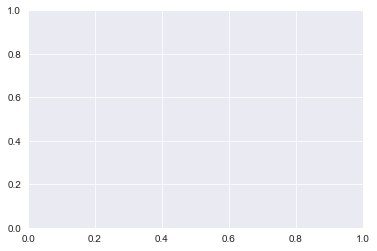

In [33]:

model_efficient_b0 = torchvision.models.efficientnet_b0(weights='IMAGENET1K_V1')

make_trainable(model_efficient_b0, train_features=True, train_classifier=True)

# Number of classes is different, so change the last classification layer
modify_classification_head(model_efficient_b0, num_classes=NUM_CLASSES)

train_config = TrainConfig(lr=0.000024048700592767286, batch_size=16, num_epochs=40)

model_efficient_b0, train_log = train_on_custom_batch_size(model_efficient_b0, train_config,
                                      log_descr="supervised-optimized")

New best parameter set: (2.4580329188666907e-06, 16), with loss 1.9867718653245405, accuracy 0.7025125628140704
New best parameter set: (0.0008772258695981423, 12), with loss 0.4101988827757328, accuracy 0.8653266331658291
New best parameter set: (1.6743571446497773e-05, 12), with loss 0.22438496032572655, accuracy 0.9306532663316583
New best parameter set: (0.0001552289872947037, 12), with loss 0.2202281747200343, accuracy 0.9306532663316583
New best parameter set: (2.4048700592767286e-05, 16), with loss 0.20642680079143316, accuracy 0.932998324958124
100%|██████████| 20/20 [3:05:19<00:00, 555.95s/trial, best loss: 0.20642680079143316]
Best parameter set: (2.4048700592767286e-05, 16), with loss 0.20642680079143316
Hyperopt took 11119.08417391777 seconds

In [45]:
trials

In [35]:
del HYPEROPT_MODEL_PARAMS, images

In [29]:
# load results pickle
results = pickle.load(open("outputs/hyperopt_supervised_20230822_041504_all.pickle", "rb"))

In [30]:
results

[((2.4580329188666907e-06, 16), <__main__.TrainLogger at 0x206cf3933d0>),
 ((0.0008772258695981423, 12), <__main__.TrainLogger at 0x2076533d4c0>),
 ((1.6743571446497773e-05, 12), <__main__.TrainLogger at 0x2076533d7f0>),
 ((0.001160922456065117, 16), <__main__.TrainLogger at 0x20735b0a760>),
 ((0.0003655718405089141, 16), <__main__.TrainLogger at 0x20735b0ab50>),
 ((0.00034373725439176676, 16), <__main__.TrainLogger at 0x20735705100>),
 ((4.048505781232711e-06, 16), <__main__.TrainLogger at 0x20735705670>),
 ((0.0001552289872947037, 12), <__main__.TrainLogger at 0x2073572c5e0>),
 ((0.0019249600795283952, 16), <__main__.TrainLogger at 0x2073572c9d0>),
 ((0.0005952439547744091, 16), <__main__.TrainLogger at 0x2073572cd00>),
 ((1.6816489408442303e-06, 12), <__main__.TrainLogger at 0x20735a68130>),
 ((0.0007112147212597514, 16), <__main__.TrainLogger at 0x20735a930a0>),
 ((2.4048700592767286e-05, 16), <__main__.TrainLogger at 0x20735a93490>),
 ((1.0426911469614426e-05, 12), <__main__.Train

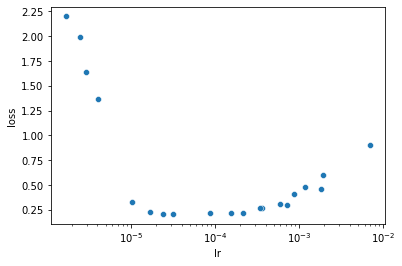

In [35]:
# for param_set, log in results:
#     lr, batch_size = param_set
#     print(f"Parameter set: {param_set}, with accuracy {log.get_best_val_acc()}")



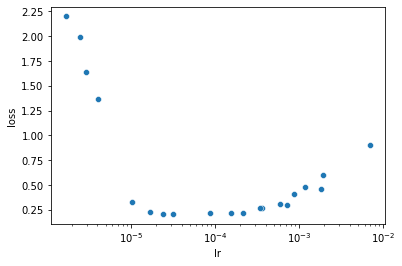

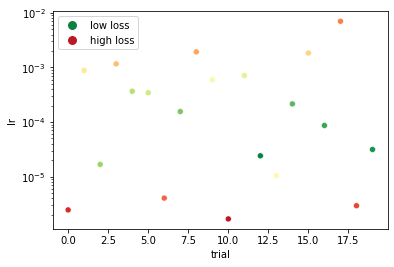

In [43]:
plot_paramsearch(results)

  5%|▌         | 1/20 [00:20<06:30, 20.57s/it]

New best parameter set: (1e-06, 4), with loss 2.7347042858600616, accuracy 0.0914826498422713


 10%|█         | 2/20 [01:25<14:01, 46.78s/it]

New best parameter set: (1e-06, 8), with loss 2.7311270236968994, accuracy 0.07255520504731862


 15%|█▌        | 3/20 [02:28<15:23, 54.31s/it]

New best parameter set: (1e-06, 12), with loss 2.7213521975058095, accuracy 0.07886435331230283


 20%|██        | 4/20 [03:56<17:58, 67.43s/it]

New best parameter set: (1e-06, 16), with loss 2.7048271536827087, accuracy 0.0946372239747634


 25%|██▌       | 5/20 [07:11<28:19, 113.32s/it]

New best parameter set: (1e-05, 4), with loss 2.3819166213274, accuracy 0.35331230283911674


 30%|███       | 6/20 [09:23<27:56, 119.78s/it]

New best parameter set: (1e-05, 8), with loss 2.0220639050006866, accuracy 0.5110410094637224


 35%|███▌      | 7/20 [11:15<25:24, 117.30s/it]

New best parameter set: (1e-05, 12), with loss 1.6955448786417644, accuracy 0.6088328075709779


 40%|████      | 8/20 [12:58<22:31, 112.64s/it]

New best parameter set: (1e-05, 16), with loss 1.4360454559326172, accuracy 0.6529968454258676


 45%|████▌     | 9/20 [14:32<19:36, 106.93s/it]

New best parameter set: (0.0001, 4), with loss 0.836557098897174, accuracy 0.7760252365930599


 50%|█████     | 10/20 [14:48<13:07, 78.73s/it]

New best parameter set: (0.0001, 8), with loss 0.7936302183195949, accuracy 0.7665615141955836


100%|██████████| 20/20 [20:27<00:00, 61.38s/it]


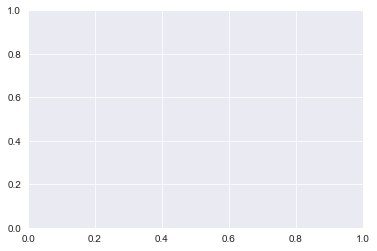

In [33]:
# grid search
lr_search_space = [0.000001, 0.00001, 0.0001, 0.001, 0.01]
batch_size_search_space = [4, 8, 12, 16]

model_efficient_b0 = torchvision.models.efficientnet_b0(weights='IMAGENET1K_V1')
make_trainable(model_efficient_b0, train_features=True, train_classifier=True)
modify_classification_head(model_efficient_b0, num_classes=NUM_CLASSES)

train_config = TrainConfig()

results =[]

combintations = list(itertools.product(lr_search_space, batch_size_search_space))

best_parameter_set = None
best_loss = np.inf

for lr, batch_size in tqdm(combintations, total=len(combintations)):
    # print(f"lr: {lr}, batch_size: {batch_size}")
    train_config.lr = lr
    train_config.batch_size = batch_size

    # copy the model, since we don't want to change the original
    model = copy.deepcopy(model_efficient_b0)

    _, log = train_on_custom_batch_size(model_efficient_b0, train_config, pretext_task=None,
                                            log_descr=f"gridsearch_supervised_{lr}_{batch_size}", verbose=False,
                                            early_stop_count=2)

    loss = log.get_best_loss()

    if loss < best_loss:
        best_loss = loss
        best_parameter_set = (lr, batch_size)

        print(f"New best parameter set: {best_parameter_set}, with loss {best_loss}, accuracy {log.get_best_val_acc()}")

    param_set = (lr, batch_size)
    results.append((param_set, log))

# results to pickle
time_str = time.strftime("%Y%m%d_%H%M%S")
identifier = f"gridsearch_supervised_{time_str}"
filename = f"outputs/{identifier}.pickle"

with open(filename, 'wb') as f:
    pickle.dump(results, f)

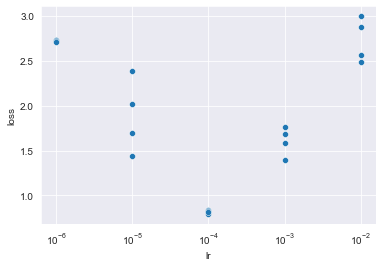

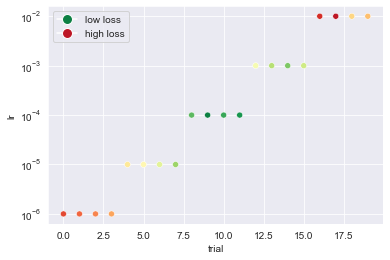

In [34]:
plot_paramsearch(results)

  5%|▌         | 1/20 [01:48<34:22, 108.57s/it]

New best parameter set: (5.659942493966815e-06, 10), with loss 2.5669223740696907, accuracy 0.28391167192429023


 15%|█▌        | 3/20 [02:55<14:11, 50.11s/it] 

New best parameter set: (0.0005387631897315977, 16), with loss 1.5203346014022827, accuracy 0.4889589905362776


 25%|██▌       | 5/20 [03:41<08:12, 32.83s/it]

New best parameter set: (0.00016179041599116765, 13), with loss 1.4409608697891236, accuracy 0.526813880126183


100%|██████████| 20/20 [10:53<00:00, 32.67s/it]


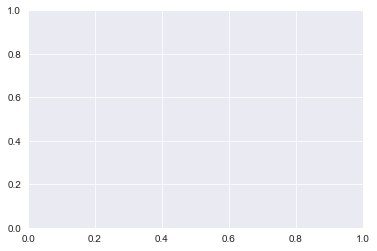

In [35]:
# random search
model_efficient_b0 = torchvision.models.efficientnet_b0(weights='IMAGENET1K_V1')
make_trainable(model_efficient_b0, train_features=True, train_classifier=True)
modify_classification_head(model_efficient_b0, num_classes=NUM_CLASSES)

train_config = TrainConfig()

results =[]

combintations = list(itertools.product(lr_search_space, batch_size_search_space))

best_parameter_set = None
best_loss = np.inf

sample_count = 20
for i in tqdm(range(sample_count), total=sample_count):
    # print(f"lr: {lr}, batch_size: {batch_size}")
    # draw lr log uniformly from 0.000001 to 0.01
    lr = np.exp(np.random.uniform(np.log(0.000001), np.log(0.01)))
    # batch size should be a random int between 4 and 16
    batch_size = np.random.randint(4, 16+1)

    train_config.lr = lr
    train_config.batch_size = batch_size

    # copy the model, since we don't want to change the original
    model = copy.deepcopy(model_efficient_b0)

    _, log = train_on_custom_batch_size(model_efficient_b0, train_config, pretext_task=None,
                                            log_descr=f"gridsearch_supervised_{lr}_{batch_size}", verbose=False,
                                            early_stop_count=2)

    loss = log.get_best_loss()

    if loss < best_loss:
        best_loss = loss
        best_parameter_set = (lr, batch_size)

        print(f"New best parameter set: {best_parameter_set}, with loss {best_loss}, accuracy {log.get_best_val_acc()}")

    param_set = (lr, batch_size)
    results.append((param_set, log))

# results to pickle
time_str = time.strftime("%Y%m%d_%H%M%S")
identifier = f"randomsearch_supervised_{time_str}"
filename = f"outputs/{identifier}.pickle"

with open(filename, 'wb') as f:
    pickle.dump(results, f)

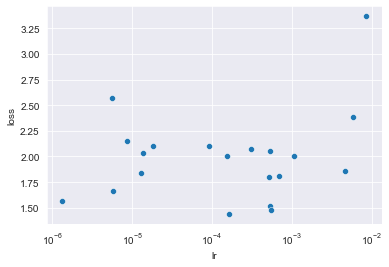

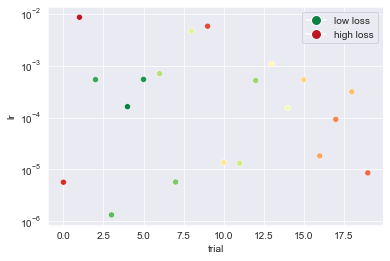

In [36]:
plot_paramsearch(results)

In [26]:
# hypeeeropt small dataset
# hyperopt
model_efficient_b0 = torchvision.models.efficientnet_b0(weights='IMAGENET1K_V1')
make_trainable(model_efficient_b0, train_features=True, train_classifier=True)
modify_classification_head(model_efficient_b0, num_classes=NUM_CLASSES)

train_config = TrainConfig()

best, trials = train_hyperopt(model_efficient_b0, train_config, descr="supervised")

  0%|          | 0/20 [00:12<?, ?trial/s, best loss=?]


KeyboardInterrupt: 

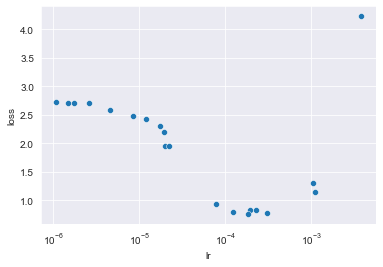

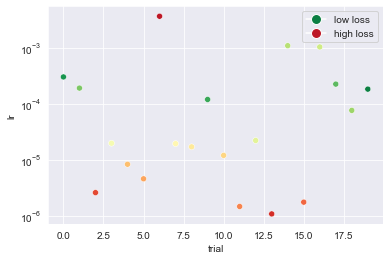

In [44]:
results = HYPEROPT_MODEL_PARAMS["all_results"]
plot_paramsearch(results)

Epoch: 	Train loss / 	Validation loss ; 	Train accuracy / 	Validation accuracy
++++ 0: 	2.3905 / 	2.4305 ; 	0.4820 / 	0.4111
++++ 1: 	1.9893 / 	2.0544 ; 	0.7827 / 	0.6700
++++ 2: 	1.5218 / 	1.6114 ; 	0.8613 / 	0.7772
++++ 3: 	1.0607 / 	1.1735 ; 	0.8987 / 	0.8291
++++ 4: 	0.7439 / 	0.8700 ; 	0.9260 / 	0.8667
++++ 5: 	0.4973 / 	0.6464 ; 	0.9413 / 	0.8764
++++ 6: 	0.3496 / 	0.5081 ; 	0.9607 / 	0.8878
++++ 7: 	0.2483 / 	0.4251 ; 	0.9707 / 	0.9015
++++ 8: 	0.1796 / 	0.3646 ; 	0.9773 / 	0.9129
+++- 9: 	0.1361 / 	0.3238 ; 	0.9807 / 	0.9112
++++ 10: 	0.1030 / 	0.3013 ; 	0.9887 / 	0.9149
++++ 11: 	0.0739 / 	0.2678 ; 	0.9953 / 	0.9266
+++- 12: 	0.0585 / 	0.2595 ; 	0.9960 / 	0.9219
++++ 13: 	0.0459 / 	0.2394 ; 	0.9973 / 	0.9270
+-+- 14: 	0.0381 / 	0.2422 ; 	0.9987 / 	0.9263
++-+ 15: 	0.0333 / 	0.2373 ; 	0.9987 / 	0.9276
++-+ 16: 	0.0268 / 	0.2352 ; 	0.9987 / 	0.9293
++++ 17: 	0.0204 / 	0.2219 ; 	0.9993 / 	0.9323
+--- 18: 	0.0184 / 	0.2275 ; 	0.9987 / 	0.9293
++++ 19: 	0.0142 / 	0.2157 ; 	0.9993 /

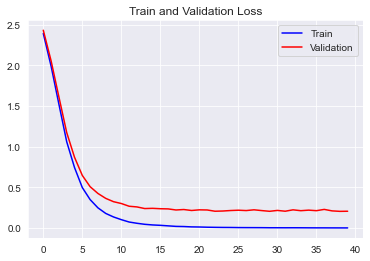

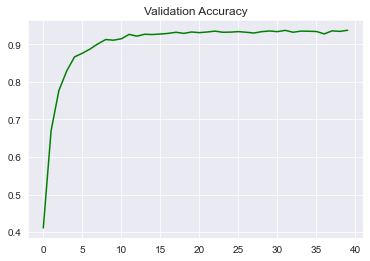

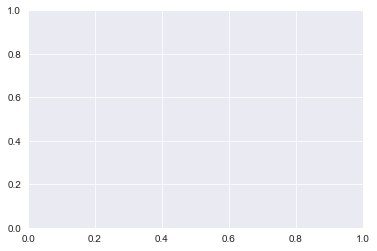

In [46]:
optimized_log = load_log_info("outputs/optimized runs/supervised-optimized_20230823_014852/log.pickle")
optimized_log.analysis()

In [ ]:
# cut off at epoch 31, (more ups and downs starting at 14, but still improving)

## 3.2 Self-supervised learning scheme

### 3.2.1 Pretext Task 1: Rotation Classification
checkpoint2

In [27]:
class RotationPretext:
    def __init__(self, angles=[0, 90, 180, 270]):
        self.angles = angles

    def __call__(self, inputs, labels):
        """"
        :param inputs: batch of images
        :param labels: batch of labels
        :return: rotated images and labels corresponding to the rotation angle
        """
        # return inputs, labels
        # print("Preteext in")
        for i in range(len(inputs)):
            angle_index = np.random.randint(len(self.angles))
            angle = self.angles[angle_index]
            inputs[i] = transforms.functional.rotate(inputs[i], angle)
            labels[i] = angle_index
        # print("Preteext out")
        return inputs, labels

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


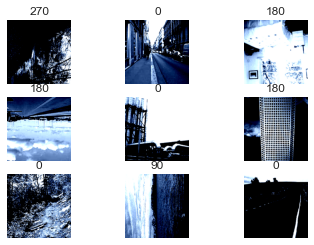

In [28]:
# test the rotation pretext task
images, labels = next(iter(train_loader))

angles = [0, 90, 180, 270]
rotation_pretext = RotationPretext([0, 90, 180, 270])
images, labels = rotation_pretext(images, labels)

visualize_3x3_images(images, labels, class_names=angles)

100%|██████████| 100/100 [01:03<00:00,  1.58it/s]


Saved log info to outputs\pretext_only_rotation_20230612_184738/log.txt
Epoch 0 finished. Train loss: 1.2767265081405639, Val loss: 1.1020681019404426, Val accuracy: 0.6301507537688442


100%|██████████| 100/100 [01:02<00:00,  1.59it/s]


Saved log info to outputs\pretext_only_rotation_20230612_184738/log.txt
Epoch 1 finished. Train loss: 0.9710584878921509, Val loss: 0.7214778622790198, Val accuracy: 0.7360134003350084


100%|██████████| 100/100 [01:02<00:00,  1.61it/s]


Saved log info to outputs\pretext_only_rotation_20230612_184738/log.txt
Epoch 2 finished. Train loss: 0.6806121051311493, Val loss: 0.5486773288429682, Val accuracy: 0.7819095477386935


100%|██████████| 100/100 [01:02<00:00,  1.61it/s]


Saved log info to outputs\pretext_only_rotation_20230612_184738/log.txt
Epoch 3 finished. Train loss: 0.515928253531456, Val loss: 0.4078117567839934, Val accuracy: 0.8609715242881072


100%|██████████| 100/100 [01:02<00:00,  1.61it/s]


Saved log info to outputs\pretext_only_rotation_20230612_184738/log.txt
Epoch 4 finished. Train loss: 0.4220299690961838, Val loss: 0.3040443463016994, Val accuracy: 0.8921273031825796


100%|██████████| 100/100 [01:02<00:00,  1.61it/s]


Saved log info to outputs\pretext_only_rotation_20230612_184738/log.txt
Epoch 5 finished. Train loss: 0.4014567732810974, Val loss: 0.24943770015209762, Val accuracy: 0.916247906197655


100%|██████████| 100/100 [01:02<00:00,  1.61it/s]


Saved log info to outputs\pretext_only_rotation_20230612_184738/log.txt
Epoch 6 finished. Train loss: 0.2922484800219536, Val loss: 0.23945645967395462, Val accuracy: 0.9082077051926298


100%|██████████| 100/100 [01:02<00:00,  1.61it/s]


Saved log info to outputs\pretext_only_rotation_20230612_184738/log.txt
Epoch 7 finished. Train loss: 0.2114729590713978, Val loss: 0.20405403462861052, Val accuracy: 0.9262981574539364


100%|██████████| 100/100 [01:02<00:00,  1.61it/s]


Saved log info to outputs\pretext_only_rotation_20230612_184738/log.txt
Epoch 8 finished. Train loss: 0.2766255922615528, Val loss: 0.18444941215329433, Val accuracy: 0.9336683417085427


100%|██████████| 100/100 [01:02<00:00,  1.61it/s]


Saved log info to outputs\pretext_only_rotation_20230612_184738/log.txt
Epoch 9 finished. Train loss: 0.1805283334106207, Val loss: 0.17941295226624038, Val accuracy: 0.9326633165829146


100%|██████████| 100/100 [01:02<00:00,  1.61it/s]


Saved log info to outputs\pretext_only_rotation_20230612_184738/log.txt
Epoch 10 finished. Train loss: 0.2030869111418724, Val loss: 0.1796729682509474, Val accuracy: 0.9333333333333333


100%|██████████| 100/100 [01:02<00:00,  1.61it/s]


Saved log info to outputs\pretext_only_rotation_20230612_184738/log.txt
Epoch 11 finished. Train loss: 0.19668276980519295, Val loss: 0.1797375951977868, Val accuracy: 0.9309882747068676


100%|██████████| 100/100 [01:02<00:00,  1.60it/s]


Saved log info to outputs\pretext_only_rotation_20230612_184738/log.txt
Epoch 12 finished. Train loss: 0.13910977691411971, Val loss: 0.17175760868019493, Val accuracy: 0.9390284757118929


100%|██████████| 100/100 [01:02<00:00,  1.61it/s]


Saved log info to outputs\pretext_only_rotation_20230612_184738/log.txt
Epoch 13 finished. Train loss: 0.13546560583636164, Val loss: 0.17056764042632064, Val accuracy: 0.9373534338358459


100%|██████████| 100/100 [01:02<00:00,  1.61it/s]


Saved log info to outputs\pretext_only_rotation_20230612_184738/log.txt
Epoch 14 finished. Train loss: 0.1411359048448503, Val loss: 0.16238697395828464, Val accuracy: 0.9390284757118929
Saved log info to outputs\pretext_only_rotation_20230612_184738/log.txt


100%|██████████| 100/100 [00:18<00:00,  5.29it/s]


Saved log info to outputs\pretext_rotation_20230612_191753/log.txt
Epoch 0 finished. Train loss: 2.6581330060958863, Val loss: 2.5480466260382877, Val accuracy: 0.21105527638190955


100%|██████████| 100/100 [00:18<00:00,  5.29it/s]


Saved log info to outputs\pretext_rotation_20230612_191753/log.txt
Epoch 1 finished. Train loss: 2.5082597732543945, Val loss: 2.378852463247788, Val accuracy: 0.35443886097152427


100%|██████████| 100/100 [00:18<00:00,  5.29it/s]


Saved log info to outputs\pretext_rotation_20230612_191753/log.txt
Epoch 2 finished. Train loss: 2.389182949066162, Val loss: 2.2434235805243103, Val accuracy: 0.44187604690117255


100%|██████████| 100/100 [00:18<00:00,  5.29it/s]


Saved log info to outputs\pretext_rotation_20230612_191753/log.txt
Epoch 3 finished. Train loss: 2.228971171379089, Val loss: 2.107219751755796, Val accuracy: 0.521608040201005


100%|██████████| 100/100 [00:18<00:00,  5.28it/s]


Saved log info to outputs\pretext_rotation_20230612_191753/log.txt
Epoch 4 finished. Train loss: 2.1947611570358276, Val loss: 1.9897879380077572, Val accuracy: 0.5735343383584589


100%|██████████| 100/100 [00:18<00:00,  5.28it/s]


Saved log info to outputs\pretext_rotation_20230612_191753/log.txt
Epoch 5 finished. Train loss: 2.0003522634506226, Val loss: 1.906836446805216, Val accuracy: 0.6040201005025125


100%|██████████| 100/100 [00:18<00:00,  5.29it/s]


Saved log info to outputs\pretext_rotation_20230612_191753/log.txt
Epoch 6 finished. Train loss: 2.014079678058624, Val loss: 1.8094266880696743, Val accuracy: 0.6187604690117253


100%|██████████| 100/100 [00:18<00:00,  5.28it/s]


Saved log info to outputs\pretext_rotation_20230612_191753/log.txt
Epoch 7 finished. Train loss: 1.938401222229004, Val loss: 1.7313602761407594, Val accuracy: 0.6391959798994975


100%|██████████| 100/100 [00:18<00:00,  5.29it/s]


Saved log info to outputs\pretext_rotation_20230612_191753/log.txt
Epoch 8 finished. Train loss: 1.760658848285675, Val loss: 1.6573268893975108, Val accuracy: 0.6559463986599665


100%|██████████| 100/100 [00:18<00:00,  5.29it/s]


Saved log info to outputs\pretext_rotation_20230612_191753/log.txt
Epoch 9 finished. Train loss: 1.6840951204299928, Val loss: 1.614261927916177, Val accuracy: 0.6636515912897822


100%|██████████| 100/100 [00:18<00:00,  5.29it/s]


Saved log info to outputs\pretext_rotation_20230612_191753/log.txt
Epoch 10 finished. Train loss: 1.8233296990394592, Val loss: 1.5263743813912474, Val accuracy: 0.6767169179229481


100%|██████████| 100/100 [00:18<00:00,  5.29it/s]


Saved log info to outputs\pretext_rotation_20230612_191753/log.txt
Epoch 11 finished. Train loss: 1.6617978096008301, Val loss: 1.4664054923321135, Val accuracy: 0.6958123953098827


100%|██████████| 100/100 [00:18<00:00,  5.28it/s]


Saved log info to outputs\pretext_rotation_20230612_191753/log.txt
Epoch 12 finished. Train loss: 1.5537155628204347, Val loss: 1.430328898693449, Val accuracy: 0.7015075376884422


100%|██████████| 100/100 [00:19<00:00,  5.26it/s]


Saved log info to outputs\pretext_rotation_20230612_191753/log.txt
Epoch 13 finished. Train loss: 1.4632452964782714, Val loss: 1.37281569883452, Val accuracy: 0.7051926298157454


100%|██████████| 100/100 [00:18<00:00,  5.27it/s]


Saved log info to outputs\pretext_rotation_20230612_191753/log.txt
Epoch 14 finished. Train loss: 1.5105182528495789, Val loss: 1.341849385194443, Val accuracy: 0.7139028475711893
Saved log info to outputs\pretext_rotation_20230612_191753/log.txt


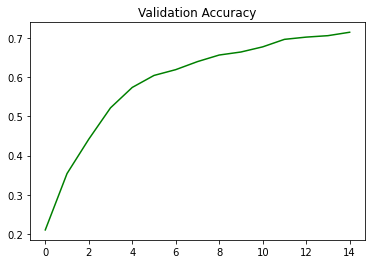

In [63]:
model_efficient_b0 = torchvision.models.efficientnet_b0(weights='IMAGENET1K_V1')

# Pretext Task
angles = [0, 90, 180, 270]
pretext_task = RotationPretext(angles=angles)
modify_classification_head(model_efficient_b0, num_classes=len(angles))

make_trainable(model_efficient_b0, train_features=True, train_classifier=True)

train_config = TrainConfig()

model_efficient_b0, pretext_log = train(model_efficient_b0, train_loader, val_loader, train_config,
                                        pretext_task=pretext_task, log_descr="pretext_only_rotation")

# Actual scene classification task
modify_classification_head(model_efficient_b0, num_classes=NUM_CLASSES)

# make all layers of classifier trainable
make_trainable(model_efficient_b0, train_features=False, train_classifier=True)

train_config = TrainConfig()

model_efficient_b0, train_log = train(model_efficient_b0, train_loader, val_loader, train_config,
                                      log_descr="pretext_rotation")

In [31]:
model_efficient_b0 = torchvision.models.efficientnet_b0(weights='IMAGENET1K_V1')

# Pretext Task
angles = [0, 90, 180, 270]
pretext_task = RotationPretext(angles=angles)
modify_classification_head(model_efficient_b0, num_classes=len(angles))

make_trainable(model_efficient_b0, train_features=True, train_classifier=True)

train_config = TrainConfig()

model_efficient_b0, pretext_log = train(model_efficient_b0, train_loader, val_loader, train_config,
                                        pretext_task=pretext_task, log_descr="pretext_only_rotation")

# Actual scene classification task
modify_classification_head(model_efficient_b0, num_classes=NUM_CLASSES)

# make all layers of classifier trainable
make_trainable(model_efficient_b0, train_features=False, train_classifier=True)

train_config = TrainConfig()

model_efficient_b0, train_log = train(model_efficient_b0, train_loader, val_loader, train_config,
                                      log_descr="pretext_rotation")

 66%|██████▌   | 90/137 [00:10<00:05,  8.36it/s]


KeyboardInterrupt: 

New best parameter set: (0.00010553745281562575, 14), with loss 0.21146667364627889, accuracy 0.9340033500837521
New best parameter set: (0.00016733942406652933, 12), with loss 0.2106836871954661, accuracy 0.9266331658291457
100%|██████████| 20/20 [5:01:37<00:00, 904.88s/trial, best loss: 0.2106836871954661]   
Best parameter set: (0.00016733942406652933, 12), with loss 0.2106836871954661
Hyperopt took 18097.598203897476 seconds


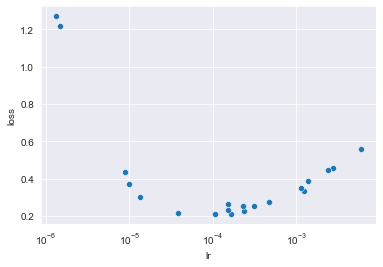

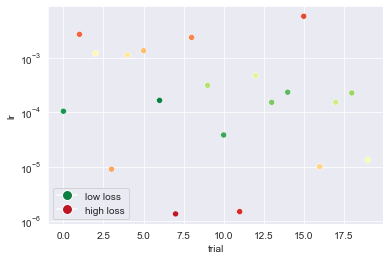

In [29]:
# Optimizing the pretext task
model_efficient_b0 = torchvision.models.efficientnet_b0(weights='IMAGENET1K_V1')

# Pretext Task
angles = [0, 90, 180, 270]
pretext_task = RotationPretext(angles=angles)
modify_classification_head(model_efficient_b0, num_classes=len(angles))

make_trainable(model_efficient_b0, train_features=True, train_classifier=True)

train_config = TrainConfig()

best, trials = train_hyperopt(model_efficient_b0, train_config, pretext_task=pretext_task, descr="rot-only")

results = HYPEROPT_MODEL_PARAMS["all_results"]
plot_paramsearch(results)

# 0.00016733942406652933; 12

100%|██████████| 94/94 [00:16<00:00,  5.60it/s]


Saved log info to outputs\supervised-optimized_20230823_022328/log.pickle
Epoch 0 finished. Train loss: 0.0011870053245690948, Val loss: 0.23170064470387078, Val accuracy: 0.932998324958124


100%|██████████| 94/94 [00:18<00:00,  4.98it/s]


Saved log info to outputs\supervised-optimized_20230823_022328/log.pickle
Epoch 1 finished. Train loss: 0.0010465460425698534, Val loss: 0.22122952917386543, Val accuracy: 0.9340033500837521


100%|██████████| 94/94 [00:18<00:00,  5.19it/s]


Saved log info to outputs\supervised-optimized_20230823_022328/log.pickle
Epoch 2 finished. Train loss: 0.0010460669622493987, Val loss: 0.24766262287627608, Val accuracy: 0.9293132328308208


100%|██████████| 94/94 [00:17<00:00,  5.50it/s]


Saved log info to outputs\supervised-optimized_20230823_022328/log.pickle
Epoch 3 finished. Train loss: 0.0010157765776037852, Val loss: 0.22340375804690954, Val accuracy: 0.932998324958124


100%|██████████| 94/94 [00:17<00:00,  5.40it/s]


Saved log info to outputs\supervised-optimized_20230823_022328/log.pickle
Epoch 4 finished. Train loss: 0.0007628169561862608, Val loss: 0.21173740115843434, Val accuracy: 0.9403685092127303


100%|██████████| 94/94 [00:17<00:00,  5.39it/s]


Saved log info to outputs\supervised-optimized_20230823_022328/log.pickle
Epoch 5 finished. Train loss: 0.0009699308550594612, Val loss: 0.22490784301133676, Val accuracy: 0.935678391959799


100%|██████████| 94/94 [00:17<00:00,  5.53it/s]


Saved log info to outputs\supervised-optimized_20230823_022328/log.pickle
Epoch 6 finished. Train loss: 0.0008596203002293515, Val loss: 0.2464469658113757, Val accuracy: 0.930318257956449


100%|██████████| 94/94 [00:17<00:00,  5.52it/s]


Saved log info to outputs\supervised-optimized_20230823_022328/log.pickle
Epoch 7 finished. Train loss: 0.0007262403632147594, Val loss: 0.22324027070329888, Val accuracy: 0.9383584589614741


100%|██████████| 94/94 [00:16<00:00,  5.72it/s]


Saved log info to outputs\supervised-optimized_20230823_022328/log.pickle
Epoch 8 finished. Train loss: 0.0006192677356785738, Val loss: 0.2249097160585374, Val accuracy: 0.935678391959799


100%|██████████| 94/94 [00:16<00:00,  5.70it/s]


Saved log info to outputs\supervised-optimized_20230823_022328/log.pickle
Epoch 9 finished. Train loss: 0.0007340242870107412, Val loss: 0.2496137206335577, Val accuracy: 0.9319932998324958


100%|██████████| 94/94 [00:16<00:00,  5.65it/s]


Saved log info to outputs\supervised-optimized_20230823_022328/log.pickle
Epoch 10 finished. Train loss: 0.0006011432026540167, Val loss: 0.23724417214283103, Val accuracy: 0.9336683417085427


100%|██████████| 94/94 [00:17<00:00,  5.43it/s]


Saved log info to outputs\supervised-optimized_20230823_022328/log.pickle
Epoch 11 finished. Train loss: 0.000552098065530485, Val loss: 0.2299760161926422, Val accuracy: 0.935678391959799


100%|██████████| 94/94 [00:17<00:00,  5.29it/s]


Saved log info to outputs\supervised-optimized_20230823_022328/log.pickle
Epoch 12 finished. Train loss: 0.0005641465909417442, Val loss: 0.23706054820225916, Val accuracy: 0.9350083752093802


100%|██████████| 94/94 [00:16<00:00,  5.58it/s]


Saved log info to outputs\supervised-optimized_20230823_022328/log.pickle
Epoch 13 finished. Train loss: 0.0005090986627731175, Val loss: 0.21578486321586118, Val accuracy: 0.9390284757118929


100%|██████████| 94/94 [00:17<00:00,  5.50it/s]


Saved log info to outputs\supervised-optimized_20230823_022328/log.pickle
Epoch 14 finished. Train loss: 0.000518650187509496, Val loss: 0.2268416774994569, Val accuracy: 0.9373534338358459


100%|██████████| 94/94 [00:19<00:00,  4.83it/s]


Saved log info to outputs\supervised-optimized_20230823_022328/log.pickle
Epoch 15 finished. Train loss: 0.0004223891291792128, Val loss: 0.2282315606966037, Val accuracy: 0.9373534338358459


100%|██████████| 94/94 [00:19<00:00,  4.93it/s]


Saved log info to outputs\supervised-optimized_20230823_022328/log.pickle
Epoch 16 finished. Train loss: 0.0004190102391727665, Val loss: 0.22627783974727247, Val accuracy: 0.935678391959799


100%|██████████| 94/94 [00:16<00:00,  5.68it/s]


Saved log info to outputs\supervised-optimized_20230823_022328/log.pickle
Epoch 17 finished. Train loss: 0.00036495717366515816, Val loss: 0.23235639972228775, Val accuracy: 0.9366834170854271


100%|██████████| 94/94 [00:16<00:00,  5.69it/s]


Saved log info to outputs\supervised-optimized_20230823_022328/log.pickle
Epoch 18 finished. Train loss: 0.00040327746048321987, Val loss: 0.23750288737315267, Val accuracy: 0.9373534338358459


100%|██████████| 94/94 [00:22<00:00,  4.19it/s]


Saved log info to outputs\supervised-optimized_20230823_022328/log.pickle
Epoch 19 finished. Train loss: 0.00035264184995693096, Val loss: 0.2608587757066729, Val accuracy: 0.9323283082077052


100%|██████████| 94/94 [00:20<00:00,  4.70it/s]


Saved log info to outputs\supervised-optimized_20230823_022328/log.pickle
Epoch 20 finished. Train loss: 0.00033849678476009163, Val loss: 0.23866382381009724, Val accuracy: 0.9373534338358459


100%|██████████| 94/94 [00:18<00:00,  5.07it/s]


Saved log info to outputs\supervised-optimized_20230823_022328/log.pickle
Epoch 21 finished. Train loss: 0.00048664231020511384, Val loss: 0.2852780351927006, Val accuracy: 0.9216080402010051


100%|██████████| 94/94 [00:18<00:00,  5.22it/s]


Saved log info to outputs\supervised-optimized_20230823_022328/log.pickle
Epoch 22 finished. Train loss: 0.0003602730793453644, Val loss: 0.24190658706559098, Val accuracy: 0.9353433835845896


100%|██████████| 94/94 [00:18<00:00,  4.97it/s]


Saved log info to outputs\supervised-optimized_20230823_022328/log.pickle
Epoch 23 finished. Train loss: 0.0003229097756241359, Val loss: 0.25317708548297857, Val accuracy: 0.9336683417085427


100%|██████████| 94/94 [00:18<00:00,  5.09it/s]


Saved log info to outputs\supervised-optimized_20230823_022328/log.pickle
Epoch 24 finished. Train loss: 0.0003263054927532373, Val loss: 0.2515613769142475, Val accuracy: 0.9323283082077052


100%|██████████| 94/94 [00:16<00:00,  5.54it/s]


Saved log info to outputs\supervised-optimized_20230823_022328/log.pickle
Epoch 25 finished. Train loss: 0.0003330232535285796, Val loss: 0.25002146950819565, Val accuracy: 0.9326633165829146


100%|██████████| 94/94 [00:17<00:00,  5.45it/s]


Saved log info to outputs\supervised-optimized_20230823_022328/log.pickle
Epoch 26 finished. Train loss: 0.0003163481514035239, Val loss: 0.2636378987656189, Val accuracy: 0.9276381909547738


100%|██████████| 94/94 [00:17<00:00,  5.32it/s]


Saved log info to outputs\supervised-optimized_20230823_022328/log.pickle
Epoch 27 finished. Train loss: 0.0002898416545228448, Val loss: 0.26357460962446594, Val accuracy: 0.9316582914572864


100%|██████████| 94/94 [00:17<00:00,  5.38it/s]


Saved log info to outputs\supervised-optimized_20230823_022328/log.pickle
Epoch 28 finished. Train loss: 0.0002787739146523118, Val loss: 0.23520062297562705, Val accuracy: 0.9353433835845896


100%|██████████| 94/94 [00:18<00:00,  5.05it/s]


Saved log info to outputs\supervised-optimized_20230823_022328/log.pickle
Epoch 29 finished. Train loss: 0.0002759079613903676, Val loss: 0.24082682731892555, Val accuracy: 0.9370184254606365


100%|██████████| 94/94 [00:16<00:00,  5.60it/s]


Saved log info to outputs\supervised-optimized_20230823_022328/log.pickle
Epoch 30 finished. Train loss: 0.0002243027445226115, Val loss: 0.2429020671025454, Val accuracy: 0.9340033500837521


100%|██████████| 94/94 [00:18<00:00,  5.21it/s]


Saved log info to outputs\supervised-optimized_20230823_022328/log.pickle
Epoch 31 finished. Train loss: 0.00022828925091047532, Val loss: 0.24862761249738363, Val accuracy: 0.9350083752093802


100%|██████████| 94/94 [00:17<00:00,  5.26it/s]


Saved log info to outputs\supervised-optimized_20230823_022328/log.pickle
Epoch 32 finished. Train loss: 0.0002058902990300223, Val loss: 0.24674299894707566, Val accuracy: 0.9370184254606365


100%|██████████| 94/94 [00:16<00:00,  5.67it/s]


Saved log info to outputs\supervised-optimized_20230823_022328/log.pickle
Epoch 33 finished. Train loss: 0.0002465119111373961, Val loss: 0.2516709782331335, Val accuracy: 0.9350083752093802


100%|██████████| 94/94 [00:17<00:00,  5.51it/s]


Saved log info to outputs\supervised-optimized_20230823_022328/log.pickle
Epoch 34 finished. Train loss: 0.0002428616985042104, Val loss: 0.2511425739260674, Val accuracy: 0.9346733668341709


100%|██████████| 94/94 [00:17<00:00,  5.30it/s]


Saved log info to outputs\supervised-optimized_20230823_022328/log.pickle
Epoch 35 finished. Train loss: 0.00020934006375256936, Val loss: 0.25158577273073135, Val accuracy: 0.9316582914572864


100%|██████████| 94/94 [00:17<00:00,  5.35it/s]


Saved log info to outputs\supervised-optimized_20230823_022328/log.pickle
Epoch 36 finished. Train loss: 0.00023310480688412506, Val loss: 0.26204844584634385, Val accuracy: 0.928643216080402


100%|██████████| 94/94 [00:17<00:00,  5.41it/s]


Saved log info to outputs\supervised-optimized_20230823_022328/log.pickle
Epoch 37 finished. Train loss: 0.00016824783639830012, Val loss: 0.25120786286518226, Val accuracy: 0.9346733668341709


100%|██████████| 94/94 [00:24<00:00,  3.81it/s]


Saved log info to outputs\supervised-optimized_20230823_022328/log.pickle
Epoch 38 finished. Train loss: 0.00020787188058169162, Val loss: 0.26537840069274116, Val accuracy: 0.9309882747068676


100%|██████████| 94/94 [00:20<00:00,  4.62it/s]


Saved log info to outputs\supervised-optimized_20230823_022328/log.pickle
Epoch 39 finished. Train loss: 0.00020420428034490312, Val loss: 0.2886491278351414, Val accuracy: 0.9266331658291457
Saved log info to outputs\supervised-optimized_20230823_022328/log.pickle


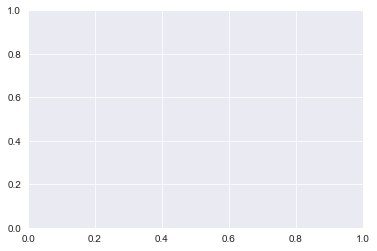

100%|██████████| 125/125 [00:31<00:00,  3.97it/s]


Saved log info to outputs\supervised-optimized_20230823_025620/log.pickle
Epoch 0 finished. Train loss: 0.37792593055963514, Val loss: 0.43398440617275047, Val accuracy: 0.8499162479061977


100%|██████████| 125/125 [00:20<00:00,  6.02it/s]


Saved log info to outputs\supervised-optimized_20230823_025620/log.pickle
Epoch 1 finished. Train loss: 0.23240811577439308, Val loss: 0.3219289163194866, Val accuracy: 0.8891122278056951


100%|██████████| 125/125 [00:20<00:00,  6.13it/s]


Saved log info to outputs\supervised-optimized_20230823_025620/log.pickle
Epoch 2 finished. Train loss: 0.15734833645820617, Val loss: 0.24703967613710398, Val accuracy: 0.9078726968174204


100%|██████████| 125/125 [00:20<00:00,  6.10it/s]


Saved log info to outputs\supervised-optimized_20230823_025620/log.pickle
Epoch 3 finished. Train loss: 0.11683763055875897, Val loss: 0.23974437651647082, Val accuracy: 0.9102177554438861


100%|██████████| 125/125 [00:20<00:00,  6.06it/s]


Saved log info to outputs\supervised-optimized_20230823_025620/log.pickle
Epoch 4 finished. Train loss: 0.12634537071362137, Val loss: 0.2440598070150219, Val accuracy: 0.9102177554438861


100%|██████████| 125/125 [00:20<00:00,  6.11it/s]


Saved log info to outputs\supervised-optimized_20230823_025620/log.pickle
Epoch 5 finished. Train loss: 0.07917179179750383, Val loss: 0.2207164497565418, Val accuracy: 0.9222780569514237


100%|██████████| 125/125 [00:22<00:00,  5.54it/s]


Saved log info to outputs\supervised-optimized_20230823_025620/log.pickle
Epoch 6 finished. Train loss: 0.07778919720742851, Val loss: 0.22430700038458748, Val accuracy: 0.9195979899497487


100%|██████████| 125/125 [00:20<00:00,  6.08it/s]


Saved log info to outputs\supervised-optimized_20230823_025620/log.pickle
Epoch 7 finished. Train loss: 0.07018399464711547, Val loss: 0.2145498261962789, Val accuracy: 0.9232830820770519


100%|██████████| 125/125 [00:20<00:00,  6.13it/s]


Saved log info to outputs\supervised-optimized_20230823_025620/log.pickle
Epoch 8 finished. Train loss: 0.05616950139869004, Val loss: 0.21030825740437073, Val accuracy: 0.9236180904522613


100%|██████████| 125/125 [00:20<00:00,  6.06it/s]


Saved log info to outputs\supervised-optimized_20230823_025620/log.pickle
Epoch 9 finished. Train loss: 0.046824867533519866, Val loss: 0.21074524552591264, Val accuracy: 0.9269681742043551


100%|██████████| 125/125 [00:20<00:00,  6.05it/s]


Saved log info to outputs\supervised-optimized_20230823_025620/log.pickle
Epoch 10 finished. Train loss: 0.0565711241257377, Val loss: 0.23793103785654268, Val accuracy: 0.9239530988274707


100%|██████████| 125/125 [00:20<00:00,  6.11it/s]


Saved log info to outputs\supervised-optimized_20230823_025620/log.pickle
Epoch 11 finished. Train loss: 0.025903170090634375, Val loss: 0.22178236867210466, Val accuracy: 0.9266331658291457


100%|██████████| 125/125 [00:20<00:00,  6.16it/s]


Saved log info to outputs\supervised-optimized_20230823_025620/log.pickle
Epoch 12 finished. Train loss: 0.04026893480215222, Val loss: 0.21731748514861077, Val accuracy: 0.9252931323283082


100%|██████████| 125/125 [00:20<00:00,  6.08it/s]


Saved log info to outputs\supervised-optimized_20230823_025620/log.pickle
Epoch 13 finished. Train loss: 0.021659206541720776, Val loss: 0.21081285630623964, Val accuracy: 0.9336683417085427


100%|██████████| 125/125 [00:20<00:00,  6.15it/s]


Saved log info to outputs\supervised-optimized_20230823_025620/log.pickle
Epoch 14 finished. Train loss: 0.01618922882108018, Val loss: 0.21123362313086413, Val accuracy: 0.9393634840871021


100%|██████████| 125/125 [00:20<00:00,  6.02it/s]


Saved log info to outputs\supervised-optimized_20230823_025620/log.pickle
Epoch 15 finished. Train loss: 0.017869972345186398, Val loss: 0.2235257737200621, Val accuracy: 0.9309882747068676


100%|██████████| 125/125 [00:20<00:00,  6.05it/s]


Saved log info to outputs\supervised-optimized_20230823_025620/log.pickle
Epoch 16 finished. Train loss: 0.027629765731748194, Val loss: 0.2614762262615607, Val accuracy: 0.9232830820770519


100%|██████████| 125/125 [00:20<00:00,  6.12it/s]


Saved log info to outputs\supervised-optimized_20230823_025620/log.pickle
Epoch 17 finished. Train loss: 0.01743504800531082, Val loss: 0.234856943134686, Val accuracy: 0.9269681742043551


100%|██████████| 125/125 [00:20<00:00,  6.17it/s]


Saved log info to outputs\supervised-optimized_20230823_025620/log.pickle
Epoch 18 finished. Train loss: 0.012173335787898395, Val loss: 0.21476169812832455, Val accuracy: 0.9373534338358459


100%|██████████| 125/125 [00:20<00:00,  6.13it/s]


Saved log info to outputs\supervised-optimized_20230823_025620/log.pickle
Epoch 19 finished. Train loss: 0.012030501711531543, Val loss: 0.2319183412287805, Val accuracy: 0.9333333333333333


100%|██████████| 125/125 [00:20<00:00,  6.10it/s]


Saved log info to outputs\supervised-optimized_20230823_025620/log.pickle
Epoch 20 finished. Train loss: 0.013841713740490378, Val loss: 0.24322770159349338, Val accuracy: 0.9262981574539364


100%|██████████| 125/125 [00:21<00:00,  5.95it/s]


Saved log info to outputs\supervised-optimized_20230823_025620/log.pickle
Epoch 21 finished. Train loss: 0.01145357918238733, Val loss: 0.2392883001818288, Val accuracy: 0.931323283082077


100%|██████████| 125/125 [00:21<00:00,  5.68it/s]


Saved log info to outputs\supervised-optimized_20230823_025620/log.pickle
Epoch 22 finished. Train loss: 0.01857362109218957, Val loss: 0.26834752322456296, Val accuracy: 0.9229480737018425


100%|██████████| 125/125 [00:21<00:00,  5.72it/s]


Saved log info to outputs\supervised-optimized_20230823_025620/log.pickle
Epoch 23 finished. Train loss: 0.014294787254882976, Val loss: 0.22242723004803638, Val accuracy: 0.9363484087102177


100%|██████████| 125/125 [00:22<00:00,  5.66it/s]


Saved log info to outputs\supervised-optimized_20230823_025620/log.pickle
Epoch 24 finished. Train loss: 0.024807829693891108, Val loss: 0.3037401141921885, Val accuracy: 0.9179229480737019


100%|██████████| 125/125 [00:21<00:00,  5.74it/s]


Saved log info to outputs\supervised-optimized_20230823_025620/log.pickle
Epoch 25 finished. Train loss: 0.020435724871233105, Val loss: 0.24623285873276912, Val accuracy: 0.9273031825795645


100%|██████████| 125/125 [00:22<00:00,  5.57it/s]


Saved log info to outputs\supervised-optimized_20230823_025620/log.pickle
Epoch 26 finished. Train loss: 0.017216953511175234, Val loss: 0.2811393809944754, Val accuracy: 0.9246231155778895


100%|██████████| 125/125 [00:21<00:00,  5.84it/s]


Saved log info to outputs\supervised-optimized_20230823_025620/log.pickle
Epoch 27 finished. Train loss: 0.007853066229668911, Val loss: 0.28247145644995014, Val accuracy: 0.9236180904522613


100%|██████████| 125/125 [00:21<00:00,  5.69it/s]


Saved log info to outputs\supervised-optimized_20230823_025620/log.pickle
Epoch 28 finished. Train loss: 0.01014953029161552, Val loss: 0.25591226876009115, Val accuracy: 0.9232830820770519


100%|██████████| 125/125 [00:21<00:00,  5.79it/s]


Saved log info to outputs\supervised-optimized_20230823_025620/log.pickle
Epoch 29 finished. Train loss: 0.01316053034493234, Val loss: 0.25806481028214706, Val accuracy: 0.9266331658291457


100%|██████████| 125/125 [00:21<00:00,  5.74it/s]


Saved log info to outputs\supervised-optimized_20230823_025620/log.pickle
Epoch 30 finished. Train loss: 0.019938847344601527, Val loss: 0.27893313412995446, Val accuracy: 0.9209380234505863


100%|██████████| 125/125 [00:21<00:00,  5.79it/s]


Saved log info to outputs\supervised-optimized_20230823_025620/log.pickle
Epoch 31 finished. Train loss: 0.012723782037850469, Val loss: 0.25471845408691185, Val accuracy: 0.9316582914572864


100%|██████████| 125/125 [00:23<00:00,  5.23it/s]


Saved log info to outputs\supervised-optimized_20230823_025620/log.pickle
Epoch 32 finished. Train loss: 0.0036780841642757877, Val loss: 0.24737459744362303, Val accuracy: 0.9343383584589615


100%|██████████| 125/125 [00:21<00:00,  5.78it/s]


Saved log info to outputs\supervised-optimized_20230823_025620/log.pickle
Epoch 33 finished. Train loss: 0.0051776474523940125, Val loss: 0.25451346044744233, Val accuracy: 0.935678391959799


100%|██████████| 125/125 [00:22<00:00,  5.50it/s]


Saved log info to outputs\supervised-optimized_20230823_025620/log.pickle
Epoch 34 finished. Train loss: 0.005522202303283848, Val loss: 0.262558427013471, Val accuracy: 0.9232830820770519


100%|██████████| 125/125 [00:21<00:00,  5.76it/s]


Saved log info to outputs\supervised-optimized_20230823_025620/log.pickle
Epoch 35 finished. Train loss: 0.00587967882634257, Val loss: 0.3137694295391372, Val accuracy: 0.9199329983249581


100%|██████████| 125/125 [00:21<00:00,  5.70it/s]


Saved log info to outputs\supervised-optimized_20230823_025620/log.pickle
Epoch 36 finished. Train loss: 0.0017830246027442627, Val loss: 0.26217859321408044, Val accuracy: 0.9319932998324958


100%|██████████| 125/125 [00:21<00:00,  5.79it/s]


Saved log info to outputs\supervised-optimized_20230823_025620/log.pickle
Epoch 37 finished. Train loss: 0.00814892150828382, Val loss: 0.27551741013139763, Val accuracy: 0.930318257956449


100%|██████████| 125/125 [00:22<00:00,  5.52it/s]


Saved log info to outputs\supervised-optimized_20230823_025620/log.pickle
Epoch 38 finished. Train loss: 0.0036309907889226453, Val loss: 0.2750814209959725, Val accuracy: 0.9269681742043551


100%|██████████| 125/125 [00:21<00:00,  5.74it/s]


Saved log info to outputs\supervised-optimized_20230823_025620/log.pickle
Epoch 39 finished. Train loss: 0.002317398319239146, Val loss: 0.2747877001383456, Val accuracy: 0.931323283082077
Saved log info to outputs\supervised-optimized_20230823_025620/log.pickle


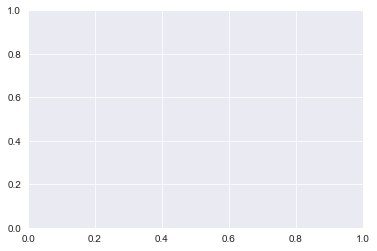

100%|██████████| 125/125 [00:31<00:00,  3.96it/s]


Saved log info to outputs\rot-only-optimized_20230823_041728/log.pickle
Epoch 0 finished. Train loss: 0.5274803943634033, Val loss: 0.5773265033242214, Val accuracy: 0.7738693467336684


100%|██████████| 125/125 [00:20<00:00,  6.01it/s]


Saved log info to outputs\rot-only-optimized_20230823_041728/log.pickle
Epoch 1 finished. Train loss: 0.26610669791698455, Val loss: 0.3484179312924305, Val accuracy: 0.8730318257956449


100%|██████████| 125/125 [00:20<00:00,  6.06it/s]


Saved log info to outputs\rot-only-optimized_20230823_041728/log.pickle
Epoch 2 finished. Train loss: 0.21393807104602455, Val loss: 0.29730059718152124, Val accuracy: 0.8954773869346734


100%|██████████| 125/125 [00:20<00:00,  6.08it/s]


Saved log info to outputs\rot-only-optimized_20230823_041728/log.pickle
Epoch 3 finished. Train loss: 0.15211214138194917, Val loss: 0.26325580215148897, Val accuracy: 0.9068676716917923


100%|██████████| 125/125 [00:20<00:00,  6.13it/s]


Saved log info to outputs\rot-only-optimized_20230823_041728/log.pickle
Epoch 4 finished. Train loss: 0.13822525515407325, Val loss: 0.255250222369445, Val accuracy: 0.9085427135678392


100%|██████████| 125/125 [00:20<00:00,  6.12it/s]


Saved log info to outputs\rot-only-optimized_20230823_041728/log.pickle
Epoch 5 finished. Train loss: 0.10891576278954744, Val loss: 0.24394728400441537, Val accuracy: 0.9122278056951424


100%|██████████| 125/125 [00:20<00:00,  6.02it/s]


Saved log info to outputs\rot-only-optimized_20230823_041728/log.pickle
Epoch 6 finished. Train loss: 0.07874965376965702, Val loss: 0.21883451631928544, Val accuracy: 0.9309882747068676


100%|██████████| 125/125 [00:20<00:00,  6.09it/s]


Saved log info to outputs\rot-only-optimized_20230823_041728/log.pickle
Epoch 7 finished. Train loss: 0.08891997645795345, Val loss: 0.2656312471079868, Val accuracy: 0.9078726968174204


100%|██████████| 125/125 [00:20<00:00,  6.08it/s]


Saved log info to outputs\rot-only-optimized_20230823_041728/log.pickle
Epoch 8 finished. Train loss: 0.0636242817780003, Val loss: 0.24003493622596184, Val accuracy: 0.9179229480737019


100%|██████████| 125/125 [00:20<00:00,  6.17it/s]


Saved log info to outputs\rot-only-optimized_20230823_041728/log.pickle
Epoch 9 finished. Train loss: 0.043106215606443586, Val loss: 0.2585227071596534, Val accuracy: 0.914572864321608


100%|██████████| 125/125 [00:20<00:00,  6.13it/s]


Saved log info to outputs\rot-only-optimized_20230823_041728/log.pickle
Epoch 10 finished. Train loss: 0.05127037580218166, Val loss: 0.21050544535081056, Val accuracy: 0.9276381909547738


100%|██████████| 125/125 [00:20<00:00,  6.10it/s]


Saved log info to outputs\rot-only-optimized_20230823_041728/log.pickle
Epoch 11 finished. Train loss: 0.0387373830541037, Val loss: 0.21051592420623919, Val accuracy: 0.9309882747068676


100%|██████████| 125/125 [00:20<00:00,  6.13it/s]


Saved log info to outputs\rot-only-optimized_20230823_041728/log.pickle
Epoch 12 finished. Train loss: 0.026164627297781407, Val loss: 0.2124126702958501, Val accuracy: 0.9279731993299832


100%|██████████| 125/125 [00:20<00:00,  6.08it/s]


Saved log info to outputs\rot-only-optimized_20230823_041728/log.pickle
Epoch 13 finished. Train loss: 0.027463429144350814, Val loss: 0.21571664823626868, Val accuracy: 0.9269681742043551


100%|██████████| 125/125 [00:20<00:00,  6.07it/s]


Saved log info to outputs\rot-only-optimized_20230823_041728/log.pickle
Epoch 14 finished. Train loss: 0.022342630320228637, Val loss: 0.22334998775363327, Val accuracy: 0.9276381909547738


100%|██████████| 125/125 [00:20<00:00,  6.07it/s]


Saved log info to outputs\rot-only-optimized_20230823_041728/log.pickle
Epoch 15 finished. Train loss: 0.03310121827898547, Val loss: 0.24738266927528618, Val accuracy: 0.9139028475711892


100%|██████████| 125/125 [00:20<00:00,  6.10it/s]


Saved log info to outputs\rot-only-optimized_20230823_041728/log.pickle
Epoch 16 finished. Train loss: 0.021037661448353902, Val loss: 0.226258782281617, Val accuracy: 0.925963149078727


100%|██████████| 125/125 [00:20<00:00,  6.03it/s]


Saved log info to outputs\rot-only-optimized_20230823_041728/log.pickle
Epoch 17 finished. Train loss: 0.011340285680256783, Val loss: 0.2139538205735433, Val accuracy: 0.9340033500837521


100%|██████████| 125/125 [00:22<00:00,  5.55it/s]


Saved log info to outputs\rot-only-optimized_20230823_041728/log.pickle
Epoch 18 finished. Train loss: 0.01312323121749796, Val loss: 0.22420584841399457, Val accuracy: 0.931323283082077


100%|██████████| 125/125 [00:20<00:00,  6.06it/s]


Saved log info to outputs\rot-only-optimized_20230823_041728/log.pickle
Epoch 19 finished. Train loss: 0.01391994755610358, Val loss: 0.25063385027152185, Val accuracy: 0.9273031825795645


100%|██████████| 125/125 [00:20<00:00,  6.08it/s]


Saved log info to outputs\rot-only-optimized_20230823_041728/log.pickle
Epoch 20 finished. Train loss: 0.006187912858556956, Val loss: 0.2437157126531158, Val accuracy: 0.9299832495812396


100%|██████████| 125/125 [00:21<00:00,  5.88it/s]


Saved log info to outputs\rot-only-optimized_20230823_041728/log.pickle
Epoch 21 finished. Train loss: 0.015458343119476923, Val loss: 0.2535908789130584, Val accuracy: 0.9256281407035176


100%|██████████| 125/125 [00:20<00:00,  6.13it/s]


Saved log info to outputs\rot-only-optimized_20230823_041728/log.pickle
Epoch 22 finished. Train loss: 0.00726265856961254, Val loss: 0.24226250920650907, Val accuracy: 0.930318257956449


100%|██████████| 125/125 [00:20<00:00,  6.10it/s]


Saved log info to outputs\rot-only-optimized_20230823_041728/log.pickle
Epoch 23 finished. Train loss: 0.013539799776743166, Val loss: 0.254809196511212, Val accuracy: 0.9306532663316583


100%|██████████| 125/125 [00:20<00:00,  6.04it/s]


Saved log info to outputs\rot-only-optimized_20230823_041728/log.pickle
Epoch 24 finished. Train loss: 0.007470773738459684, Val loss: 0.23058848756825528, Val accuracy: 0.9343383584589615


100%|██████████| 125/125 [00:20<00:00,  6.04it/s]


Saved log info to outputs\rot-only-optimized_20230823_041728/log.pickle
Epoch 25 finished. Train loss: 0.006903070130152628, Val loss: 0.2398976464950443, Val accuracy: 0.9336683417085427


100%|██████████| 125/125 [00:20<00:00,  6.10it/s]


Saved log info to outputs\rot-only-optimized_20230823_041728/log.pickle
Epoch 26 finished. Train loss: 0.0077356570819101765, Val loss: 0.2688079648809559, Val accuracy: 0.9289782244556114


100%|██████████| 125/125 [00:20<00:00,  6.04it/s]


Saved log info to outputs\rot-only-optimized_20230823_041728/log.pickle
Epoch 27 finished. Train loss: 0.0145027892330545, Val loss: 0.25032276079033167, Val accuracy: 0.9249581239530988


100%|██████████| 125/125 [00:20<00:00,  6.07it/s]


Saved log info to outputs\rot-only-optimized_20230823_041728/log.pickle
Epoch 28 finished. Train loss: 0.006170760674140183, Val loss: 0.24216387881545573, Val accuracy: 0.9366834170854271


100%|██████████| 125/125 [00:20<00:00,  6.03it/s]


Saved log info to outputs\rot-only-optimized_20230823_041728/log.pickle
Epoch 29 finished. Train loss: 0.00904047640657518, Val loss: 0.2738102966540315, Val accuracy: 0.928643216080402


100%|██████████| 125/125 [00:20<00:00,  6.13it/s]


Saved log info to outputs\rot-only-optimized_20230823_041728/log.pickle
Epoch 30 finished. Train loss: 0.010890701515367255, Val loss: 0.25885769019282545, Val accuracy: 0.9293132328308208


100%|██████████| 125/125 [00:20<00:00,  6.15it/s]


Saved log info to outputs\rot-only-optimized_20230823_041728/log.pickle
Epoch 31 finished. Train loss: 0.0049419953612377865, Val loss: 0.25068531591790244, Val accuracy: 0.9283082077051926


100%|██████████| 125/125 [00:20<00:00,  6.00it/s]


Saved log info to outputs\rot-only-optimized_20230823_041728/log.pickle
Epoch 32 finished. Train loss: 0.013007462526496965, Val loss: 0.28530620538884865, Val accuracy: 0.9195979899497487


100%|██████████| 125/125 [00:20<00:00,  6.01it/s]


Saved log info to outputs\rot-only-optimized_20230823_041728/log.pickle
Epoch 33 finished. Train loss: 0.010401804043212906, Val loss: 0.2887531527176983, Val accuracy: 0.9242881072026801


100%|██████████| 125/125 [00:20<00:00,  6.10it/s]


Saved log info to outputs\rot-only-optimized_20230823_041728/log.pickle
Epoch 34 finished. Train loss: 0.007509311530389823, Val loss: 0.28259975643572305, Val accuracy: 0.9229480737018425


100%|██████████| 125/125 [00:20<00:00,  6.12it/s]


Saved log info to outputs\rot-only-optimized_20230823_041728/log.pickle
Epoch 35 finished. Train loss: 0.004472196481365245, Val loss: 0.2551997024204183, Val accuracy: 0.9306532663316583


100%|██████████| 125/125 [00:20<00:00,  5.96it/s]


Saved log info to outputs\rot-only-optimized_20230823_041728/log.pickle
Epoch 36 finished. Train loss: 0.009951450815133284, Val loss: 0.29786886686966924, Val accuracy: 0.9269681742043551


100%|██████████| 125/125 [00:20<00:00,  6.02it/s]


Saved log info to outputs\rot-only-optimized_20230823_041728/log.pickle
Epoch 37 finished. Train loss: 0.003197150101463194, Val loss: 0.2574494446728432, Val accuracy: 0.9333333333333333


100%|██████████| 125/125 [00:20<00:00,  5.98it/s]


Saved log info to outputs\rot-only-optimized_20230823_041728/log.pickle
Epoch 38 finished. Train loss: 0.015654933211393655, Val loss: 0.3388563572103251, Val accuracy: 0.9212730318257957


100%|██████████| 125/125 [00:20<00:00,  6.08it/s]


Saved log info to outputs\rot-only-optimized_20230823_041728/log.pickle
Epoch 39 finished. Train loss: 0.00943194299429888, Val loss: 0.2933674415431582, Val accuracy: 0.9185929648241206
Saved log info to outputs\rot-only-optimized_20230823_041728/log.pickle


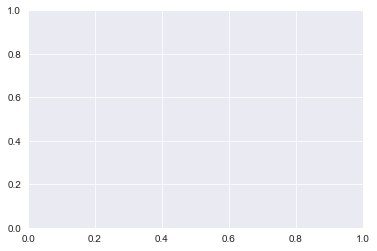

In [37]:
# Optimizing the pretext task
model_efficient_b0 = torchvision.models.efficientnet_b0(weights='IMAGENET1K_V1')

# Pretext Task
angles = [0, 90, 180, 270]
pretext_task = RotationPretext(angles=angles)
modify_classification_head(model_efficient_b0, num_classes=len(angles))

make_trainable(model_efficient_b0, train_features=True, train_classifier=True)

train_config = TrainConfig(lr=0.00016733942406652933, batch_size=12, num_epochs=40)

model_efficient_b0, train_log = train_on_custom_batch_size(model_efficient_b0, train_config,
                                      log_descr="rot-only-optimized", pretext_task=pretext_task)

Epoch: 	Train loss / 	Validation loss ; 	Train accuracy / 	Validation accuracy
++++ 0: 	0.5275 / 	0.5773 ; 	0.7973 / 	0.7739
++++ 1: 	0.2661 / 	0.3484 ; 	0.9120 / 	0.8730
++++ 2: 	0.2139 / 	0.2973 ; 	0.9227 / 	0.8955
++++ 3: 	0.1521 / 	0.2633 ; 	0.9480 / 	0.9069
++++ 4: 	0.1382 / 	0.2553 ; 	0.9560 / 	0.9085
++++ 5: 	0.1089 / 	0.2439 ; 	0.9607 / 	0.9122
++++ 6: 	0.0787 / 	0.2188 ; 	0.9747 / 	0.9310
---- 7: 	0.0889 / 	0.2656 ; 	0.9713 / 	0.9079
++++ 8: 	0.0636 / 	0.2400 ; 	0.9800 / 	0.9179
+-+- 9: 	0.0431 / 	0.2585 ; 	0.9880 / 	0.9146
-+-+ 10: 	0.0513 / 	0.2105 ; 	0.9880 / 	0.9276
+-++ 11: 	0.0387 / 	0.2105 ; 	0.9893 / 	0.9310
+-+- 12: 	0.0262 / 	0.2124 ; 	0.9960 / 	0.9280
---- 13: 	0.0275 / 	0.2157 ; 	0.9913 / 	0.9270
+-++ 14: 	0.0223 / 	0.2233 ; 	0.9940 / 	0.9276
---- 15: 	0.0331 / 	0.2474 ; 	0.9933 / 	0.9139
++++ 16: 	0.0210 / 	0.2263 ; 	0.9953 / 	0.9260
++++ 17: 	0.0113 / 	0.2140 ; 	0.9980 / 	0.9340
---- 18: 	0.0131 / 	0.2242 ; 	0.9980 / 	0.9313
---- 19: 	0.0139 / 	0.2506 ; 	0.9953 /

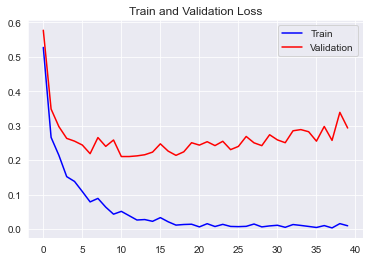

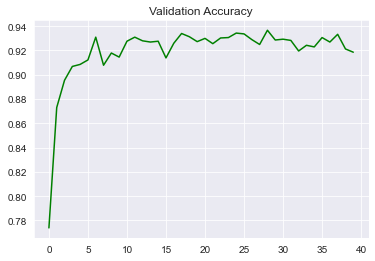

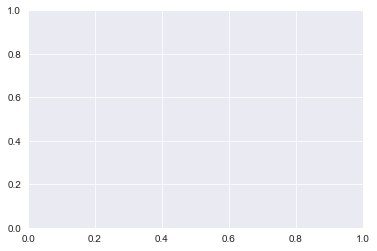

In [49]:
optimized_log = load_log_info("outputs/optimized runs/rot-only-optimized_20230823_041728/log.pickle")
optimized_log.analysis()

In [57]:
# take a look at other graphs during hyperopt param search, whether they behave similarly (even thoug worse, might give better graphs)
# load results pickle
with open("outputs/hyperopt/hyperopt_rot-only_20230822_212642_all.pickle", "rb") as f:
    results = pickle.load(f)
for i, (param_set, train_log) in enumerate(results):
    print(f"{i} {param_set}: \t{train_log.get_best_loss()}\t{train_log.get_best_val_acc()}")

0 (0.00010553745281562575, 14): 	0.21146667364627889	0.9340033500837521
1 (0.00277201069764393, 12): 	0.4572244599895425	0.8341708542713567
2 (0.0012419633842012637, 9): 	0.33287713145949394	0.8871021775544389
3 (8.983491656107759e-06, 15): 	0.43591801979433953	0.8673366834170855
4 (0.001157708222516068, 15): 	0.3486872866993124	0.8840871021775545
5 (0.001382881731318357, 8): 	0.3869087937845784	0.8586264656616416
6 (0.00016733942406652933, 12): 	0.2106836871954661	0.9266331658291457
7 (1.341869234277143e-06, 14): 	1.2698232381143302	0.49380234505862647
8 (0.0024266989370542056, 9): 	0.44464463207601423	0.8438860971524288
9 (0.00031733048928220313, 11): 	0.25398887529702147	0.9112227805695142
10 (3.842584774621311e-05, 14): 	0.21289186673587032	0.9242881072026801
11 (1.4793893075985286e-06, 10): 	1.2158927403166142	0.5601340033500838
12 (0.00047857668021349326, 10): 	0.27268351364980475	0.9072026800670017
13 (0.0001538229159315934, 15): 	0.22879814388389563	0.9232830820770519
14 (0.000

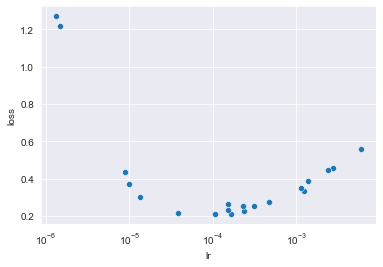

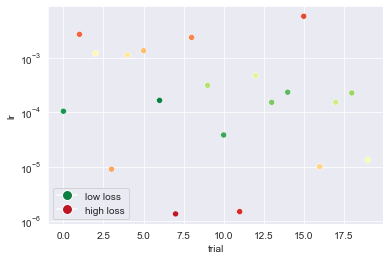

In [56]:
plot_paramsearch(results)

100%|██████████| 108/108 [00:16<00:00,  6.70it/s]


Saved log info to outputs\rot-only-optimized-2_20230823_125417/log.pickle
Epoch 0 finished. Train loss: 0.7026232378902258, Val loss: 0.7442363655177232, Val accuracy: 0.7262981574539363


100%|██████████| 108/108 [00:17<00:00,  6.22it/s]


Saved log info to outputs\rot-only-optimized-2_20230823_125417/log.pickle
Epoch 1 finished. Train loss: 0.33140718440214795, Val loss: 0.4184391053271628, Val accuracy: 0.8613065326633166


100%|██████████| 108/108 [00:29<00:00,  3.64it/s]


Saved log info to outputs\rot-only-optimized-2_20230823_125417/log.pickle
Epoch 2 finished. Train loss: 0.208733016969981, Val loss: 0.31601895809730635, Val accuracy: 0.8874371859296483


100%|██████████| 108/108 [00:21<00:00,  5.05it/s]


Saved log info to outputs\rot-only-optimized-2_20230823_125417/log.pickle
Epoch 3 finished. Train loss: 0.17397240639008857, Val loss: 0.2843720863233799, Val accuracy: 0.8994974874371859


100%|██████████| 108/108 [00:21<00:00,  5.13it/s]


Saved log info to outputs\rot-only-optimized-2_20230823_125417/log.pickle
Epoch 4 finished. Train loss: 0.12841876371142766, Val loss: 0.2646673197083384, Val accuracy: 0.9035175879396985


100%|██████████| 108/108 [00:20<00:00,  5.17it/s]


Saved log info to outputs\rot-only-optimized-2_20230823_125417/log.pickle
Epoch 5 finished. Train loss: 0.1219592002367049, Val loss: 0.28394336648781515, Val accuracy: 0.8981574539363484


100%|██████████| 108/108 [00:21<00:00,  5.12it/s]


Saved log info to outputs\rot-only-optimized-2_20230823_125417/log.pickle
Epoch 6 finished. Train loss: 0.07498308687246646, Val loss: 0.23359006003881413, Val accuracy: 0.9172529313232831


100%|██████████| 108/108 [00:22<00:00,  4.91it/s]


Saved log info to outputs\rot-only-optimized-2_20230823_125417/log.pickle
Epoch 7 finished. Train loss: 0.06127950438099948, Val loss: 0.22850411775561102, Val accuracy: 0.9172529313232831


100%|██████████| 108/108 [00:20<00:00,  5.21it/s]


Saved log info to outputs\rot-only-optimized-2_20230823_125417/log.pickle
Epoch 8 finished. Train loss: 0.05879113363011533, Val loss: 0.24609905921323139, Val accuracy: 0.9279731993299832


100%|██████████| 108/108 [00:23<00:00,  4.60it/s]


Saved log info to outputs\rot-only-optimized-2_20230823_125417/log.pickle
Epoch 9 finished. Train loss: 0.056503269987405035, Val loss: 0.22116516863875021, Val accuracy: 0.9226130653266331


100%|██████████| 108/108 [00:21<00:00,  5.07it/s]


Saved log info to outputs\rot-only-optimized-2_20230823_125417/log.pickle
Epoch 10 finished. Train loss: 0.04634362303746726, Val loss: 0.22480322815538775, Val accuracy: 0.9202680067001675


100%|██████████| 108/108 [00:20<00:00,  5.25it/s]


Saved log info to outputs\rot-only-optimized-2_20230823_125417/log.pickle
Epoch 11 finished. Train loss: 0.03758574110839551, Val loss: 0.22576196123650036, Val accuracy: 0.9266331658291457


100%|██████████| 108/108 [00:21<00:00,  5.02it/s]


Saved log info to outputs\rot-only-optimized-2_20230823_125417/log.pickle
Epoch 12 finished. Train loss: 0.042664059539135823, Val loss: 0.2555649403028982, Val accuracy: 0.9199329983249581


100%|██████████| 108/108 [00:21<00:00,  5.09it/s]


Saved log info to outputs\rot-only-optimized-2_20230823_125417/log.pickle
Epoch 13 finished. Train loss: 0.027468179304614076, Val loss: 0.23531326656360355, Val accuracy: 0.9269681742043551


100%|██████████| 108/108 [00:20<00:00,  5.35it/s]


Saved log info to outputs\rot-only-optimized-2_20230823_125417/log.pickle
Epoch 14 finished. Train loss: 0.022399850399341194, Val loss: 0.21488977931048198, Val accuracy: 0.9256281407035176


100%|██████████| 108/108 [00:19<00:00,  5.47it/s]


Saved log info to outputs\rot-only-optimized-2_20230823_125417/log.pickle
Epoch 15 finished. Train loss: 0.01922359443981097, Val loss: 0.22716556273772878, Val accuracy: 0.9252931323283082


100%|██████████| 108/108 [00:19<00:00,  5.63it/s]


Saved log info to outputs\rot-only-optimized-2_20230823_125417/log.pickle
Epoch 16 finished. Train loss: 0.019631332785744842, Val loss: 0.22237757337714814, Val accuracy: 0.9289782244556114


100%|██████████| 108/108 [00:19<00:00,  5.61it/s]


Saved log info to outputs\rot-only-optimized-2_20230823_125417/log.pickle
Epoch 17 finished. Train loss: 0.01828563788634104, Val loss: 0.2320598101017074, Val accuracy: 0.925963149078727


100%|██████████| 108/108 [00:22<00:00,  4.86it/s]


Saved log info to outputs\rot-only-optimized-2_20230823_125417/log.pickle
Epoch 18 finished. Train loss: 0.01538723712130579, Val loss: 0.22017837022692313, Val accuracy: 0.9283082077051926


100%|██████████| 108/108 [00:21<00:00,  4.96it/s]


Saved log info to outputs\rot-only-optimized-2_20230823_125417/log.pickle
Epoch 19 finished. Train loss: 0.012975778151249633, Val loss: 0.25180816564439124, Val accuracy: 0.9222780569514237


100%|██████████| 108/108 [00:20<00:00,  5.28it/s]


Saved log info to outputs\rot-only-optimized-2_20230823_125417/log.pickle
Epoch 20 finished. Train loss: 0.011491585811233596, Val loss: 0.23812082249814837, Val accuracy: 0.932998324958124


100%|██████████| 108/108 [00:20<00:00,  5.18it/s]


Saved log info to outputs\rot-only-optimized-2_20230823_125417/log.pickle
Epoch 21 finished. Train loss: 0.008914862358964186, Val loss: 0.2479482525578813, Val accuracy: 0.9256281407035176


100%|██████████| 108/108 [00:20<00:00,  5.26it/s]


Saved log info to outputs\rot-only-optimized-2_20230823_125417/log.pickle
Epoch 22 finished. Train loss: 0.00892580823333615, Val loss: 0.25294154479492575, Val accuracy: 0.9229480737018425


100%|██████████| 108/108 [00:20<00:00,  5.29it/s]


Saved log info to outputs\rot-only-optimized-2_20230823_125417/log.pickle
Epoch 23 finished. Train loss: 0.008428823131436258, Val loss: 0.24734822601932926, Val accuracy: 0.9262981574539364


100%|██████████| 108/108 [00:20<00:00,  5.26it/s]


Saved log info to outputs\rot-only-optimized-2_20230823_125417/log.pickle
Epoch 24 finished. Train loss: 0.00587662362276778, Val loss: 0.23312988036984542, Val accuracy: 0.9256281407035176


100%|██████████| 108/108 [00:20<00:00,  5.20it/s]


Saved log info to outputs\rot-only-optimized-2_20230823_125417/log.pickle
Epoch 25 finished. Train loss: 0.010593053765492019, Val loss: 0.23269526184499525, Val accuracy: 0.9266331658291457


100%|██████████| 108/108 [00:20<00:00,  5.38it/s]


Saved log info to outputs\rot-only-optimized-2_20230823_125417/log.pickle
Epoch 26 finished. Train loss: 0.006416101676424862, Val loss: 0.23733768150728266, Val accuracy: 0.935678391959799


100%|██████████| 108/108 [00:21<00:00,  5.07it/s]


Saved log info to outputs\rot-only-optimized-2_20230823_125417/log.pickle
Epoch 27 finished. Train loss: 0.004068398858685719, Val loss: 0.24306049503597635, Val accuracy: 0.9360134003350083


100%|██████████| 108/108 [00:20<00:00,  5.24it/s]


Saved log info to outputs\rot-only-optimized-2_20230823_125417/log.pickle
Epoch 28 finished. Train loss: 0.003811870132132619, Val loss: 0.2373864168387448, Val accuracy: 0.9380234505862647


100%|██████████| 108/108 [00:20<00:00,  5.26it/s]


Saved log info to outputs\rot-only-optimized-2_20230823_125417/log.pickle
Epoch 29 finished. Train loss: 0.004853487051621886, Val loss: 0.24044689566776087, Val accuracy: 0.9353433835845896


100%|██████████| 108/108 [00:20<00:00,  5.22it/s]


Saved log info to outputs\rot-only-optimized-2_20230823_125417/log.pickle
Epoch 30 finished. Train loss: 0.007461376169009815, Val loss: 0.3135492051069632, Val accuracy: 0.9262981574539364


100%|██████████| 108/108 [00:20<00:00,  5.24it/s]


Saved log info to outputs\rot-only-optimized-2_20230823_125417/log.pickle
Epoch 31 finished. Train loss: 0.005000864698626241, Val loss: 0.2613395120139086, Val accuracy: 0.9296482412060302


100%|██████████| 108/108 [00:20<00:00,  5.36it/s]


Saved log info to outputs\rot-only-optimized-2_20230823_125417/log.pickle
Epoch 32 finished. Train loss: 0.0033844577772267964, Val loss: 0.2511909589608375, Val accuracy: 0.928643216080402


100%|██████████| 108/108 [00:20<00:00,  5.29it/s]


Saved log info to outputs\rot-only-optimized-2_20230823_125417/log.pickle
Epoch 33 finished. Train loss: 0.0043842681530758525, Val loss: 0.25091768256447083, Val accuracy: 0.9336683417085427


100%|██████████| 108/108 [00:20<00:00,  5.29it/s]


Saved log info to outputs\rot-only-optimized-2_20230823_125417/log.pickle
Epoch 34 finished. Train loss: 0.004754913369449948, Val loss: 0.254930988419801, Val accuracy: 0.930318257956449


100%|██████████| 108/108 [00:20<00:00,  5.32it/s]


Saved log info to outputs\rot-only-optimized-2_20230823_125417/log.pickle
Epoch 35 finished. Train loss: 0.005313446163570377, Val loss: 0.2277674970092474, Val accuracy: 0.931323283082077


100%|██████████| 108/108 [00:20<00:00,  5.37it/s]


Saved log info to outputs\rot-only-optimized-2_20230823_125417/log.pickle
Epoch 36 finished. Train loss: 0.0068303978580472715, Val loss: 0.2644576367097428, Val accuracy: 0.9306532663316583


100%|██████████| 108/108 [00:22<00:00,  4.78it/s]


Saved log info to outputs\rot-only-optimized-2_20230823_125417/log.pickle
Epoch 37 finished. Train loss: 0.0064729494234699, Val loss: 0.23358568462429494, Val accuracy: 0.9373534338358459


100%|██████████| 108/108 [00:20<00:00,  5.32it/s]


Saved log info to outputs\rot-only-optimized-2_20230823_125417/log.pickle
Epoch 38 finished. Train loss: 0.005445582477949318, Val loss: 0.2654077041666637, Val accuracy: 0.9273031825795645


100%|██████████| 108/108 [00:20<00:00,  5.33it/s]


Saved log info to outputs\rot-only-optimized-2_20230823_125417/log.pickle
Epoch 39 finished. Train loss: 0.006924346071173204, Val loss: 0.22563836718792482, Val accuracy: 0.9360134003350083
Saved log info to outputs\rot-only-optimized-2_20230823_125417/log.pickle


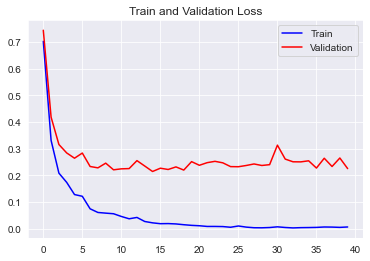

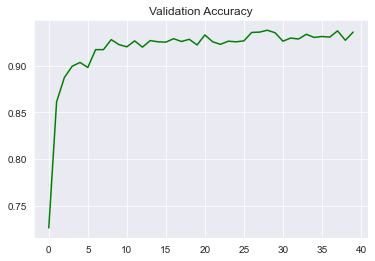

Epoch: 	Train loss / 	Validation loss ; 	Train accuracy / 	Validation accuracy
++++ 0: 	0.7026 / 	0.7442 ; 	0.7460 / 	0.7263
++++ 1: 	0.3314 / 	0.4184 ; 	0.8993 / 	0.8613
++++ 2: 	0.2087 / 	0.3160 ; 	0.9367 / 	0.8874
++++ 3: 	0.1740 / 	0.2844 ; 	0.9400 / 	0.8995
++++ 4: 	0.1284 / 	0.2647 ; 	0.9560 / 	0.9035
+-+- 5: 	0.1220 / 	0.2839 ; 	0.9627 / 	0.8982
++++ 6: 	0.0750 / 	0.2336 ; 	0.9740 / 	0.9173
+++- 7: 	0.0613 / 	0.2285 ; 	0.9847 / 	0.9173
+--+ 8: 	0.0588 / 	0.2461 ; 	0.9813 / 	0.9280
+++- 9: 	0.0565 / 	0.2212 ; 	0.9867 / 	0.9226
+--- 10: 	0.0463 / 	0.2248 ; 	0.9853 / 	0.9203
+-++ 11: 	0.0376 / 	0.2258 ; 	0.9920 / 	0.9266
---- 12: 	0.0427 / 	0.2556 ; 	0.9887 / 	0.9199
++++ 13: 	0.0275 / 	0.2353 ; 	0.9940 / 	0.9270
+++- 14: 	0.0224 / 	0.2149 ; 	0.9947 / 	0.9256
+-+- 15: 	0.0192 / 	0.2272 ; 	0.9960 / 	0.9253
-+++ 16: 	0.0196 / 	0.2224 ; 	0.9967 / 	0.9290
+--- 17: 	0.0183 / 	0.2321 ; 	0.9947 / 	0.9260
++++ 18: 	0.0154 / 	0.2202 ; 	0.9973 / 	0.9283
+-+- 19: 	0.0130 / 	0.2518 ; 	0.9987 /

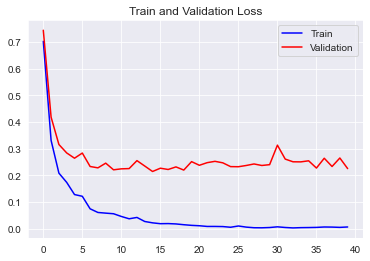

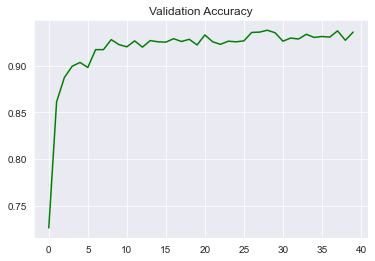

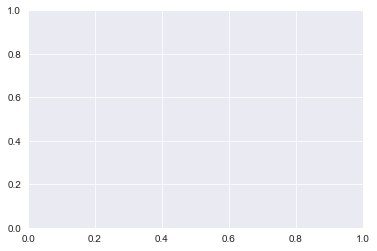

In [58]:
# Optimizing the pretext task
model_efficient_b0 = torchvision.models.efficientnet_b0(weights='IMAGENET1K_V1')

# Pretext Task
angles = [0, 90, 180, 270]
pretext_task = RotationPretext(angles=angles)
modify_classification_head(model_efficient_b0, num_classes=len(angles))

make_trainable(model_efficient_b0, train_features=True, train_classifier=True)

train_config = TrainConfig(lr=0.00010553745281562575, batch_size=14, num_epochs=40)

model_efficient_b0, train_log = train_on_custom_batch_size(model_efficient_b0, train_config,
                                      log_descr="rot-only-optimized-2", pretext_task=pretext_task)

train_log.analysis()

In [63]:
# some overfitting; learning rate too high? ; continue working with cut off at epoch 10, might check later
# 2nd model, cut off at 14
best_rot_only_model = load_model("outputs/optimized runs/rot-only-optimized-2_20230823_125417/model_epoch_14.pt", num_classes=4, evaluation_mode=False)

Starting hyperparameter search at 2023-08-23 14:01:37
  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]

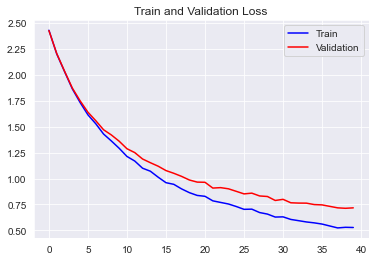

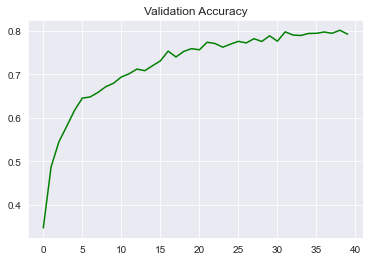

New best parameter set: (8.064128572396214e-05, 12), with loss 0.7128798429027619, accuracy 0.8006700167504187
  5%|▌         | 1/20 [29:43<9:24:42, 1783.30s/trial, best loss: 0.7128798429027619]

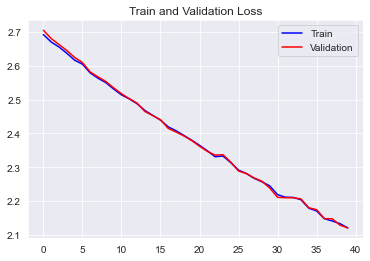

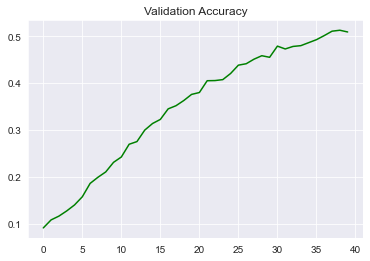

 10%|█         | 2/20 [56:52<8:27:52, 1692.92s/trial, best loss: 0.7128798429027619]

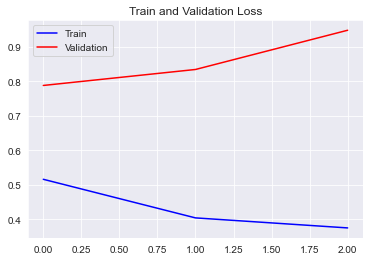

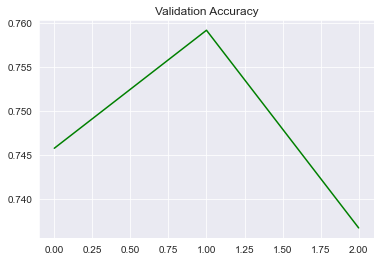

 15%|█▌        | 3/20 [59:19<4:39:35, 986.80s/trial, best loss: 0.7128798429027619] 

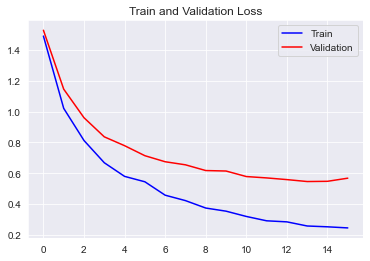

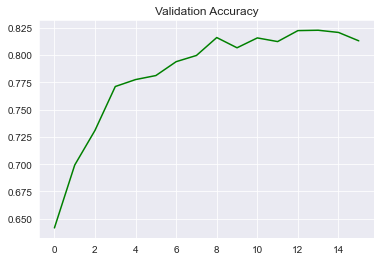

New best parameter set: (0.0006140513500364525, 13), with loss 0.546544134390095, accuracy 0.8227805695142378
 20%|██        | 4/20 [1:11:10<3:54:04, 877.79s/trial, best loss: 0.546544134390095] 

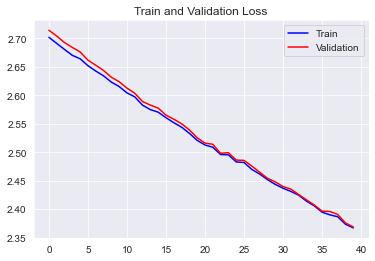

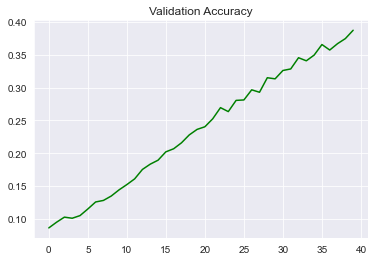

 25%|██▌       | 5/20 [1:42:40<5:10:41, 1242.75s/trial, best loss: 0.546544134390095]

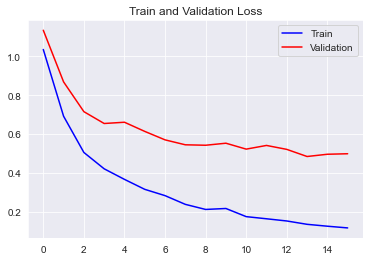

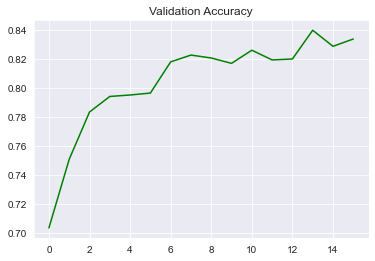

New best parameter set: (0.0013202781683553616, 16), with loss 0.4842314582298146, accuracy 0.8395309882747068
 30%|███       | 6/20 [1:56:24<4:16:45, 1100.41s/trial, best loss: 0.4842314582298146]

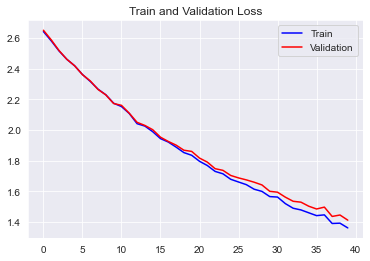

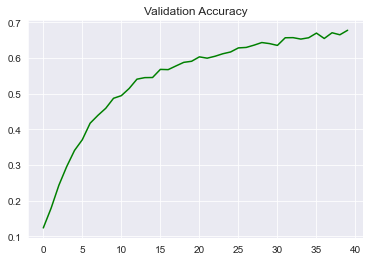

 35%|███▌      | 7/20 [2:30:12<5:04:09, 1403.77s/trial, best loss: 0.4842314582298146]

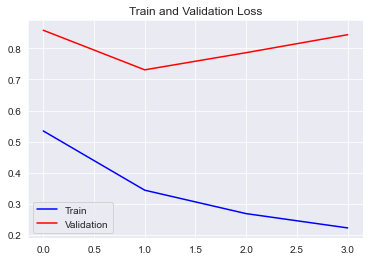

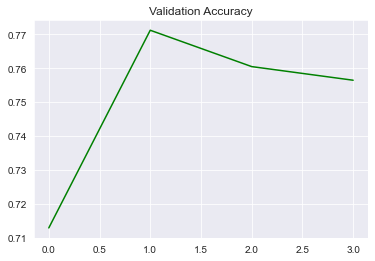

 40%|████      | 8/20 [2:33:17<3:23:08, 1015.67s/trial, best loss: 0.4842314582298146]

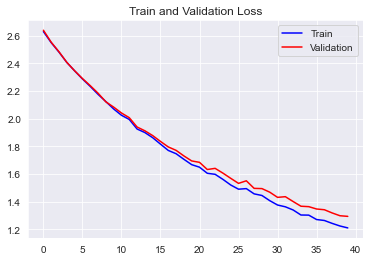

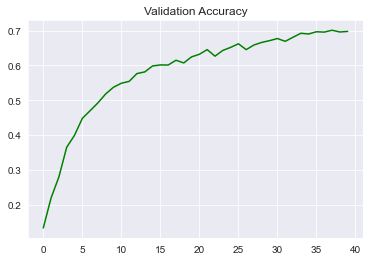

 45%|████▌     | 9/20 [3:01:31<3:45:04, 1227.71s/trial, best loss: 0.4842314582298146]

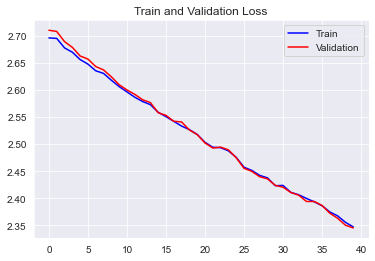

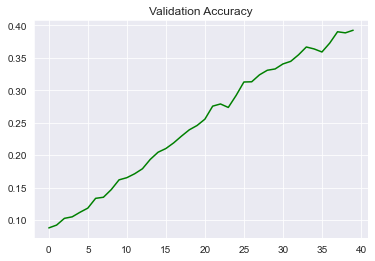

 50%|█████     | 10/20 [3:32:14<3:56:16, 1417.69s/trial, best loss: 0.4842314582298146]

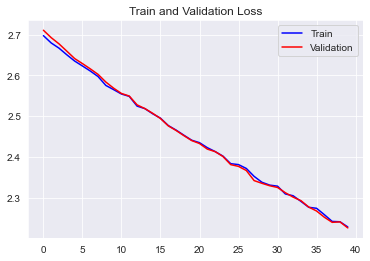

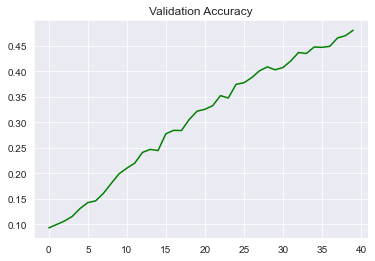

 55%|█████▌    | 11/20 [4:01:58<3:49:28, 1529.87s/trial, best loss: 0.4842314582298146]

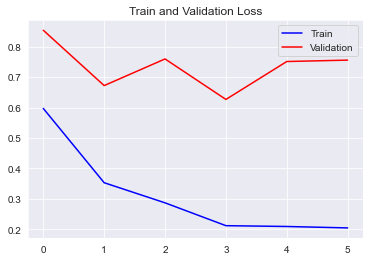

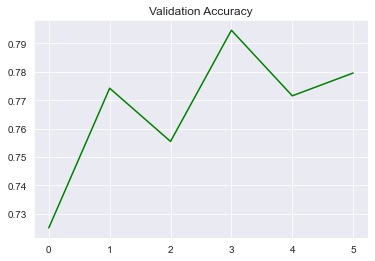

 60%|██████    | 12/20 [4:06:50<2:33:45, 1153.21s/trial, best loss: 0.4842314582298146]

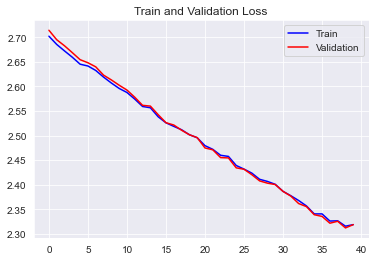

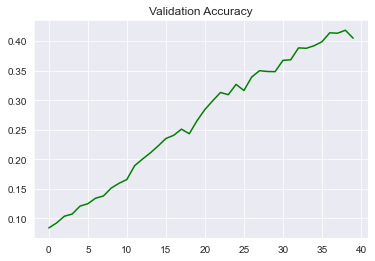

 65%|██████▌   | 13/20 [4:39:16<2:42:34, 1393.44s/trial, best loss: 0.4842314582298146]

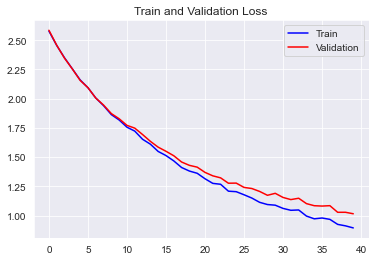

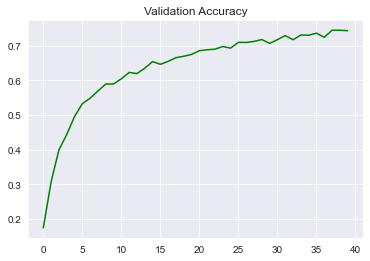

 70%|███████   | 14/20 [5:08:34<2:30:21, 1503.66s/trial, best loss: 0.4842314582298146]

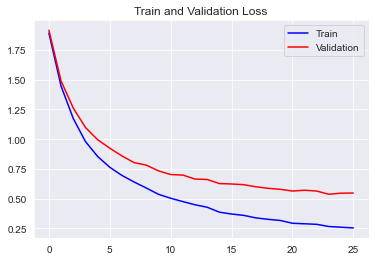

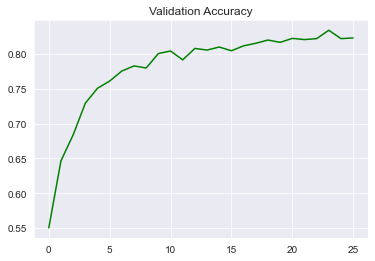

 75%|███████▌  | 15/20 [5:25:08<1:52:30, 1350.03s/trial, best loss: 0.4842314582298146]

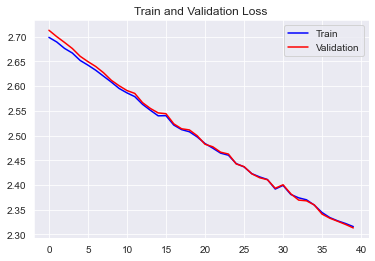

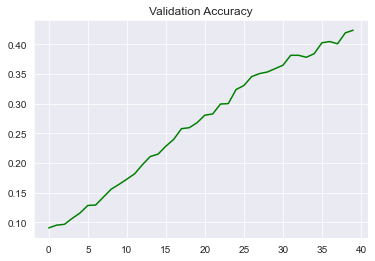

 80%|████████  | 16/20 [5:51:03<1:34:06, 1411.53s/trial, best loss: 0.4842314582298146]

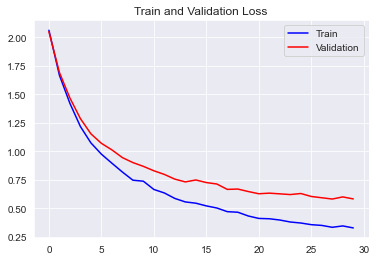

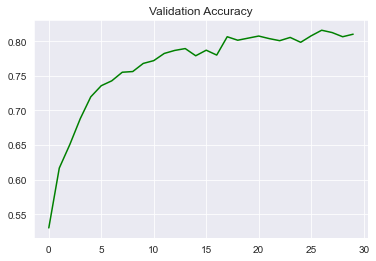

 85%|████████▌ | 17/20 [6:10:56<1:07:18, 1346.07s/trial, best loss: 0.4842314582298146]

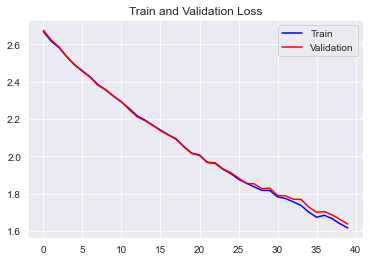

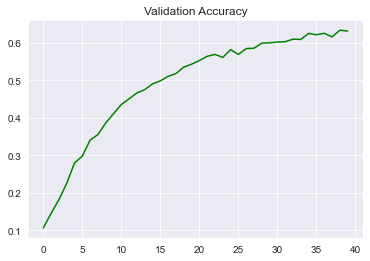

 90%|█████████ | 18/20 [6:37:51<47:33, 1426.73s/trial, best loss: 0.4842314582298146]  

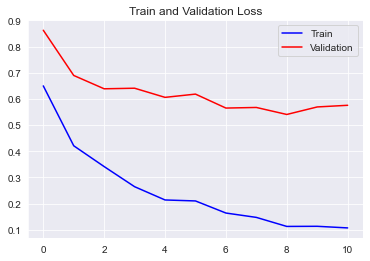

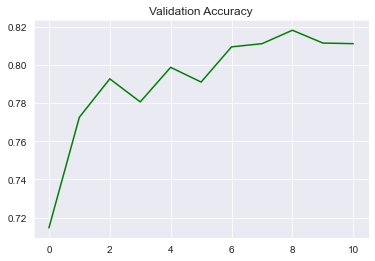

 95%|█████████▌| 19/20 [6:45:09<18:49, 1129.91s/trial, best loss: 0.4842314582298146]

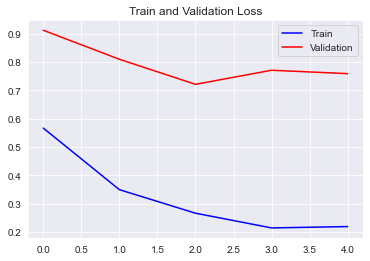

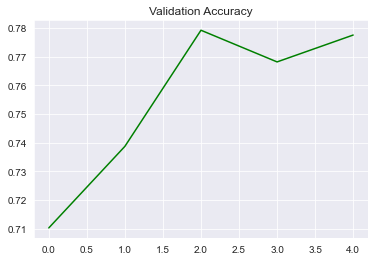

100%|██████████| 20/20 [6:48:35<00:00, 1225.76s/trial, best loss: 0.4842314582298146]
Best parameter set: (0.0013202781683553616, 16), with loss 0.4842314582298146
Hyperopt took 24515.26028895378 seconds


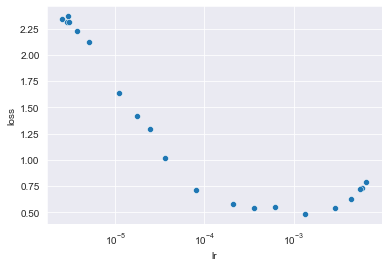

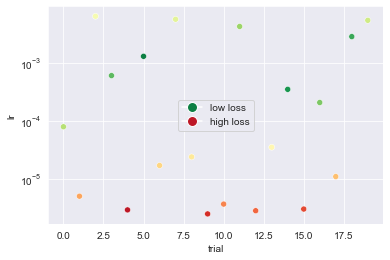

In [64]:
# Actual scene classification task
modify_classification_head(best_rot_only_model, num_classes=NUM_CLASSES)

# make all layers of classifier trainable
make_trainable(best_rot_only_model, train_features=False, train_classifier=True)

best, trials = train_hyperopt(best_rot_only_model, train_config, descr="clf-rot-pretext")

results = HYPEROPT_MODEL_PARAMS["all_results"]
plot_paramsearch(results)

100%|██████████| 94/94 [00:06<00:00, 15.33it/s]


Saved log info to outputs\clf-rot-pretext-optimized_20230823_213359/log.pickle
Epoch 0 finished. Train loss: 1.039713959744636, Val loss: 1.142257023303904, Val accuracy: 0.7031825795644892


100%|██████████| 94/94 [00:07<00:00, 13.21it/s]


Saved log info to outputs\clf-rot-pretext-optimized_20230823_213359/log.pickle
Epoch 1 finished. Train loss: 0.6830183067854415, Val loss: 0.8539496628358403, Val accuracy: 0.7688442211055276


100%|██████████| 94/94 [00:06<00:00, 13.64it/s]


Saved log info to outputs\clf-rot-pretext-optimized_20230823_213359/log.pickle
Epoch 2 finished. Train loss: 0.5176906368516861, Val loss: 0.7171277222148875, Val accuracy: 0.7845896147403685


100%|██████████| 94/94 [00:07<00:00, 12.46it/s]


Saved log info to outputs\clf-rot-pretext-optimized_20230823_213359/log.pickle
Epoch 3 finished. Train loss: 0.4336640371921215, Val loss: 0.6754514627596911, Val accuracy: 0.7899497487437186


100%|██████████| 94/94 [00:09<00:00,  9.42it/s]


Saved log info to outputs\clf-rot-pretext-optimized_20230823_213359/log.pickle
Epoch 4 finished. Train loss: 0.3738022156535311, Val loss: 0.6139567420285016, Val accuracy: 0.807035175879397


100%|██████████| 94/94 [00:08<00:00, 11.40it/s]


Saved log info to outputs\clf-rot-pretext-optimized_20230823_213359/log.pickle
Epoch 5 finished. Train loss: 0.3036632068613742, Val loss: 0.5894086698797297, Val accuracy: 0.802680067001675


100%|██████████| 94/94 [00:08<00:00, 10.80it/s]


Saved log info to outputs\clf-rot-pretext-optimized_20230823_213359/log.pickle
Epoch 6 finished. Train loss: 0.26627849121677116, Val loss: 0.5571804685707398, Val accuracy: 0.8214405360134003


100%|██████████| 94/94 [00:11<00:00,  8.50it/s]


Saved log info to outputs\clf-rot-pretext-optimized_20230823_213359/log.pickle
Epoch 7 finished. Train loss: 0.23035684925444583, Val loss: 0.5322864477567494, Val accuracy: 0.830820770519263


100%|██████████| 94/94 [00:10<00:00,  8.72it/s]


Saved log info to outputs\clf-rot-pretext-optimized_20230823_213359/log.pickle
Epoch 8 finished. Train loss: 0.2139274841372637, Val loss: 0.5302863949760396, Val accuracy: 0.8251256281407036


100%|██████████| 94/94 [00:08<00:00, 11.33it/s]


Saved log info to outputs\clf-rot-pretext-optimized_20230823_213359/log.pickle
Epoch 9 finished. Train loss: 0.2042821280341199, Val loss: 0.5367133467592657, Val accuracy: 0.8140703517587939


100%|██████████| 94/94 [00:08<00:00, 10.93it/s]


Saved log info to outputs\clf-rot-pretext-optimized_20230823_213359/log.pickle
Epoch 10 finished. Train loss: 0.16813907296733654, Val loss: 0.5201633229931408, Val accuracy: 0.823785594639866


100%|██████████| 94/94 [00:09<00:00,  9.53it/s]


Saved log info to outputs\clf-rot-pretext-optimized_20230823_213359/log.pickle
Epoch 11 finished. Train loss: 0.1563704314621839, Val loss: 0.51394911524765, Val accuracy: 0.8268006700167504


100%|██████████| 94/94 [00:10<00:00,  8.77it/s]


Saved log info to outputs\clf-rot-pretext-optimized_20230823_213359/log.pickle
Epoch 12 finished. Train loss: 0.14191955878855067, Val loss: 0.5064920752364046, Val accuracy: 0.8318257956448911


100%|██████████| 94/94 [00:08<00:00, 10.67it/s]


Saved log info to outputs\clf-rot-pretext-optimized_20230823_213359/log.pickle
Epoch 13 finished. Train loss: 0.14506754182041326, Val loss: 0.527546580621903, Val accuracy: 0.8157453936348409


100%|██████████| 94/94 [00:08<00:00, 10.50it/s]


Saved log info to outputs\clf-rot-pretext-optimized_20230823_213359/log.pickle
Epoch 14 finished. Train loss: 0.11394706245591031, Val loss: 0.5157976152903256, Val accuracy: 0.8204355108877722


100%|██████████| 94/94 [00:09<00:00, 10.11it/s]


Saved log info to outputs\clf-rot-pretext-optimized_20230823_213359/log.pickle
Epoch 15 finished. Train loss: 0.11421790233555626, Val loss: 0.5108764189927973, Val accuracy: 0.8271356783919598


100%|██████████| 94/94 [00:10<00:00,  9.10it/s]


Saved log info to outputs\clf-rot-pretext-optimized_20230823_213359/log.pickle
Epoch 16 finished. Train loss: 0.10023764142409917, Val loss: 0.5062556476357148, Val accuracy: 0.826465661641541


100%|██████████| 94/94 [00:08<00:00, 11.01it/s]


Saved log info to outputs\clf-rot-pretext-optimized_20230823_213359/log.pickle
Epoch 17 finished. Train loss: 0.09935522438126042, Val loss: 0.5148274269014756, Val accuracy: 0.823785594639866


100%|██████████| 94/94 [00:09<00:00,  9.47it/s]


Saved log info to outputs\clf-rot-pretext-optimized_20230823_213359/log.pickle
Epoch 18 finished. Train loss: 0.0929304597542641, Val loss: 0.4964864611386615, Val accuracy: 0.8328308207705193


100%|██████████| 94/94 [00:08<00:00, 10.83it/s]


Saved log info to outputs\clf-rot-pretext-optimized_20230823_213359/log.pickle
Epoch 19 finished. Train loss: 0.08759209688039536, Val loss: 0.49449819015627877, Val accuracy: 0.8284757118927973


100%|██████████| 94/94 [00:08<00:00, 10.89it/s]


Saved log info to outputs\clf-rot-pretext-optimized_20230823_213359/log.pickle
Epoch 20 finished. Train loss: 0.08767208201374779, Val loss: 0.5153510957796943, Val accuracy: 0.8271356783919598


100%|██████████| 94/94 [00:08<00:00, 11.27it/s]


Saved log info to outputs\clf-rot-pretext-optimized_20230823_213359/log.pickle
Epoch 21 finished. Train loss: 0.07536400664359966, Val loss: 0.5115840959756132, Val accuracy: 0.8244556113902848


100%|██████████| 94/94 [00:08<00:00, 10.85it/s]


Saved log info to outputs\clf-rot-pretext-optimized_20230823_213359/log.pickle
Epoch 22 finished. Train loss: 0.06825526691775055, Val loss: 0.48947992024415315, Val accuracy: 0.8375209380234506


100%|██████████| 94/94 [00:08<00:00, 10.72it/s]


Saved log info to outputs\clf-rot-pretext-optimized_20230823_213359/log.pickle
Epoch 23 finished. Train loss: 0.06828698109676863, Val loss: 0.48239553727727524, Val accuracy: 0.8355108877721943


100%|██████████| 94/94 [00:12<00:00,  7.67it/s]


Saved log info to outputs\clf-rot-pretext-optimized_20230823_213359/log.pickle
Epoch 24 finished. Train loss: 0.06507797931578566, Val loss: 0.5091961056073719, Val accuracy: 0.8301507537688442


100%|██████████| 94/94 [00:08<00:00, 11.34it/s]


Saved log info to outputs\clf-rot-pretext-optimized_20230823_213359/log.pickle
Epoch 25 finished. Train loss: 0.07105814992509624, Val loss: 0.5281603771017834, Val accuracy: 0.8174204355108877


100%|██████████| 94/94 [00:08<00:00, 10.92it/s]


Saved log info to outputs\clf-rot-pretext-optimized_20230823_213359/log.pickle
Epoch 26 finished. Train loss: 0.05425114051854991, Val loss: 0.4673542742104454, Val accuracy: 0.8418760469011726


100%|██████████| 94/94 [00:08<00:00, 11.23it/s]


Saved log info to outputs\clf-rot-pretext-optimized_20230823_213359/log.pickle
Epoch 27 finished. Train loss: 0.062188048153481584, Val loss: 0.4972020677704225, Val accuracy: 0.8355108877721943


100%|██████████| 94/94 [00:08<00:00, 10.50it/s]


Saved log info to outputs\clf-rot-pretext-optimized_20230823_213359/log.pickle
Epoch 28 finished. Train loss: 0.05762455406341147, Val loss: 0.5005694581942762, Val accuracy: 0.8341708542713567


100%|██████████| 94/94 [00:09<00:00, 10.30it/s]


Saved log info to outputs\clf-rot-pretext-optimized_20230823_213359/log.pickle
Epoch 29 finished. Train loss: 0.057093905364262294, Val loss: 0.5343093995981038, Val accuracy: 0.8278056951423786


100%|██████████| 94/94 [00:08<00:00, 10.70it/s]


Saved log info to outputs\clf-rot-pretext-optimized_20230823_213359/log.pickle
Epoch 30 finished. Train loss: 0.046568811048773376, Val loss: 0.4928490541437093, Val accuracy: 0.8361809045226131


100%|██████████| 94/94 [00:09<00:00, 10.44it/s]


Saved log info to outputs\clf-rot-pretext-optimized_20230823_213359/log.pickle
Epoch 31 finished. Train loss: 0.04579997779008873, Val loss: 0.49947753022698793, Val accuracy: 0.8321608040201005
Saved log info to outputs\clf-rot-pretext-optimized_20230823_213359/log.pickle


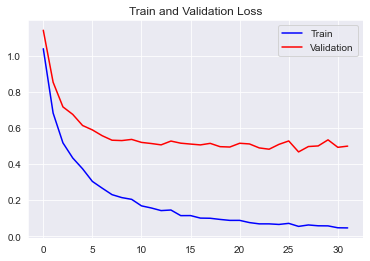

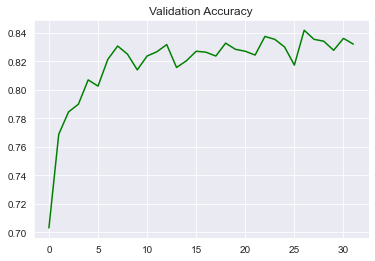

Epoch: 	Train loss / 	Validation loss ; 	Train accuracy / 	Validation accuracy
++++ 0: 	1.0397 / 	1.1423 ; 	0.7727 / 	0.7032
++++ 1: 	0.6830 / 	0.8539 ; 	0.8407 / 	0.7688
++++ 2: 	0.5177 / 	0.7171 ; 	0.8753 / 	0.7846
++++ 3: 	0.4337 / 	0.6755 ; 	0.9027 / 	0.7899
++++ 4: 	0.3738 / 	0.6140 ; 	0.9213 / 	0.8070
+++- 5: 	0.3037 / 	0.5894 ; 	0.9393 / 	0.8027
++++ 6: 	0.2663 / 	0.5572 ; 	0.9473 / 	0.8214
++++ 7: 	0.2304 / 	0.5323 ; 	0.9607 / 	0.8308
++-- 8: 	0.2139 / 	0.5303 ; 	0.9573 / 	0.8251
+--- 9: 	0.2043 / 	0.5367 ; 	0.9520 / 	0.8141
++++ 10: 	0.1681 / 	0.5202 ; 	0.9727 / 	0.8238
++++ 11: 	0.1564 / 	0.5139 ; 	0.9773 / 	0.8268
++-+ 12: 	0.1419 / 	0.5065 ; 	0.9767 / 	0.8318
--+- 13: 	0.1451 / 	0.5275 ; 	0.9787 / 	0.8157
++++ 14: 	0.1139 / 	0.5158 ; 	0.9847 / 	0.8204
-+-+ 15: 	0.1142 / 	0.5109 ; 	0.9833 / 	0.8271
+++- 16: 	0.1002 / 	0.5063 ; 	0.9860 / 	0.8265
+-+- 17: 	0.0994 / 	0.5148 ; 	0.9867 / 	0.8238
++++ 18: 	0.0929 / 	0.4965 ; 	0.9880 / 	0.8328
+++- 19: 	0.0876 / 	0.4945 ; 	0.9887 /

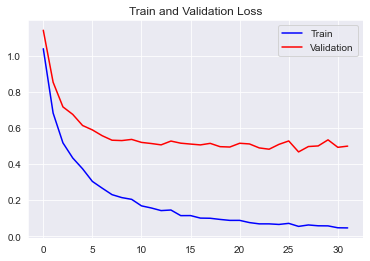

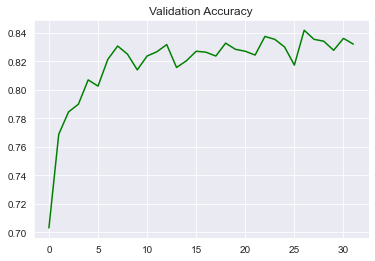

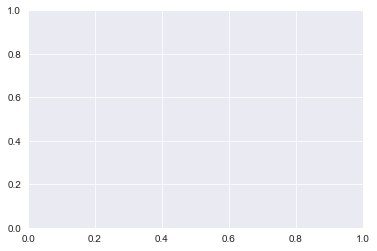

In [68]:
best_rot_only_model = load_model("outputs/optimized runs/rot-only-optimized-2_20230823_125417/model_epoch_14.pt", num_classes=4, evaluation_mode=False)

# Actual scene classification task
modify_classification_head(best_rot_only_model, num_classes=NUM_CLASSES)

# make all layers of classifier trainable
make_trainable(best_rot_only_model, train_features=False, train_classifier=True)

train_config = TrainConfig(lr=0.0013202781683553616, batch_size=16, num_epochs=32)

best_rot_only_model, train_log = train_on_custom_batch_size(best_rot_only_model, train_config,
                                      log_descr="clf-rot-pretext-optimized", pretext_task=None)

train_log.analysis()

### 3.2.2 Pretext Task 2: Perturbation Classification
checkpoint3

In [29]:
class PerturbationPretext:
    def __init__(self, perbutation_colors=[0, 255]):
        self.perbutation_colors = perbutation_colors

    def __call__(self, inputs, labels):
        """
        :param inputs: batch of images
        :param labels: batch of labels
        :return: perturbed images and labels corresponding the perturbation color
        """
        for i in range(len(inputs)):
            perturbation_index = np.random.randint(len(self.perbutation_colors))
            perturbation_color = self.perbutation_colors[perturbation_index]
            inputs[i] = self._apply_perturbation(inputs[i], perturbation_color)
            labels[i] = perturbation_index
        return inputs, labels

    def _apply_perturbation(self, input, color):
        """
        To do the perturbation you need to define a random square region W with a shape 10 × 10 on an image. Then, the pixels within the window are set to given color
        """
        region_size = 10
        x = np.random.randint(0, input.shape[1] - region_size)
        y = np.random.randint(0, input.shape[2] - region_size)
        input[:, x:x + region_size, y:y + region_size] = color
        return input

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


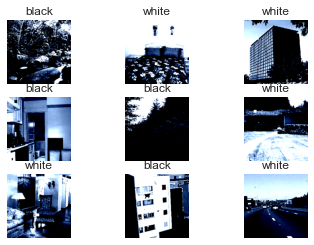

In [26]:
# test the perturbation pretext task
images, labels = next(iter(train_loader))

perturbation_pretext = PerturbationPretext()
images, labels = perturbation_pretext(images, labels)

visualize_3x3_images(images, labels, class_names=["black", "white"])

In [55]:
model_efficient_b0 = torchvision.models.efficientnet_b0(weights='IMAGENET1K_V1')

# Pretext Task
modify_classification_head(model_efficient_b0, num_classes=2)

make_trainable(model_efficient_b0, train_features=True, train_classifier=True)

train_config = TrainConfig()

pretext_task = PerturbationPretext()

model_efficient_b0, pretext_log = train(model_efficient_b0, train_loader, val_loader, train_config,
                                        pretext_task=pretext_task, log_descr="pretext_only_perturbation")

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


100%|██████████| 100/100 [00:19<00:00,  5.22it/s]


Saved log info to outputs\pretext_perturbation_20230612_194842/log.txt
Epoch 0 finished. Train loss: 2.7325305461883547, Val loss: 2.6276729681983064, Val accuracy: 0.13835845896147403


100%|██████████| 100/100 [00:18<00:00,  5.32it/s]


Saved log info to outputs\pretext_perturbation_20230612_194842/log.txt
Epoch 1 finished. Train loss: 2.5749547719955443, Val loss: 2.5265056296209596, Val accuracy: 0.27571189279731995


100%|██████████| 100/100 [00:18<00:00,  5.29it/s]


Saved log info to outputs\pretext_perturbation_20230612_194842/log.txt
Epoch 2 finished. Train loss: 2.4905959606170653, Val loss: 2.4385680241800434, Val accuracy: 0.3849246231155779


100%|██████████| 100/100 [00:18<00:00,  5.29it/s]


Saved log info to outputs\pretext_perturbation_20230612_194842/log.txt
Epoch 3 finished. Train loss: 2.3960495710372927, Val loss: 2.3459761070845713, Val accuracy: 0.45494137353433833


100%|██████████| 100/100 [00:18<00:00,  5.27it/s]


Saved log info to outputs\pretext_perturbation_20230612_194842/log.txt
Epoch 4 finished. Train loss: 2.281072902679443, Val loss: 2.2591456396495877, Val accuracy: 0.5139028475711893


100%|██████████| 100/100 [00:19<00:00,  5.26it/s]


Saved log info to outputs\pretext_perturbation_20230612_194842/log.txt
Epoch 5 finished. Train loss: 2.192849326133728, Val loss: 2.1781382986049556, Val accuracy: 0.5474036850921273


100%|██████████| 100/100 [00:18<00:00,  5.29it/s]


Saved log info to outputs\pretext_perturbation_20230612_194842/log.txt
Epoch 6 finished. Train loss: 2.12586704492569, Val loss: 2.11123553232931, Val accuracy: 0.5792294807370184


100%|██████████| 100/100 [00:19<00:00,  5.26it/s]


Saved log info to outputs\pretext_perturbation_20230612_194842/log.txt
Epoch 7 finished. Train loss: 2.1030843615531922, Val loss: 2.0553200700175225, Val accuracy: 0.6040201005025125


100%|██████████| 100/100 [00:18<00:00,  5.28it/s]


Saved log info to outputs\pretext_perturbation_20230612_194842/log.txt
Epoch 8 finished. Train loss: 2.022720766067505, Val loss: 1.9619139283146692, Val accuracy: 0.6438860971524288


100%|██████████| 100/100 [00:18<00:00,  5.29it/s]


Saved log info to outputs\pretext_perturbation_20230612_194842/log.txt
Epoch 9 finished. Train loss: 1.9296969771385193, Val loss: 1.9197235994003525, Val accuracy: 0.6455611390284757


100%|██████████| 100/100 [00:19<00:00,  5.24it/s]


Saved log info to outputs\pretext_perturbation_20230612_194842/log.txt
Epoch 10 finished. Train loss: 1.8853028535842895, Val loss: 1.855462760781523, Val accuracy: 0.6596314907872697


100%|██████████| 100/100 [00:18<00:00,  5.28it/s]


Saved log info to outputs\pretext_perturbation_20230612_194842/log.txt
Epoch 11 finished. Train loss: 1.79427490234375, Val loss: 1.8138326436430965, Val accuracy: 0.671356783919598


100%|██████████| 100/100 [00:19<00:00,  5.26it/s]


Saved log info to outputs\pretext_perturbation_20230612_194842/log.txt
Epoch 12 finished. Train loss: 1.7792096853256225, Val loss: 1.7533776226954245, Val accuracy: 0.6894472361809045


100%|██████████| 100/100 [00:18<00:00,  5.29it/s]


Saved log info to outputs\pretext_perturbation_20230612_194842/log.txt
Epoch 13 finished. Train loss: 1.7163466572761537, Val loss: 1.7250414673407473, Val accuracy: 0.6807370184254606


100%|██████████| 100/100 [00:18<00:00,  5.27it/s]


Saved log info to outputs\pretext_perturbation_20230612_194842/log.txt
Epoch 14 finished. Train loss: 1.7008320093154907, Val loss: 1.6658432831117256, Val accuracy: 0.6984924623115578
Saved log info to outputs\pretext_perturbation_20230612_194842/log.txt


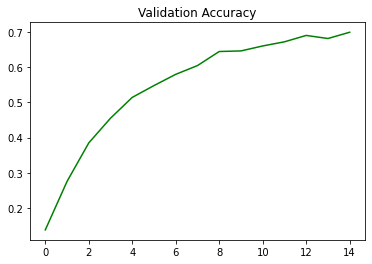

In [67]:
# Load the model from the pretext task (epoch 2)
model_efficient_b0 = load_model("outputs/pretext_only_perturbation_20230612_193316/model_epoch_2.pt", 2)

# Actual scene classification task
modify_classification_head(model_efficient_b0, num_classes=NUM_CLASSES)

# make all layers of classifier trainable
make_trainable(model_efficient_b0, train_features=False, train_classifier=True)

model_efficient_b0, train_log = train(model_efficient_b0, train_loader, val_loader, train_config,
                                      log_descr="pretext_perturbation")

New best parameter set: (0.001077841103363609, 10), with loss 1.6924675443522842e-05, accuracy 1.0
New best parameter set: (0.0007650747992488887, 10), with loss 2.634426096555533e-06, accuracy 1.0
New best parameter set: (0.001830703178480443, 15), with loss 1.698998028675063e-06, accuracy 1.0
100%|██████████| 20/20 [4:22:05<00:00, 786.25s/trial, best loss: 1.698998028675063e-06]   
Best parameter set: (0.001830703178480443, 15), with loss 1.698998028675063e-06
Hyperopt took 15725.072422027588 seconds


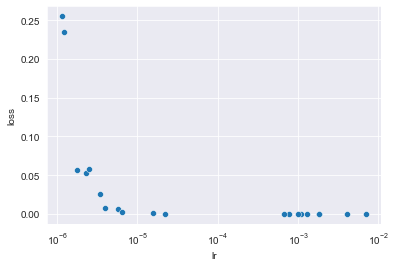

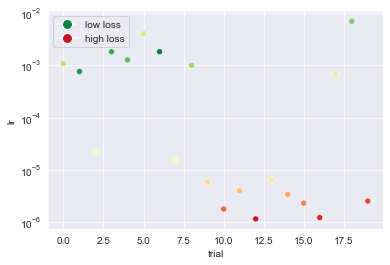

In [31]:
model_efficient_b0 = torchvision.models.efficientnet_b0(weights='IMAGENET1K_V1')

# Pretext Task
modify_classification_head(model_efficient_b0, num_classes=2)

make_trainable(model_efficient_b0, train_features=True, train_classifier=True)

train_config = TrainConfig()

pretext_task = PerturbationPretext()

best, trials = train_hyperopt(model_efficient_b0, train_config, pretext_task=pretext_task, descr="rot-only")

results = HYPEROPT_MODEL_PARAMS["all_results"]
plot_paramsearch(results)
# 0.001830703178480443; 15

100%|██████████| 100/100 [00:13<00:00,  7.36it/s]


Saved log info to outputs\pert-only-optimized_20230823_034435/log.pickle
Epoch 0 finished. Train loss: 0.0046131344472814815, Val loss: 0.003257588670410897, Val accuracy: 0.9989949748743718


100%|██████████| 100/100 [00:17<00:00,  5.70it/s]


Saved log info to outputs\pert-only-optimized_20230823_034435/log.pickle
Epoch 1 finished. Train loss: 0.0001923720448394306, Val loss: 0.00021150039985934482, Val accuracy: 1.0


100%|██████████| 100/100 [00:17<00:00,  5.58it/s]


Saved log info to outputs\pert-only-optimized_20230823_034435/log.pickle
Epoch 2 finished. Train loss: 7.925215011709952e-05, Val loss: 9.12010630842207e-05, Val accuracy: 1.0


100%|██████████| 100/100 [00:18<00:00,  5.40it/s]


Saved log info to outputs\pert-only-optimized_20230823_034435/log.pickle
Epoch 3 finished. Train loss: 4.475326980809768e-05, Val loss: 5.0428709658459485e-05, Val accuracy: 1.0


100%|██████████| 100/100 [00:17<00:00,  5.57it/s]


Saved log info to outputs\pert-only-optimized_20230823_034435/log.pickle
Epoch 4 finished. Train loss: 3.4635808206076035e-05, Val loss: 3.849106167479879e-05, Val accuracy: 1.0


100%|██████████| 100/100 [00:17<00:00,  5.81it/s]


Saved log info to outputs\pert-only-optimized_20230823_034435/log.pickle
Epoch 5 finished. Train loss: 2.171583235849539e-05, Val loss: 2.497641366514915e-05, Val accuracy: 1.0


100%|██████████| 100/100 [00:20<00:00,  4.90it/s]


Saved log info to outputs\pert-only-optimized_20230823_034435/log.pickle
Epoch 6 finished. Train loss: 1.3242880543202773e-05, Val loss: 1.4431594820221953e-05, Val accuracy: 1.0


100%|██████████| 100/100 [00:19<00:00,  5.02it/s]


Saved log info to outputs\pert-only-optimized_20230823_034435/log.pickle
Epoch 7 finished. Train loss: 1.3071825976567198e-05, Val loss: 1.44589994443553e-05, Val accuracy: 1.0


100%|██████████| 100/100 [00:19<00:00,  5.00it/s]


Saved log info to outputs\pert-only-optimized_20230823_034435/log.pickle
Epoch 8 finished. Train loss: 7.33944170679024e-05, Val loss: 7.752952778581167e-05, Val accuracy: 1.0


100%|██████████| 100/100 [00:17<00:00,  5.58it/s]


Saved log info to outputs\pert-only-optimized_20230823_034435/log.pickle
Epoch 9 finished. Train loss: 5.448325806355569e-05, Val loss: 5.615302445824742e-05, Val accuracy: 1.0


100%|██████████| 100/100 [00:20<00:00,  4.89it/s]


Saved log info to outputs\pert-only-optimized_20230823_034435/log.pickle
Epoch 10 finished. Train loss: 3.5364279146961055e-05, Val loss: 3.616572144097179e-05, Val accuracy: 1.0


100%|██████████| 100/100 [00:19<00:00,  5.02it/s]


Saved log info to outputs\pert-only-optimized_20230823_034435/log.pickle
Epoch 11 finished. Train loss: 2.4577856029281973e-05, Val loss: 2.5449141384657864e-05, Val accuracy: 1.0


100%|██████████| 100/100 [00:19<00:00,  5.19it/s]


Saved log info to outputs\pert-only-optimized_20230823_034435/log.pickle
Epoch 12 finished. Train loss: 0.00011723521291969519, Val loss: 0.00011471911040561779, Val accuracy: 1.0


100%|██████████| 100/100 [00:18<00:00,  5.40it/s]


Saved log info to outputs\pert-only-optimized_20230823_034435/log.pickle
Epoch 13 finished. Train loss: 5.063825108663878e-05, Val loss: 5.400922688279399e-05, Val accuracy: 1.0


100%|██████████| 100/100 [00:19<00:00,  5.06it/s]


Saved log info to outputs\pert-only-optimized_20230823_034435/log.pickle
Epoch 14 finished. Train loss: 3.716446403814189e-05, Val loss: 3.711542905793565e-05, Val accuracy: 1.0


100%|██████████| 100/100 [00:19<00:00,  5.15it/s]


Saved log info to outputs\pert-only-optimized_20230823_034435/log.pickle
Epoch 15 finished. Train loss: 2.3057855150909746e-05, Val loss: 2.3314650481104342e-05, Val accuracy: 1.0


100%|██████████| 100/100 [00:18<00:00,  5.27it/s]


Saved log info to outputs\pert-only-optimized_20230823_034435/log.pickle
Epoch 16 finished. Train loss: 1.6491760461576633e-05, Val loss: 1.711235963236719e-05, Val accuracy: 1.0


100%|██████████| 100/100 [00:18<00:00,  5.53it/s]


Saved log info to outputs\pert-only-optimized_20230823_034435/log.pickle
Epoch 17 finished. Train loss: 1.3571787089858844e-05, Val loss: 1.3263836503778404e-05, Val accuracy: 1.0


100%|██████████| 100/100 [00:19<00:00,  5.03it/s]


Saved log info to outputs\pert-only-optimized_20230823_034435/log.pickle
Epoch 18 finished. Train loss: 1.060394749401894e-05, Val loss: 1.0411310236876622e-05, Val accuracy: 1.0


100%|██████████| 100/100 [00:19<00:00,  5.04it/s]


Saved log info to outputs\pert-only-optimized_20230823_034435/log.pickle
Epoch 19 finished. Train loss: 8.801222188594693e-06, Val loss: 8.921046623959113e-06, Val accuracy: 1.0


100%|██████████| 100/100 [00:19<00:00,  5.24it/s]


Saved log info to outputs\pert-only-optimized_20230823_034435/log.pickle
Epoch 20 finished. Train loss: 7.167367332385766e-06, Val loss: 6.9531063869435825e-06, Val accuracy: 1.0


100%|██████████| 100/100 [00:18<00:00,  5.54it/s]


Saved log info to outputs\pert-only-optimized_20230823_034435/log.pickle
Epoch 21 finished. Train loss: 6.1240584625465995e-06, Val loss: 6.374599755890904e-06, Val accuracy: 1.0


100%|██████████| 100/100 [00:17<00:00,  5.61it/s]


Saved log info to outputs\pert-only-optimized_20230823_034435/log.pickle
Epoch 22 finished. Train loss: 5.530962309876486e-06, Val loss: 5.453244837019211e-06, Val accuracy: 1.0


100%|██████████| 100/100 [00:17<00:00,  5.72it/s]


Saved log info to outputs\pert-only-optimized_20230823_034435/log.pickle
Epoch 23 finished. Train loss: 5.0268719178347965e-06, Val loss: 4.857165120726069e-06, Val accuracy: 1.0


100%|██████████| 100/100 [00:17<00:00,  5.58it/s]


Saved log info to outputs\pert-only-optimized_20230823_034435/log.pickle
Epoch 24 finished. Train loss: 4.697856970778958e-06, Val loss: 4.716551914546256e-06, Val accuracy: 1.0


100%|██████████| 100/100 [00:19<00:00,  5.04it/s]


Saved log info to outputs\pert-only-optimized_20230823_034435/log.pickle
Epoch 25 finished. Train loss: 3.9590038659298445e-06, Val loss: 3.966637760714004e-06, Val accuracy: 1.0


100%|██████████| 100/100 [00:19<00:00,  5.12it/s]


Saved log info to outputs\pert-only-optimized_20230823_034435/log.pickle
Epoch 26 finished. Train loss: 3.458964765741257e-06, Val loss: 3.433774581158767e-06, Val accuracy: 1.0


100%|██████████| 100/100 [00:18<00:00,  5.43it/s]


Saved log info to outputs\pert-only-optimized_20230823_034435/log.pickle
Epoch 27 finished. Train loss: 2.998581031761205e-06, Val loss: 3.108137603925314e-06, Val accuracy: 1.0


100%|██████████| 100/100 [00:18<00:00,  5.47it/s]


Saved log info to outputs\pert-only-optimized_20230823_034435/log.pickle
Epoch 28 finished. Train loss: 2.798072521272843e-06, Val loss: 2.840088333855351e-06, Val accuracy: 1.0


100%|██████████| 100/100 [00:18<00:00,  5.27it/s]


Saved log info to outputs\pert-only-optimized_20230823_034435/log.pickle
Epoch 29 finished. Train loss: 2.5086338808932853e-06, Val loss: 2.4758327462241233e-06, Val accuracy: 1.0


100%|██████████| 100/100 [00:20<00:00,  4.87it/s]


Saved log info to outputs\pert-only-optimized_20230823_034435/log.pickle
Epoch 30 finished. Train loss: 0.00012030235098791309, Val loss: 0.0001233448416844944, Val accuracy: 1.0


100%|██████████| 100/100 [00:18<00:00,  5.36it/s]


Saved log info to outputs\pert-only-optimized_20230823_034435/log.pickle
Epoch 31 finished. Train loss: 3.12821366424032e-05, Val loss: 3.225824402944459e-05, Val accuracy: 1.0


100%|██████████| 100/100 [00:19<00:00,  5.18it/s]


Saved log info to outputs\pert-only-optimized_20230823_034435/log.pickle
Epoch 32 finished. Train loss: 1.8344868267377023e-05, Val loss: 1.8712406543172116e-05, Val accuracy: 1.0


100%|██████████| 100/100 [00:20<00:00,  4.87it/s]


Saved log info to outputs\pert-only-optimized_20230823_034435/log.pickle
Epoch 33 finished. Train loss: 1.2184867632640816e-05, Val loss: 1.2367221928862229e-05, Val accuracy: 1.0


100%|██████████| 100/100 [00:18<00:00,  5.45it/s]


Saved log info to outputs\pert-only-optimized_20230823_034435/log.pickle
Epoch 34 finished. Train loss: 0.00012623589944269043, Val loss: 0.00013033770292122197, Val accuracy: 1.0


100%|██████████| 100/100 [00:16<00:00,  5.94it/s]


Saved log info to outputs\pert-only-optimized_20230823_034435/log.pickle
Epoch 35 finished. Train loss: 2.9910805878898827e-05, Val loss: 3.2818587220646264e-05, Val accuracy: 1.0


100%|██████████| 100/100 [00:17<00:00,  5.77it/s]


Saved log info to outputs\pert-only-optimized_20230823_034435/log.pickle
Epoch 36 finished. Train loss: 1.821802053200372e-05, Val loss: 2.219418951627727e-05, Val accuracy: 1.0


100%|██████████| 100/100 [00:19<00:00,  5.23it/s]


Saved log info to outputs\pert-only-optimized_20230823_034435/log.pickle
Epoch 37 finished. Train loss: 1.0278678776103333e-05, Val loss: 9.824566532828174e-06, Val accuracy: 1.0


100%|██████████| 100/100 [00:16<00:00,  5.99it/s]


Saved log info to outputs\pert-only-optimized_20230823_034435/log.pickle
Epoch 38 finished. Train loss: 8.534355929441517e-06, Val loss: 5.962172412040873e-05, Val accuracy: 1.0


100%|██████████| 100/100 [00:16<00:00,  5.89it/s]


Saved log info to outputs\pert-only-optimized_20230823_034435/log.pickle
Epoch 39 finished. Train loss: 5.493532560194581e-06, Val loss: 5.111872779643498e-06, Val accuracy: 1.0
Saved log info to outputs\pert-only-optimized_20230823_034435/log.pickle


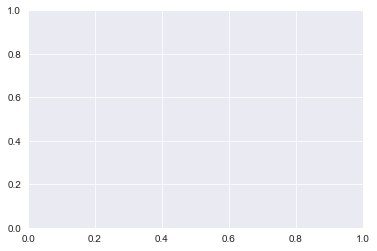

In [36]:
model_efficient_b0 = torchvision.models.efficientnet_b0(weights='IMAGENET1K_V1')

# Pretext Task
modify_classification_head(model_efficient_b0, num_classes=2)

make_trainable(model_efficient_b0, train_features=True, train_classifier=True)

pretext_task = PerturbationPretext()

train_config = TrainConfig(lr=0.001830703178480443, batch_size=15, num_epochs=40)

model_efficient_b0, train_log = train_on_custom_batch_size(model_efficient_b0, train_config,
                                      log_descr="pert-only-optimized", pretext_task=pretext_task)

Epoch: 	Train loss / 	Validation loss ; 	Train accuracy / 	Validation accuracy
++++ 0: 	0.0046 / 	0.0033 ; 	0.9980 / 	0.9990
++++ 1: 	0.0002 / 	0.0002 ; 	1.0000 / 	1.0000
++-- 2: 	0.0001 / 	0.0001 ; 	1.0000 / 	1.0000
++-- 3: 	0.0000 / 	0.0001 ; 	1.0000 / 	1.0000
++-- 4: 	0.0000 / 	0.0000 ; 	1.0000 / 	1.0000
++-- 5: 	0.0000 / 	0.0000 ; 	1.0000 / 	1.0000
++-- 6: 	0.0000 / 	0.0000 ; 	1.0000 / 	1.0000
+--- 7: 	0.0000 / 	0.0000 ; 	1.0000 / 	1.0000
---- 8: 	0.0001 / 	0.0001 ; 	1.0000 / 	1.0000
++-- 9: 	0.0001 / 	0.0001 ; 	1.0000 / 	1.0000
++-- 10: 	0.0000 / 	0.0000 ; 	1.0000 / 	1.0000
++-- 11: 	0.0000 / 	0.0000 ; 	1.0000 / 	1.0000
---- 12: 	0.0001 / 	0.0001 ; 	1.0000 / 	1.0000
++-- 13: 	0.0001 / 	0.0001 ; 	1.0000 / 	1.0000
++-- 14: 	0.0000 / 	0.0000 ; 	1.0000 / 	1.0000
++-- 15: 	0.0000 / 	0.0000 ; 	1.0000 / 	1.0000
++-- 16: 	0.0000 / 	0.0000 ; 	1.0000 / 	1.0000
++-- 17: 	0.0000 / 	0.0000 ; 	1.0000 / 	1.0000
++-- 18: 	0.0000 / 	0.0000 ; 	1.0000 / 	1.0000
++-- 19: 	0.0000 / 	0.0000 ; 	1.0000 /

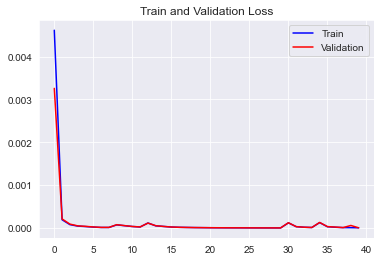

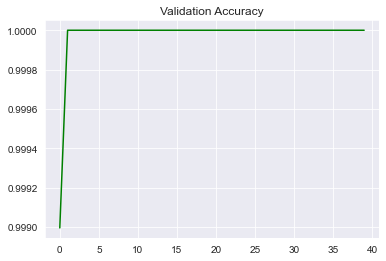

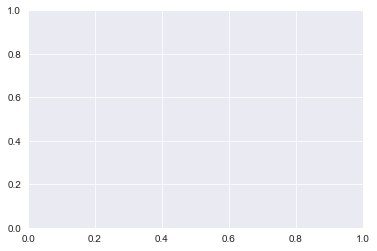

In [47]:
optimized_log = load_log_info("outputs/optimized runs/pert-only-optimized_20230823_034435/log.pickle")
optimized_log.analysis()

In [27]:
# cut off at 6 (7, 8 is validation loss increase and accuracy already 100% for some epochs)
best_pert_model = load_model("outputs/optimized runs/pert-only-optimized_20230823_034435/model_epoch_6.pt", num_classes=2, evaluation_mode=False)


Starting hyperparameter search at 2023-08-24 01:05:25
  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]

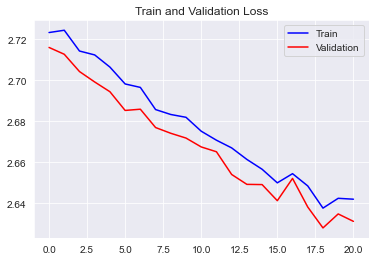

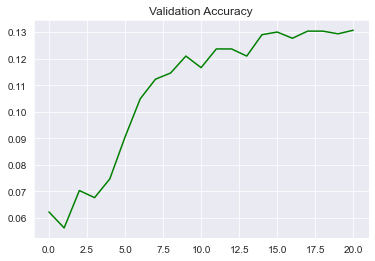

New best parameter set: (1.4627095100612142e-06, 8), with loss 2.628033870681722, accuracy 0.1306532663316583
  5%|▌         | 1/20 [17:06<5:25:07, 1026.71s/trial, best loss: 2.628033870681722]

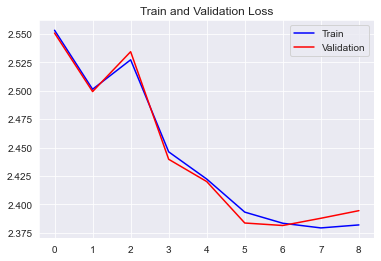

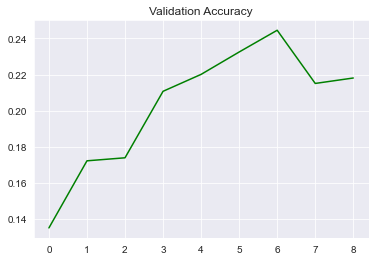

New best parameter set: (0.00011516220422175807, 14), with loss 2.3815292398506234, accuracy 0.24455611390284757
 10%|█         | 2/20 [23:21<3:12:59, 643.31s/trial, best loss: 2.3815292398506234]

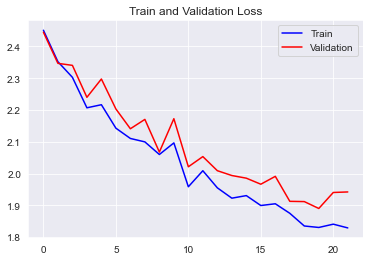

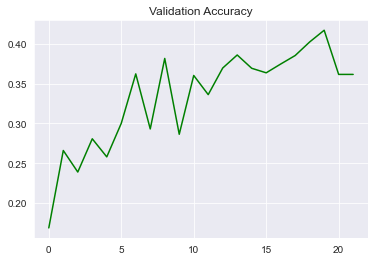

New best parameter set: (0.0009213880776154422, 16), with loss 1.8901610929060748, accuracy 0.41742043551088776
 15%|█▌        | 3/20 [38:23<3:35:41, 761.24s/trial, best loss: 1.8901610929060748]

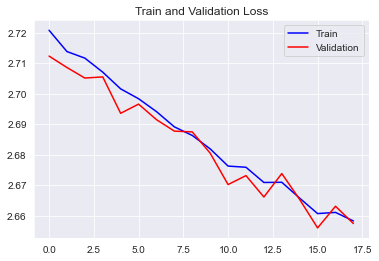

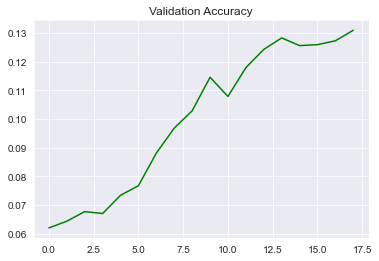

 20%|██        | 4/20 [50:48<3:21:19, 754.97s/trial, best loss: 1.8901610929060748]

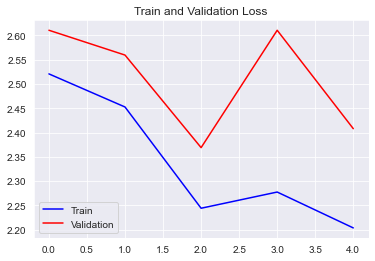

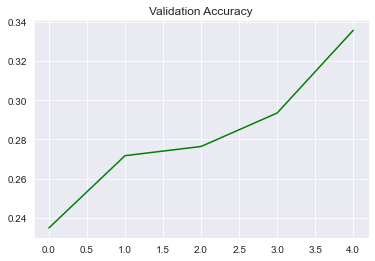

 25%|██▌       | 5/20 [54:24<2:20:11, 560.74s/trial, best loss: 1.8901610929060748]

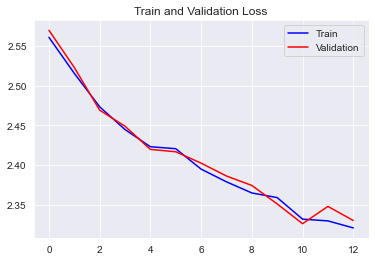

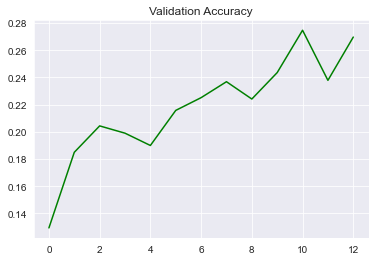

 30%|███       | 6/20 [1:03:30<2:09:38, 555.61s/trial, best loss: 1.8901610929060748]

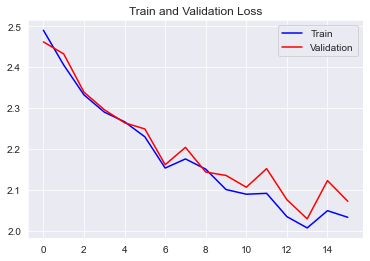

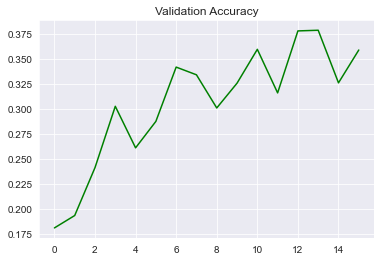

 35%|███▌      | 7/20 [1:15:12<2:10:45, 603.51s/trial, best loss: 1.8901610929060748]

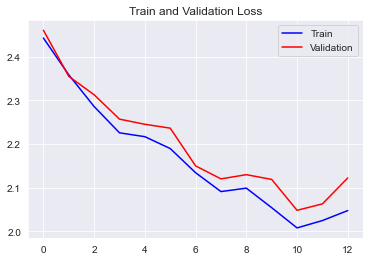

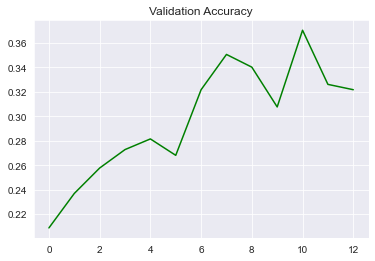

 40%|████      | 8/20 [1:24:14<1:56:47, 583.98s/trial, best loss: 1.8901610929060748]

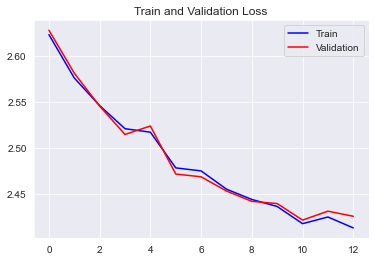

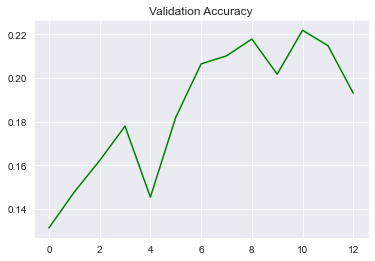

 45%|████▌     | 9/20 [1:33:14<1:44:31, 570.10s/trial, best loss: 1.8901610929060748]

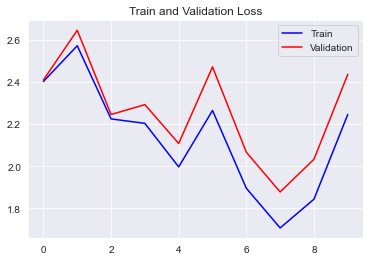

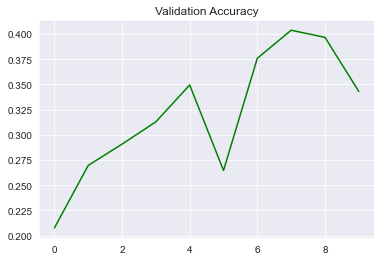

New best parameter set: (0.005788164516006328, 13), with loss 1.87769198184428, accuracy 0.4036850921273032
 50%|█████     | 10/20 [1:40:15<1:27:21, 524.11s/trial, best loss: 1.87769198184428] 

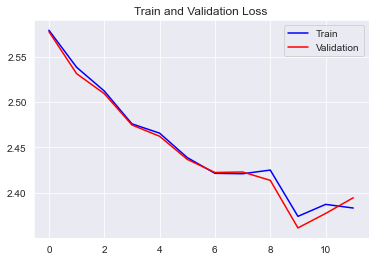

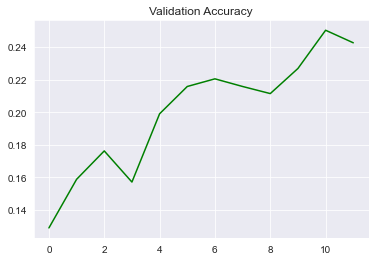

 55%|█████▌    | 11/20 [1:49:30<1:20:02, 533.58s/trial, best loss: 1.87769198184428]

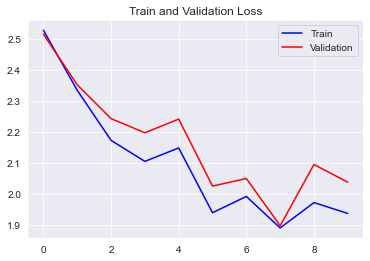

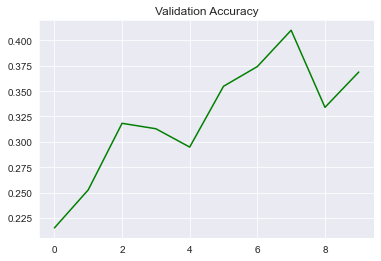

 60%|██████    | 12/20 [1:56:45<1:07:08, 503.59s/trial, best loss: 1.87769198184428]

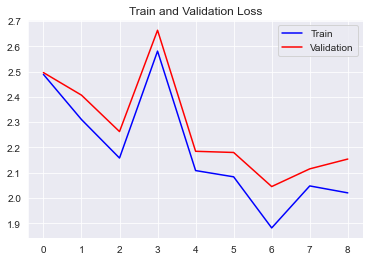

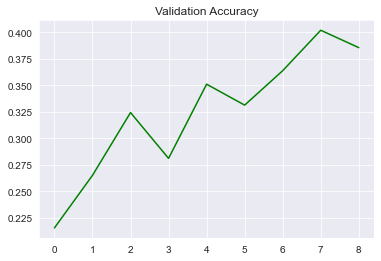

 65%|██████▌   | 13/20 [2:03:13<54:40, 468.64s/trial, best loss: 1.87769198184428]  

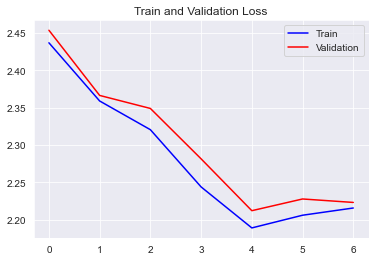

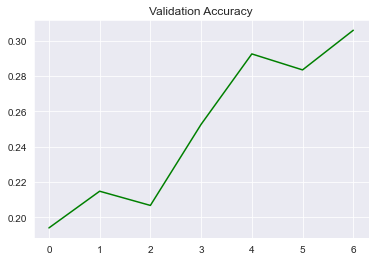

 70%|███████   | 14/20 [2:08:02<41:25, 414.20s/trial, best loss: 1.87769198184428]

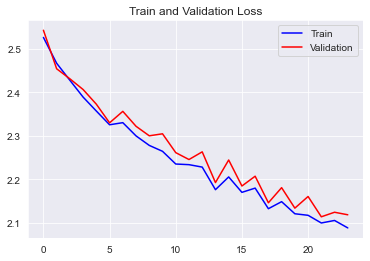

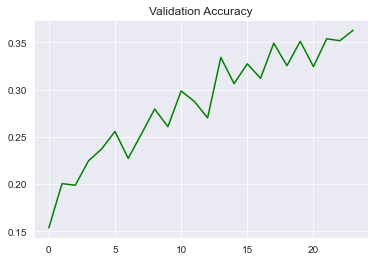

 75%|███████▌  | 15/20 [2:24:30<48:55, 587.11s/trial, best loss: 1.87769198184428]

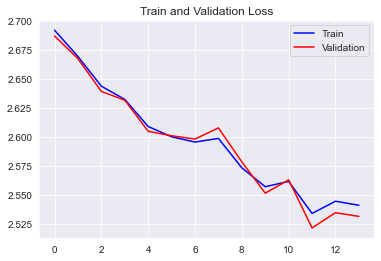

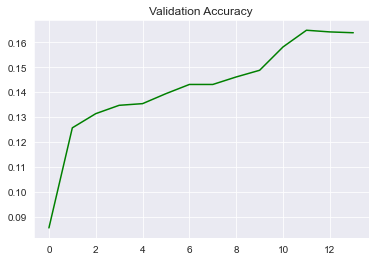

 80%|████████  | 16/20 [2:34:12<39:02, 585.65s/trial, best loss: 1.87769198184428]

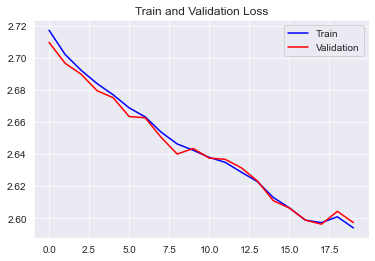

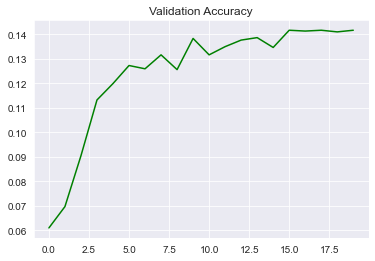

 85%|████████▌ | 17/20 [2:47:56<32:52, 657.50s/trial, best loss: 1.87769198184428]

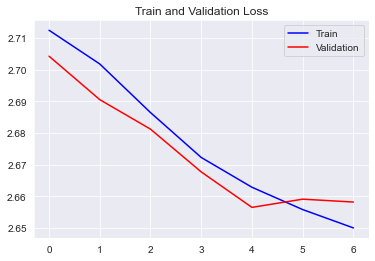

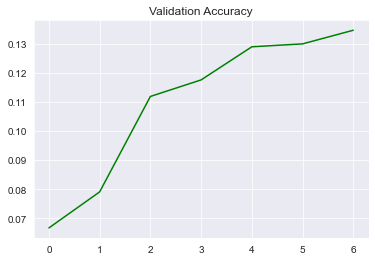

 90%|█████████ | 18/20 [2:52:51<18:16, 548.31s/trial, best loss: 1.87769198184428]

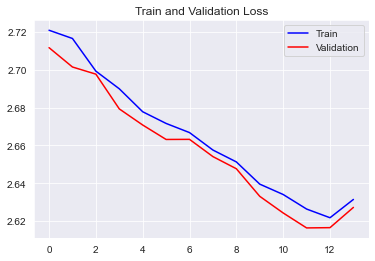

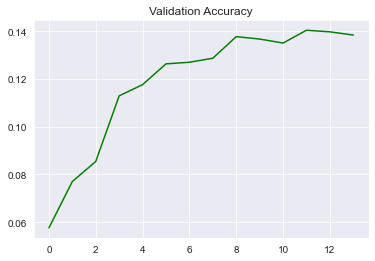

 95%|█████████▌| 19/20 [3:03:41<09:38, 578.85s/trial, best loss: 1.87769198184428]

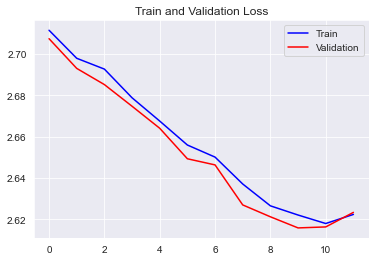

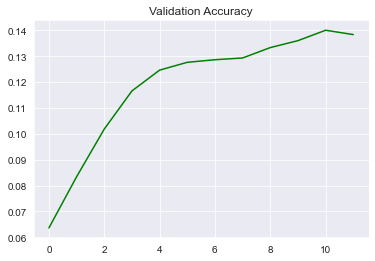

100%|██████████| 20/20 [3:11:59<00:00, 575.98s/trial, best loss: 1.87769198184428]
Best parameter set: (0.005788164516006328, 13), with loss 1.87769198184428
Hyperopt took 11519.675323009491 seconds


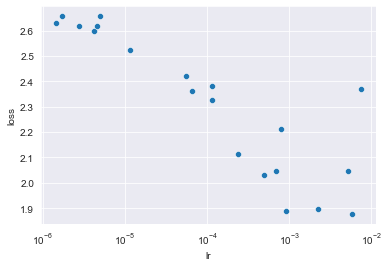

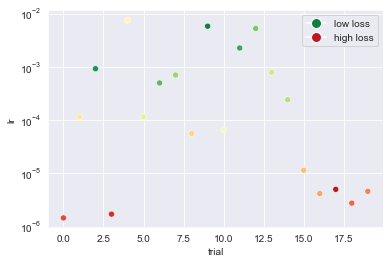

In [28]:
# Actual scene classification task
modify_classification_head(best_pert_model, num_classes=NUM_CLASSES)

# make all layers of classifier trainable
make_trainable(best_pert_model, train_features=False, train_classifier=True)

train_config = TrainConfig(num_epochs=32)

best, trials = train_hyperopt(best_pert_model, train_config, descr="clf-pert-pretext")

results = HYPEROPT_MODEL_PARAMS["all_results"]
plot_paramsearch(results)


100%|██████████| 94/94 [00:09<00:00, 10.17it/s]


Saved log info to outputs\clf-pert-pretext-optimized-final_20230824_191530/log.pickle
Epoch 0 finished. Train loss: 2.4275052940591855, Val loss: 2.4435789234497967, Val accuracy: 0.18425460636515914


100%|██████████| 94/94 [00:08<00:00, 10.66it/s]


Saved log info to outputs\clf-pert-pretext-optimized-final_20230824_191530/log.pickle
Epoch 1 finished. Train loss: 2.3806582537103207, Val loss: 2.3924679137806204, Val accuracy: 0.2150753768844221


100%|██████████| 94/94 [00:10<00:00,  9.36it/s]


Saved log info to outputs\clf-pert-pretext-optimized-final_20230824_191530/log.pickle
Epoch 2 finished. Train loss: 2.325414478778839, Val loss: 2.3233919640913365, Val accuracy: 0.2552763819095477


100%|██████████| 94/94 [00:11<00:00,  8.14it/s]


Saved log info to outputs\clf-pert-pretext-optimized-final_20230824_191530/log.pickle
Epoch 3 finished. Train loss: 2.1998077263223363, Val loss: 2.2158875331521672, Val accuracy: 0.2901172529313233


100%|██████████| 94/94 [00:08<00:00, 11.25it/s]


Saved log info to outputs\clf-pert-pretext-optimized-final_20230824_191530/log.pickle
Epoch 4 finished. Train loss: 2.2121282321341496, Val loss: 2.2419741740201244, Val accuracy: 0.29346733668341707


100%|██████████| 94/94 [00:10<00:00,  9.17it/s]


Saved log info to outputs\clf-pert-pretext-optimized-final_20230824_191530/log.pickle
Epoch 5 finished. Train loss: 2.139285159871933, Val loss: 2.1651765611719958, Val accuracy: 0.3249581239530988


100%|██████████| 94/94 [00:09<00:00, 10.06it/s]


Saved log info to outputs\clf-pert-pretext-optimized-final_20230824_191530/log.pickle
Epoch 6 finished. Train loss: 2.12782152028794, Val loss: 2.147487326739306, Val accuracy: 0.32294807370184253


100%|██████████| 94/94 [00:09<00:00,  9.70it/s]


Saved log info to outputs\clf-pert-pretext-optimized-final_20230824_191530/log.pickle
Epoch 7 finished. Train loss: 2.099639673182305, Val loss: 2.131400546288108, Val accuracy: 0.3407035175879397


100%|██████████| 94/94 [00:09<00:00,  9.74it/s]


Saved log info to outputs\clf-pert-pretext-optimized-final_20230824_191530/log.pickle
Epoch 8 finished. Train loss: 2.0189321611789945, Val loss: 2.059356591918252, Val accuracy: 0.35175879396984927


100%|██████████| 94/94 [00:10<00:00,  9.14it/s]


Saved log info to outputs\clf-pert-pretext-optimized-final_20230824_191530/log.pickle
Epoch 9 finished. Train loss: 2.0063231004045363, Val loss: 2.0641088364596034, Val accuracy: 0.3303182579564489


100%|██████████| 94/94 [00:09<00:00,  9.63it/s]


Saved log info to outputs\clf-pert-pretext-optimized-final_20230824_191530/log.pickle
Epoch 10 finished. Train loss: 2.020002389207799, Val loss: 2.076681738868754, Val accuracy: 0.32931323283082076


100%|██████████| 94/94 [00:09<00:00, 10.19it/s]


Saved log info to outputs\clf-pert-pretext-optimized-final_20230824_191530/log.pickle
Epoch 11 finished. Train loss: 2.002763848355476, Val loss: 2.0752814090188174, Val accuracy: 0.32897822445561137


100%|██████████| 94/94 [00:11<00:00,  8.48it/s]


Saved log info to outputs\clf-pert-pretext-optimized-final_20230824_191530/log.pickle
Epoch 12 finished. Train loss: 1.9262644039823653, Val loss: 1.9778566226602239, Val accuracy: 0.3842546063651591


100%|██████████| 94/94 [00:09<00:00, 10.06it/s]


Saved log info to outputs\clf-pert-pretext-optimized-final_20230824_191530/log.pickle
Epoch 13 finished. Train loss: 1.9235090182182637, Val loss: 1.9915819678077087, Val accuracy: 0.37219430485762145


100%|██████████| 94/94 [00:09<00:00,  9.50it/s]


Saved log info to outputs\clf-pert-pretext-optimized-final_20230824_191530/log.pickle
Epoch 14 finished. Train loss: 1.906507120487538, Val loss: 1.9563600513386854, Val accuracy: 0.38927973199329985


100%|██████████| 94/94 [00:09<00:00,  9.88it/s]


Saved log info to outputs\clf-pert-pretext-optimized-final_20230824_191530/log.pickle
Epoch 15 finished. Train loss: 1.8914787059134626, Val loss: 1.9573388807276353, Val accuracy: 0.3842546063651591


100%|██████████| 94/94 [00:09<00:00, 10.15it/s]


Saved log info to outputs\clf-pert-pretext-optimized-final_20230824_191530/log.pickle
Epoch 16 finished. Train loss: 1.9047218573854325, Val loss: 1.9811325372859119, Val accuracy: 0.40100502512562813


100%|██████████| 94/94 [00:08<00:00, 11.75it/s]


Saved log info to outputs\clf-pert-pretext-optimized-final_20230824_191530/log.pickle
Epoch 17 finished. Train loss: 1.8630138141043642, Val loss: 1.9056222789427812, Val accuracy: 0.3855946398659966


100%|██████████| 94/94 [00:11<00:00,  8.01it/s]


Saved log info to outputs\clf-pert-pretext-optimized-final_20230824_191530/log.pickle
Epoch 18 finished. Train loss: 1.9371253175938383, Val loss: 2.0311104722201505, Val accuracy: 0.32026800670016753


100%|██████████| 94/94 [00:11<00:00,  8.16it/s]


Saved log info to outputs\clf-pert-pretext-optimized-final_20230824_191530/log.pickle
Epoch 19 finished. Train loss: 1.8081544231861195, Val loss: 1.9010178456331956, Val accuracy: 0.38994974874371857


100%|██████████| 94/94 [00:10<00:00,  9.15it/s]


Saved log info to outputs\clf-pert-pretext-optimized-final_20230824_191530/log.pickle
Epoch 20 finished. Train loss: 1.8567001046018397, Val loss: 1.9015215393056206, Val accuracy: 0.41675041876046903


100%|██████████| 94/94 [00:10<00:00,  9.15it/s]


Saved log info to outputs\clf-pert-pretext-optimized-final_20230824_191530/log.pickle
Epoch 21 finished. Train loss: 1.8112490265927417, Val loss: 1.8762699448488613, Val accuracy: 0.4


100%|██████████| 94/94 [00:10<00:00,  8.88it/s]


Saved log info to outputs\clf-pert-pretext-optimized-final_20230824_191530/log.pickle
Epoch 22 finished. Train loss: 1.752113200248556, Val loss: 1.8432532109041264, Val accuracy: 0.4154103852596315


100%|██████████| 94/94 [00:10<00:00,  8.65it/s]


Saved log info to outputs\clf-pert-pretext-optimized-final_20230824_191530/log.pickle
Epoch 23 finished. Train loss: 1.8215994543217597, Val loss: 1.9176579586324844, Val accuracy: 0.3829145728643216


100%|██████████| 94/94 [00:09<00:00,  9.47it/s]


Saved log info to outputs\clf-pert-pretext-optimized-final_20230824_191530/log.pickle
Epoch 24 finished. Train loss: 1.762267885055948, Val loss: 1.8516140545115751, Val accuracy: 0.4134003350083752


100%|██████████| 94/94 [00:09<00:00,  9.49it/s]


Saved log info to outputs\clf-pert-pretext-optimized-final_20230824_191530/log.pickle
Epoch 25 finished. Train loss: 1.7659339308738708, Val loss: 1.8320398604806094, Val accuracy: 0.41708542713567837


100%|██████████| 94/94 [00:08<00:00, 10.60it/s]


Saved log info to outputs\clf-pert-pretext-optimized-final_20230824_191530/log.pickle
Epoch 26 finished. Train loss: 1.76899028838949, Val loss: 1.8421575194374125, Val accuracy: 0.4304857621440536


100%|██████████| 94/94 [00:10<00:00,  8.69it/s]


Saved log info to outputs\clf-pert-pretext-optimized-final_20230824_191530/log.pickle
Epoch 27 finished. Train loss: 1.7412182435076287, Val loss: 1.8220839831918318, Val accuracy: 0.4150753768844221


100%|██████████| 94/94 [00:08<00:00, 10.48it/s]


Saved log info to outputs\clf-pert-pretext-optimized-final_20230824_191530/log.pickle
Epoch 28 finished. Train loss: 1.7123098348049408, Val loss: 1.7753329691402415, Val accuracy: 0.423785594639866


100%|██████████| 94/94 [00:10<00:00,  8.66it/s]


Saved log info to outputs\clf-pert-pretext-optimized-final_20230824_191530/log.pickle
Epoch 29 finished. Train loss: 1.6827060288571296, Val loss: 1.789094507375503, Val accuracy: 0.42646566164154104


100%|██████████| 94/94 [00:08<00:00, 10.60it/s]


Saved log info to outputs\clf-pert-pretext-optimized-final_20230824_191530/log.pickle
Epoch 30 finished. Train loss: 1.755913904372682, Val loss: 1.8025917114421008, Val accuracy: 0.4355108877721943


100%|██████████| 94/94 [00:10<00:00,  9.25it/s]


Saved log info to outputs\clf-pert-pretext-optimized-final_20230824_191530/log.pickle
Epoch 31 finished. Train loss: 1.7143324613571167, Val loss: 1.8190698413287891, Val accuracy: 0.4318257956448911
Saved log info to outputs\clf-pert-pretext-optimized-final_20230824_191530/log.pickle


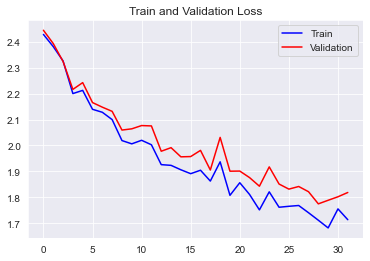

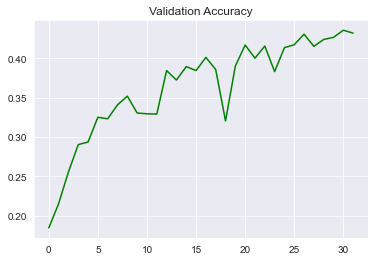

Epoch: 	Train loss / 	Validation loss ; 	Train accuracy / 	Validation accuracy
++++ 0: 	2.4275 / 	2.4436 ; 	0.1767 / 	0.1843
++++ 1: 	2.3807 / 	2.3925 ; 	0.2040 / 	0.2151
++++ 2: 	2.3254 / 	2.3234 ; 	0.2420 / 	0.2553
++++ 3: 	2.1998 / 	2.2159 ; 	0.2893 / 	0.2901
---+ 4: 	2.2121 / 	2.2420 ; 	0.2813 / 	0.2935
++++ 5: 	2.1393 / 	2.1652 ; 	0.3213 / 	0.3250
+++- 6: 	2.1278 / 	2.1475 ; 	0.3440 / 	0.3229
++++ 7: 	2.0996 / 	2.1314 ; 	0.3547 / 	0.3407
++++ 8: 	2.0189 / 	2.0594 ; 	0.3573 / 	0.3518
+-+- 9: 	2.0063 / 	2.0641 ; 	0.3627 / 	0.3303
---- 10: 	2.0200 / 	2.0767 ; 	0.3540 / 	0.3293
+++- 11: 	2.0028 / 	2.0753 ; 	0.3560 / 	0.3290
++++ 12: 	1.9263 / 	1.9779 ; 	0.4127 / 	0.3843
+--- 13: 	1.9235 / 	1.9916 ; 	0.4100 / 	0.3722
++++ 14: 	1.9065 / 	1.9564 ; 	0.4233 / 	0.3893
+-+- 15: 	1.8915 / 	1.9573 ; 	0.4440 / 	0.3843
---+ 16: 	1.9047 / 	1.9811 ; 	0.4380 / 	0.4010
++-- 17: 	1.8630 / 	1.9056 ; 	0.4173 / 	0.3856
---- 18: 	1.9371 / 	2.0311 ; 	0.3727 / 	0.3203
++++ 19: 	1.8082 / 	1.9010 ; 	0.4380 /

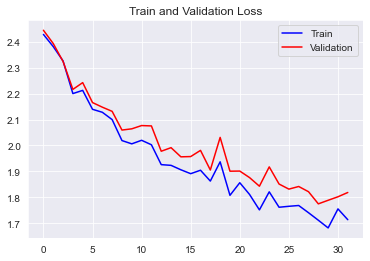

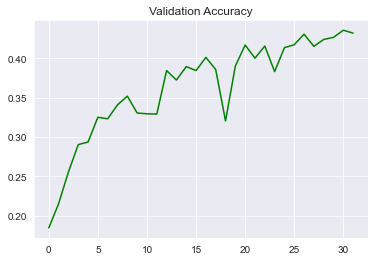

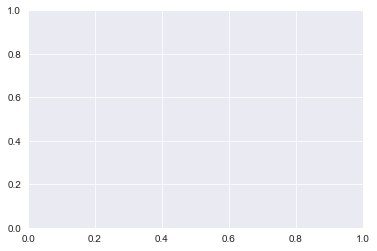

In [32]:
best_pert_model = load_model("outputs/optimized runs/pert-only-optimized_20230823_034435/model_epoch_6.pt", num_classes=2, evaluation_mode=False)
modify_classification_head(best_pert_model, num_classes=NUM_CLASSES)
make_trainable(best_pert_model, train_features=False, train_classifier=True)
train_config = TrainConfig(lr=0.0009213880776154422, batch_size=16, num_epochs=32)


best_rot_only_model, train_log = train_on_custom_batch_size(best_pert_model, train_config,
                                      log_descr="clf-pert-pretext-optimized-final", pretext_task=None)

train_log.analysis()

Starting hyperparameter search at 2023-08-24 11:21:48
  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]

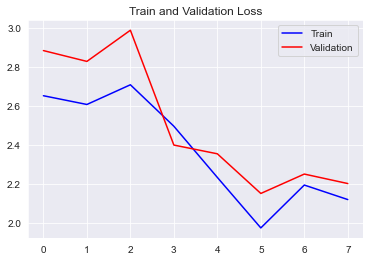

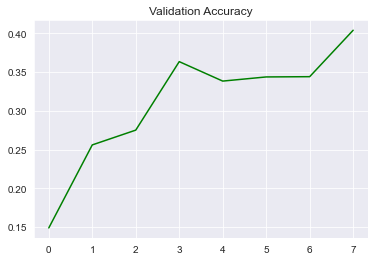

New best parameter set: (0.0067113471264678105, 12), with loss 2.1517218040175226, accuracy 0.4040201005025126
  5%|▌         | 1/20 [05:05<1:36:42, 305.41s/trial, best loss: 2.1517218040175226]

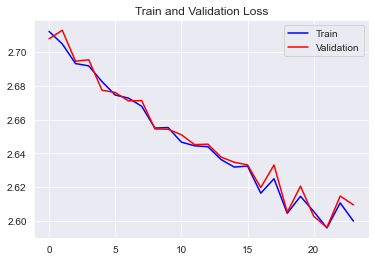

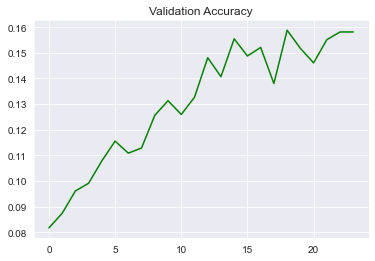

 10%|█         | 2/20 [20:51<3:24:36, 682.03s/trial, best loss: 2.1517218040175226]

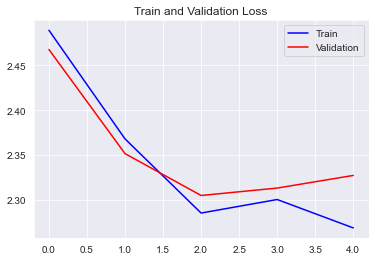

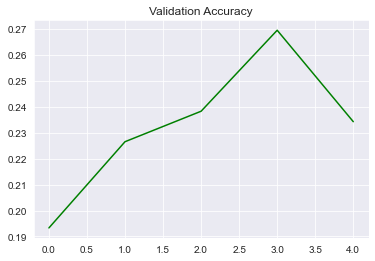

 15%|█▌        | 3/20 [24:08<2:10:34, 460.87s/trial, best loss: 2.1517218040175226]

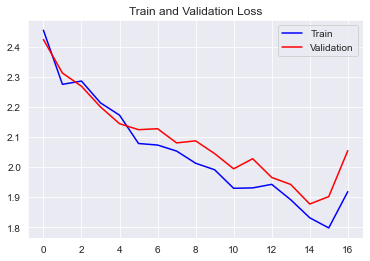

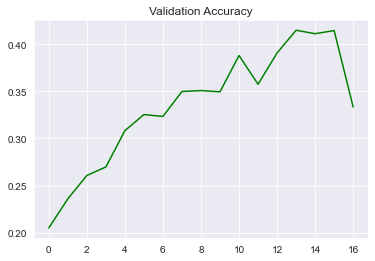

New best parameter set: (0.001342064146572845, 13), with loss 1.8771299253339353, accuracy 0.41474036850921275
 20%|██        | 4/20 [35:16<2:24:38, 542.43s/trial, best loss: 1.8771299253339353]

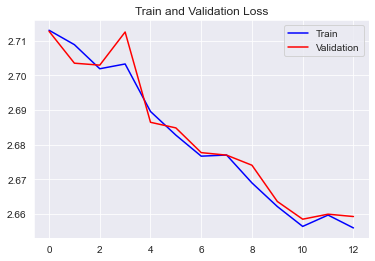

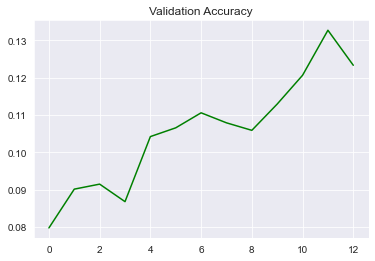

 25%|██▌       | 5/20 [44:10<2:14:49, 539.32s/trial, best loss: 1.8771299253339353]

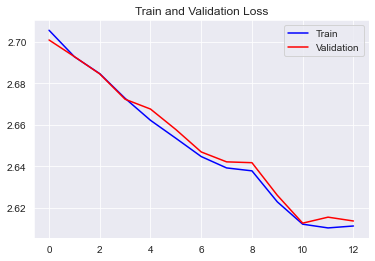

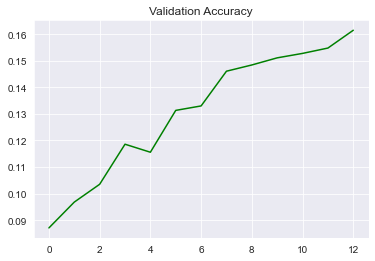

 30%|███       | 6/20 [52:43<2:03:48, 530.62s/trial, best loss: 1.8771299253339353]

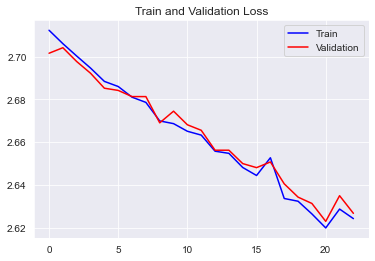

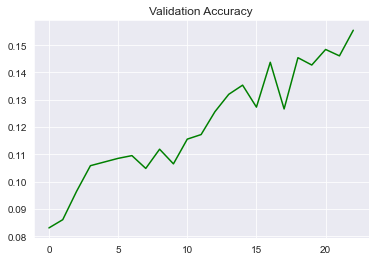

 35%|███▌      | 7/20 [1:08:54<2:26:10, 674.63s/trial, best loss: 1.8771299253339353]

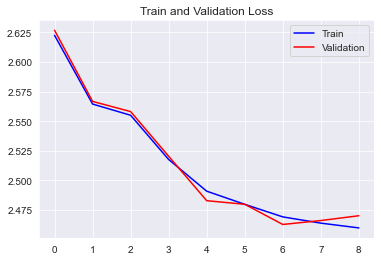

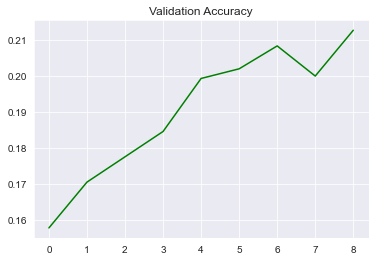

 40%|████      | 8/20 [1:15:08<1:55:46, 578.87s/trial, best loss: 1.8771299253339353]

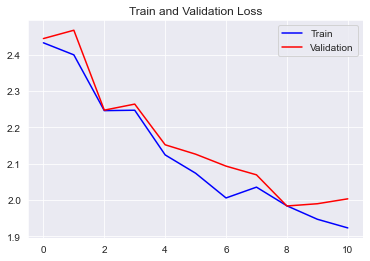

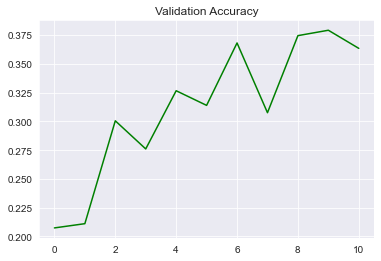

 45%|████▌     | 9/20 [1:22:09<1:37:05, 529.59s/trial, best loss: 1.8771299253339353]

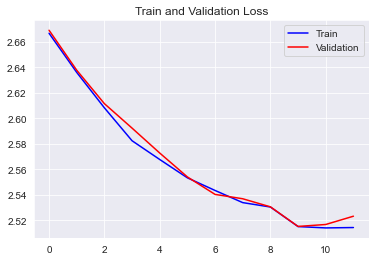

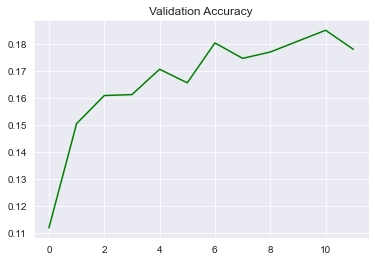

 50%|█████     | 10/20 [1:30:54<1:28:00, 528.05s/trial, best loss: 1.8771299253339353]

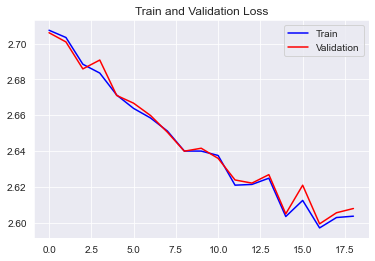

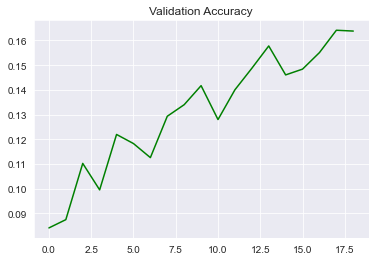

 55%|█████▌    | 11/20 [1:44:15<1:31:43, 611.48s/trial, best loss: 1.8771299253339353]

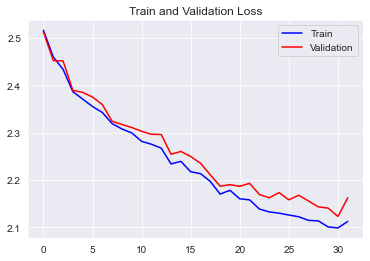

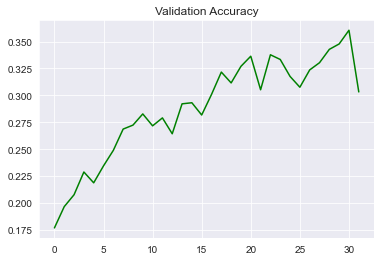

 60%|██████    | 12/20 [2:05:45<1:49:04, 818.12s/trial, best loss: 1.8771299253339353]

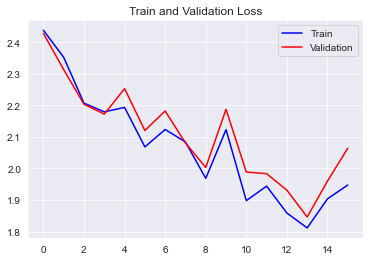

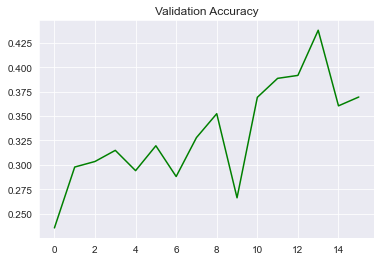

New best parameter set: (0.0012396123140148859, 14), with loss 1.8461427287520649, accuracy 0.43785594639866
 65%|██████▌   | 13/20 [2:16:54<1:30:08, 772.71s/trial, best loss: 1.8461427287520649]

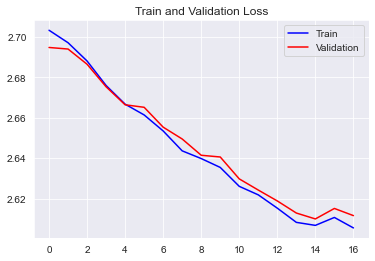

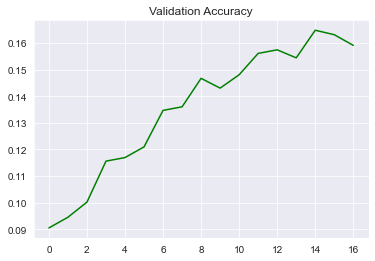

 70%|███████   | 14/20 [2:28:41<1:15:17, 752.88s/trial, best loss: 1.8461427287520649]

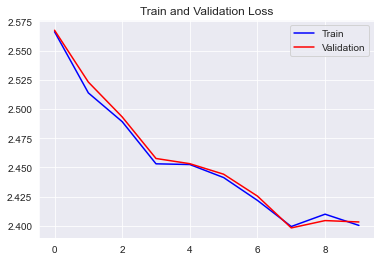

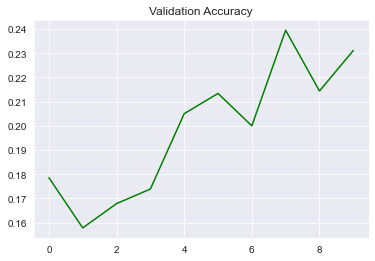

 75%|███████▌  | 15/20 [2:36:03<54:55, 659.13s/trial, best loss: 1.8461427287520649]  

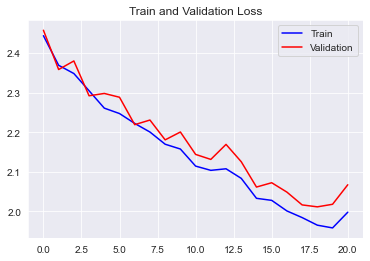

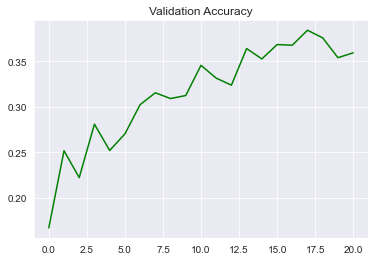

 80%|████████  | 16/20 [2:50:09<47:42, 715.55s/trial, best loss: 1.8461427287520649]

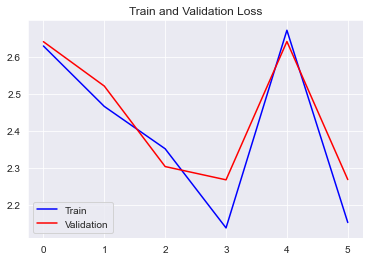

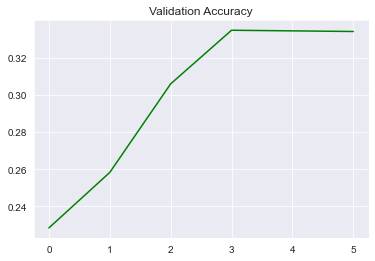

 85%|████████▌ | 17/20 [2:54:08<28:36, 572.31s/trial, best loss: 1.8461427287520649]

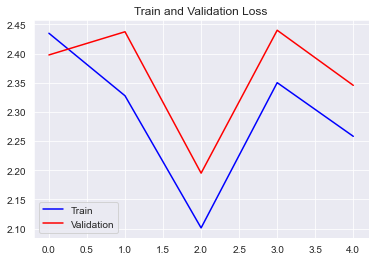

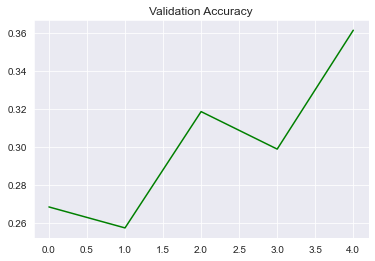

 90%|█████████ | 18/20 [2:57:33<15:23, 461.92s/trial, best loss: 1.8461427287520649]

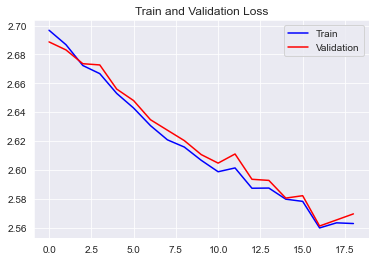

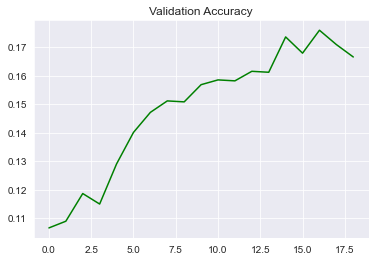

 95%|█████████▌| 19/20 [3:10:07<09:09, 549.59s/trial, best loss: 1.8461427287520649]

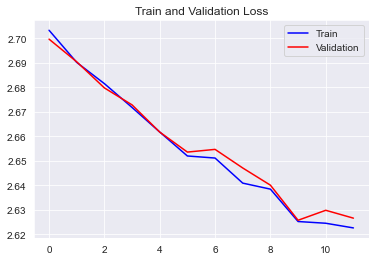

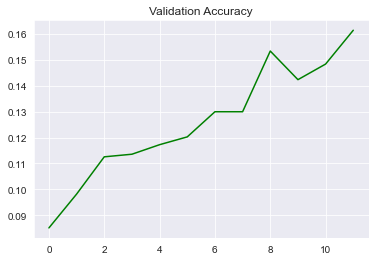

100%|██████████| 20/20 [3:18:08<00:00, 594.45s/trial, best loss: 1.8461427287520649]
Best parameter set: (0.0012396123140148859, 14), with loss 1.8461427287520649
Hyperopt took 11888.927452087402 seconds


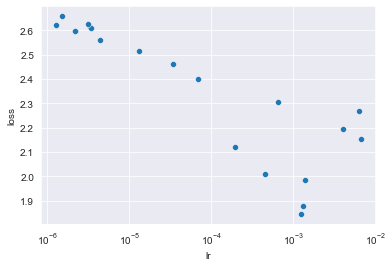

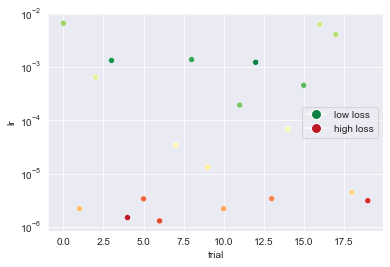

In [29]:
best_pert_model = load_model("outputs/optimized runs/pert-only-optimized_20230823_034435/model_epoch_4.pt",
                             num_classes=2, evaluation_mode=False)
# Actual scene classification task
modify_classification_head(best_pert_model, num_classes=NUM_CLASSES)

# make all layers of classifier trainable
make_trainable(best_pert_model, train_features=False, train_classifier=True)

train_config = TrainConfig(num_epochs=32)

best, trials = train_hyperopt(best_pert_model, train_config, descr="clf-pert-pretext")

results = HYPEROPT_MODEL_PARAMS["all_results"]
plot_paramsearch(results)


Starting hyperparameter search at 2023-08-24 15:37:34
  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]

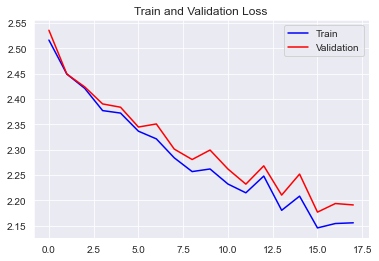

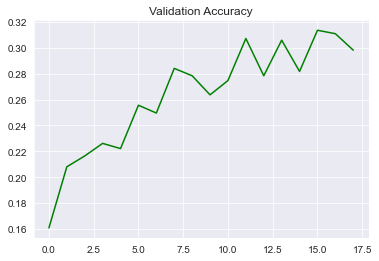

New best parameter set: (0.0002814593965887227, 16), with loss 2.176926835972995, accuracy 0.3135678391959799
  5%|▌         | 1/20 [10:39<3:22:23, 639.13s/trial, best loss: 2.176926835972995]

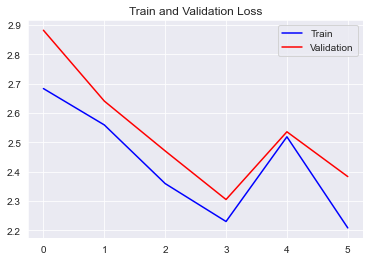

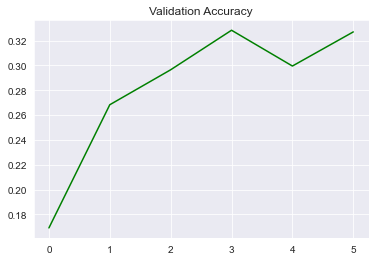

 10%|█         | 2/20 [14:11<1:56:25, 388.08s/trial, best loss: 2.176926835972995]

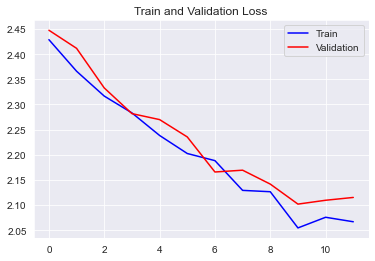

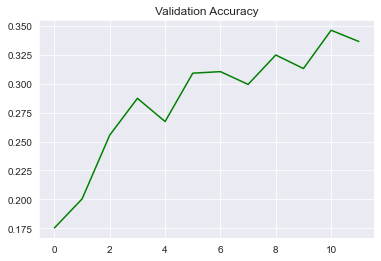

New best parameter set: (0.0007613502441725021, 15), with loss 2.1018779763025255, accuracy 0.34639865996649916
 15%|█▌        | 3/20 [21:29<1:56:24, 410.86s/trial, best loss: 2.1018779763025255]

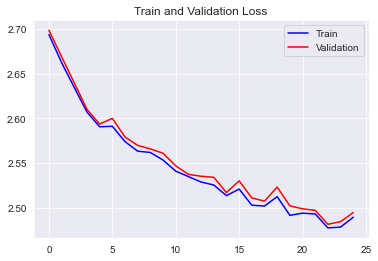

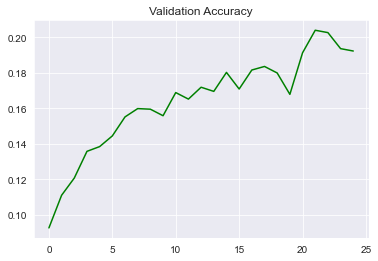

 20%|██        | 4/20 [36:35<2:41:39, 606.21s/trial, best loss: 2.1018779763025255]

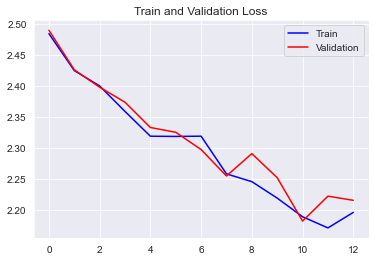

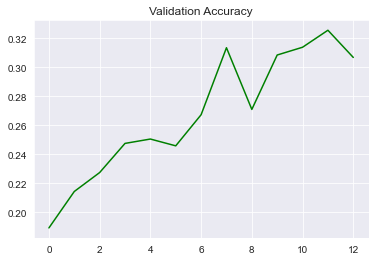

 25%|██▌       | 5/20 [45:00<2:22:25, 569.71s/trial, best loss: 2.1018779763025255]

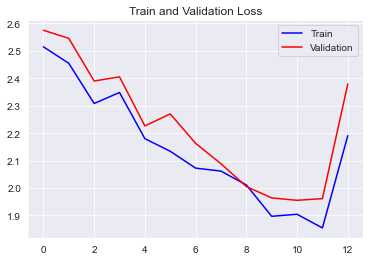

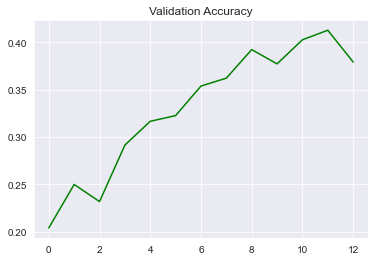

New best parameter set: (0.0023954877919944747, 10), with loss 1.9552624716009184, accuracy 0.4127303182579565
 30%|███       | 6/20 [53:09<2:06:32, 542.30s/trial, best loss: 1.9552624716009184]

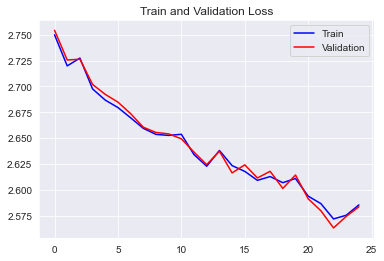

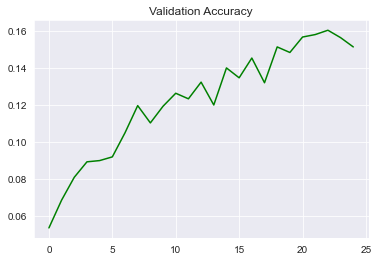

 35%|███▌      | 7/20 [1:09:34<2:28:52, 687.08s/trial, best loss: 1.9552624716009184]

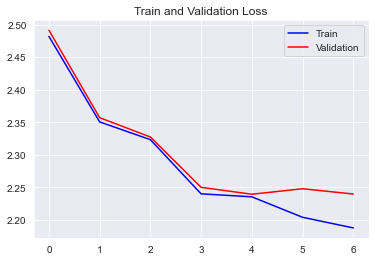

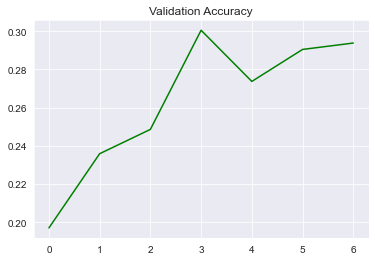

 40%|████      | 8/20 [1:13:59<1:50:33, 552.76s/trial, best loss: 1.9552624716009184]

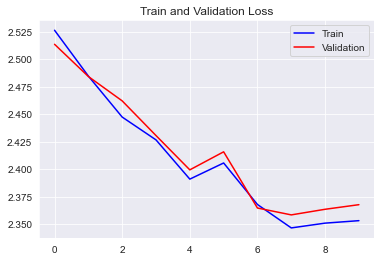

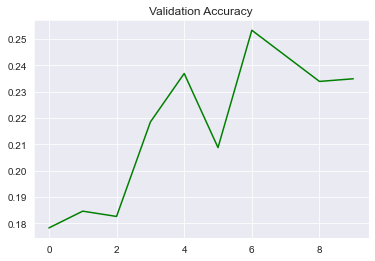

 45%|████▌     | 9/20 [1:19:53<1:29:56, 490.56s/trial, best loss: 1.9552624716009184]

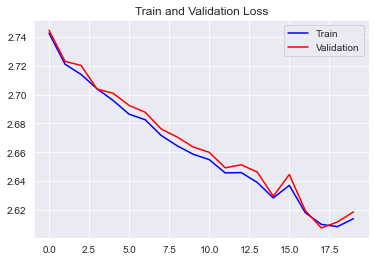

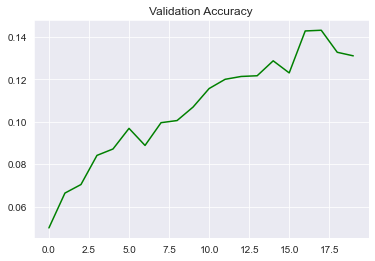

 50%|█████     | 10/20 [1:32:31<1:35:31, 573.18s/trial, best loss: 1.9552624716009184]

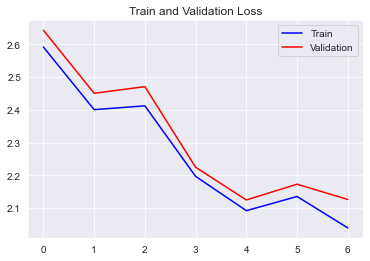

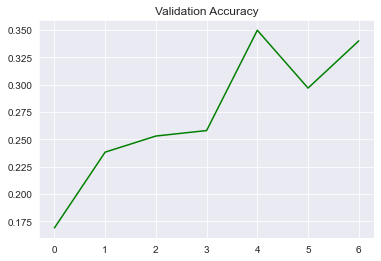

 55%|█████▌    | 11/20 [1:37:33<1:13:33, 490.34s/trial, best loss: 1.9552624716009184]

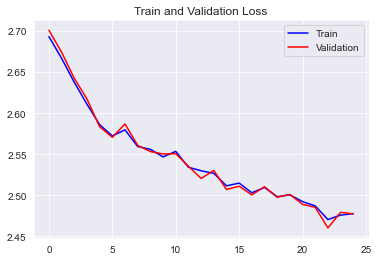

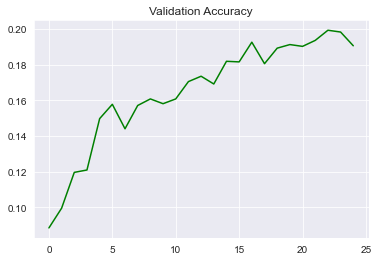

 60%|██████    | 12/20 [1:56:17<1:31:03, 682.99s/trial, best loss: 1.9552624716009184]

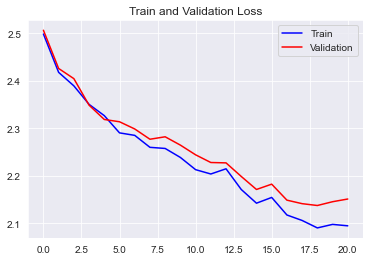

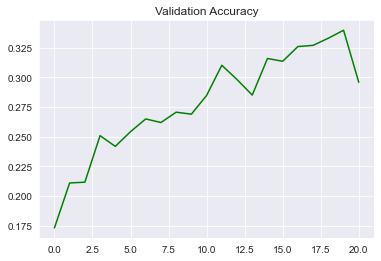

 65%|██████▌   | 13/20 [2:09:59<1:24:35, 725.12s/trial, best loss: 1.9552624716009184]

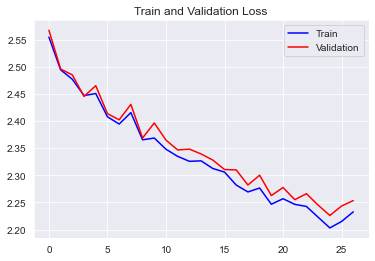

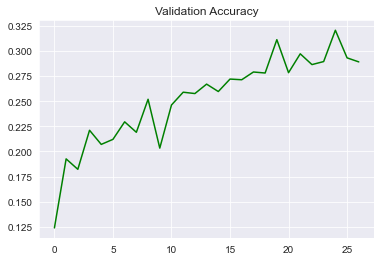

 70%|███████   | 14/20 [2:28:40<1:24:28, 844.77s/trial, best loss: 1.9552624716009184]

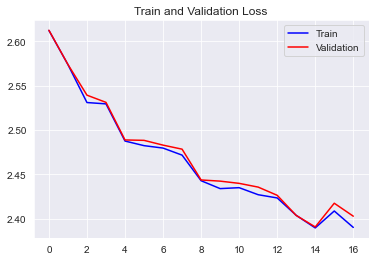

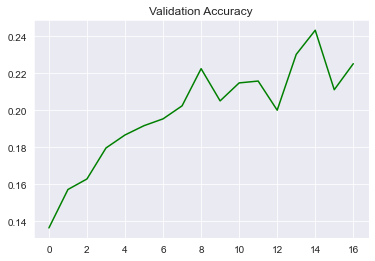

 75%|███████▌  | 15/20 [2:40:28<1:06:57, 803.43s/trial, best loss: 1.9552624716009184]

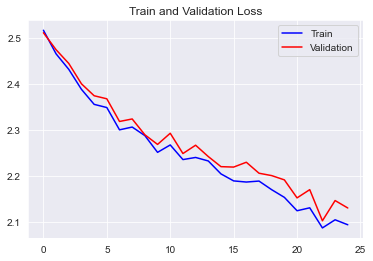

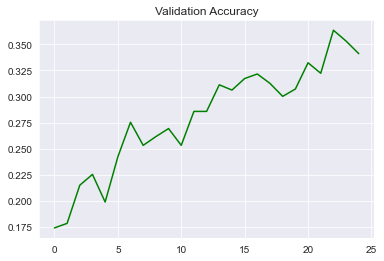

 80%|████████  | 16/20 [2:57:45<58:15, 873.79s/trial, best loss: 1.9552624716009184]  

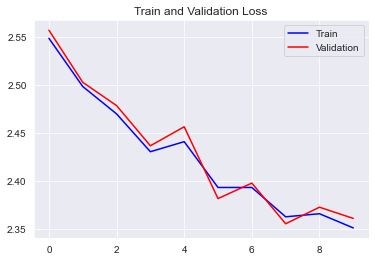

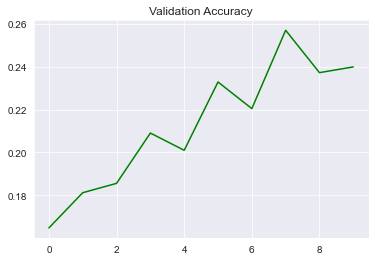

 85%|████████▌ | 17/20 [3:04:26<36:34, 731.66s/trial, best loss: 1.9552624716009184]

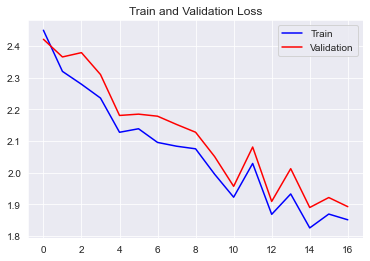

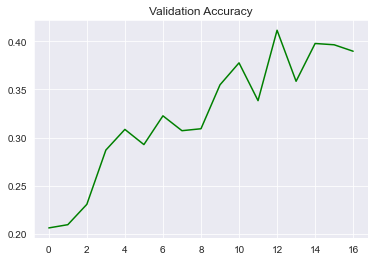

New best parameter set: (0.0014763858414479523, 14), with loss 1.8901155602152102, accuracy 0.4113902847571189
 90%|█████████ | 18/20 [3:15:29<23:42, 711.05s/trial, best loss: 1.8901155602152102]

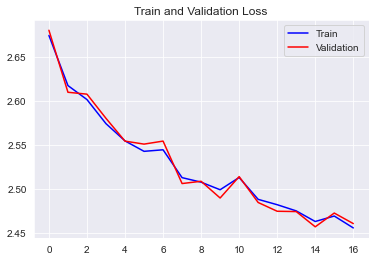

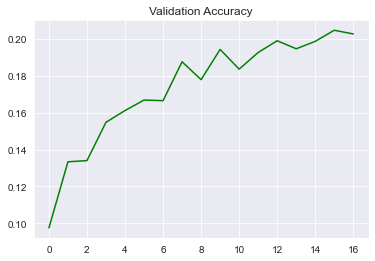

 95%|█████████▌| 19/20 [3:27:20<11:50, 710.84s/trial, best loss: 1.8901155602152102]

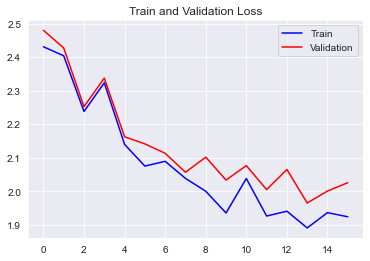

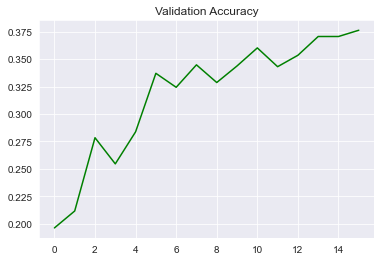

100%|██████████| 20/20 [3:37:53<00:00, 653.67s/trial, best loss: 1.8901155602152102]
Best parameter set: (0.0014763858414479523, 14), with loss 1.8901155602152102
Hyperopt took 13073.499003887177 seconds


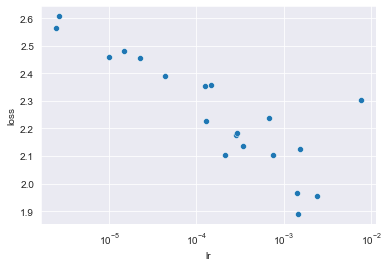

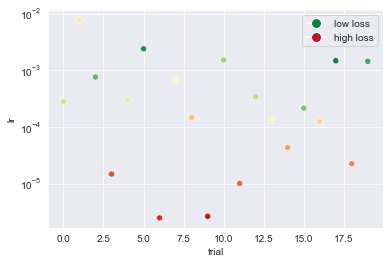

In [30]:
best_pert_model = load_model("outputs/optimized runs/pert-only-optimized_20230823_034435/model_epoch_1.pt",
                             num_classes=2, evaluation_mode=False)
# TORUN
# Actual scene classification task
modify_classification_head(best_pert_model, num_classes=NUM_CLASSES)

# make all layers of classifier trainable
make_trainable(best_pert_model, train_features=False, train_classifier=True)

train_config = TrainConfig(num_epochs=32)

best, trials = train_hyperopt(best_pert_model, train_config, descr="clf-pert-pretext")

results = HYPEROPT_MODEL_PARAMS["all_results"]
plot_paramsearch(results)


100%|██████████| 100/100 [00:18<00:00,  5.50it/s]


Saved log info to outputs\pretext_only_perturbation_lr10-5_bs15_ep10_20230824_225325/log.pickle
Epoch 0 finished. Train loss: 0.6151980763673782, Val loss: 0.6154307471447854, Val accuracy: 0.7370184254606366


100%|██████████| 100/100 [00:13<00:00,  7.61it/s]


Saved log info to outputs\pretext_only_perturbation_lr10-5_bs15_ep10_20230824_225325/log.pickle
Epoch 1 finished. Train loss: 0.433785060942173, Val loss: 0.44142599336466, Val accuracy: 0.9520938023450586


100%|██████████| 100/100 [00:18<00:00,  5.48it/s]


Saved log info to outputs\pretext_only_perturbation_lr10-5_bs15_ep10_20230824_225325/log.pickle
Epoch 2 finished. Train loss: 0.2369272367656231, Val loss: 0.24146988942994543, Val accuracy: 0.9922948073701843


100%|██████████| 100/100 [00:13<00:00,  7.41it/s]


Saved log info to outputs\pretext_only_perturbation_lr10-5_bs15_ep10_20230824_225325/log.pickle
Epoch 3 finished. Train loss: 0.11210758373141289, Val loss: 0.11608673692049093, Val accuracy: 0.9989949748743718


100%|██████████| 100/100 [00:21<00:00,  4.63it/s]


Saved log info to outputs\pretext_only_perturbation_lr10-5_bs15_ep10_20230824_225325/log.pickle
Epoch 4 finished. Train loss: 0.06114304590970278, Val loss: 0.06034194187602805, Val accuracy: 1.0


100%|██████████| 100/100 [00:19<00:00,  5.19it/s]


Saved log info to outputs\pretext_only_perturbation_lr10-5_bs15_ep10_20230824_225325/log.pickle
Epoch 5 finished. Train loss: 0.031081894934177397, Val loss: 0.0317982072244637, Val accuracy: 0.9996649916247906


100%|██████████| 100/100 [00:16<00:00,  5.90it/s]


Saved log info to outputs\pretext_only_perturbation_lr10-5_bs15_ep10_20230824_225325/log.pickle
Epoch 6 finished. Train loss: 0.021336855795234443, Val loss: 0.02176823229739564, Val accuracy: 1.0


100%|██████████| 100/100 [00:19<00:00,  5.02it/s]


Saved log info to outputs\pretext_only_perturbation_lr10-5_bs15_ep10_20230824_225325/log.pickle
Epoch 7 finished. Train loss: 0.014143586931750178, Val loss: 0.015350033536122822, Val accuracy: 1.0


100%|██████████| 100/100 [00:21<00:00,  4.66it/s]


Saved log info to outputs\pretext_only_perturbation_lr10-5_bs15_ep10_20230824_225325/log.pickle
Epoch 8 finished. Train loss: 0.009403008362278342, Val loss: 0.009845695261792022, Val accuracy: 1.0


100%|██████████| 100/100 [00:15<00:00,  6.26it/s]


Saved log info to outputs\pretext_only_perturbation_lr10-5_bs15_ep10_20230824_225325/log.pickle
Epoch 9 finished. Train loss: 0.006490645604208112, Val loss: 0.007586676016655849, Val accuracy: 1.0
Saved log info to outputs\pretext_only_perturbation_lr10-5_bs15_ep10_20230824_225325/log.pickle


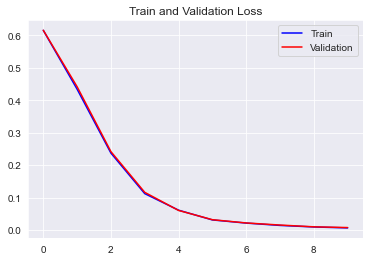

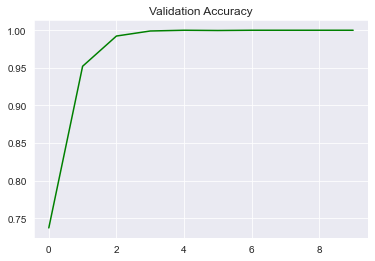

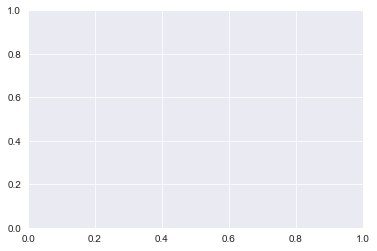

In [26]:
model_efficient_b0 = torchvision.models.efficientnet_b0(weights='IMAGENET1K_V1')

# Pretext Task
modify_classification_head(model_efficient_b0, num_classes=2)

make_trainable(model_efficient_b0, train_features=True, train_classifier=True)

train_config = TrainConfig(lr=0.00001, batch_size=15, num_epochs=10)

pretext_task = PerturbationPretext()

model_efficient_b0, pretext_log = train(model_efficient_b0, train_loader, val_loader, train_config,
                                        pretext_task=pretext_task, log_descr="pretext_only_perturbation_lr10-5_bs15_ep10")

Starting hyperparameter search at 2023-08-24 23:17:35
  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]

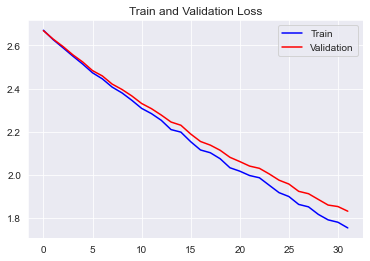

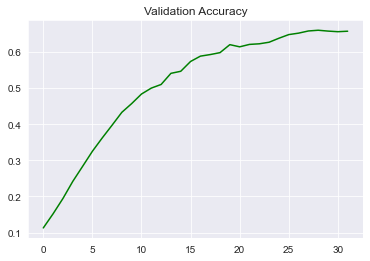

New best parameter set: (1.4746992982287545e-05, 12), with loss 1.831704978483269, accuracy 0.6599664991624791
  5%|▌         | 1/20 [20:38<6:32:13, 1238.61s/trial, best loss: 1.831704978483269]

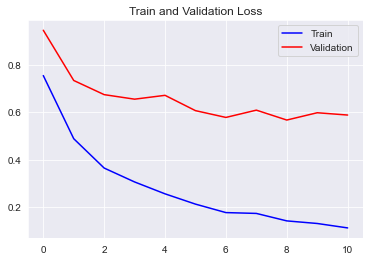

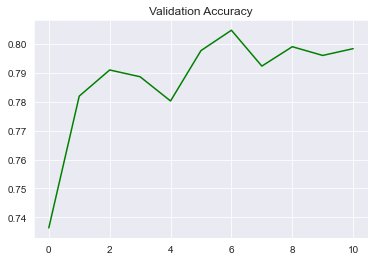

New best parameter set: (0.0021569308542268837, 12), with loss 0.5665691477437336, accuracy 0.8046901172529313
 10%|█         | 2/20 [28:09<3:52:37, 775.44s/trial, best loss: 0.5665691477437336]

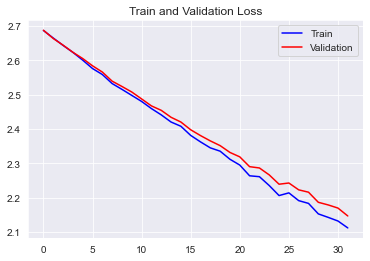

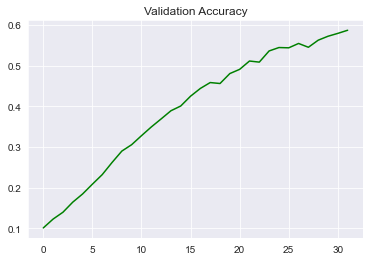

 15%|█▌        | 3/20 [51:47<5:02:48, 1068.74s/trial, best loss: 0.5665691477437336]

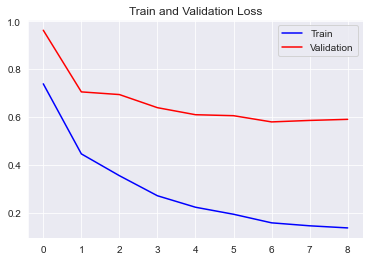

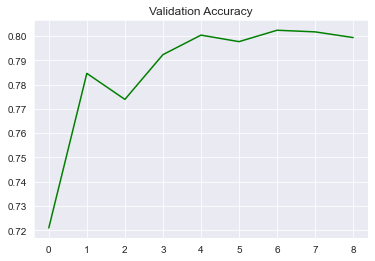

 20%|██        | 4/20 [58:07<3:32:27, 796.73s/trial, best loss: 0.5665691477437336] 

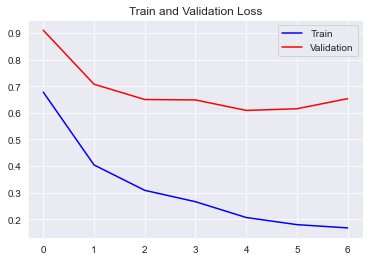

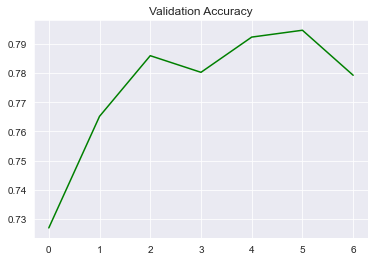

 25%|██▌       | 5/20 [1:03:01<2:33:50, 615.34s/trial, best loss: 0.5665691477437336]

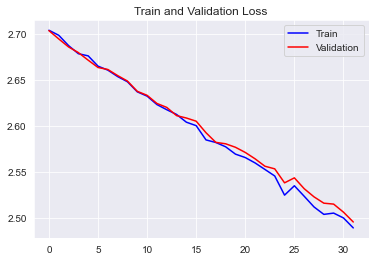

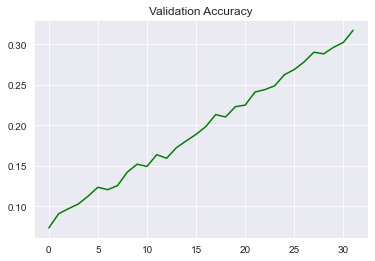

 30%|███       | 6/20 [1:26:43<3:27:36, 889.76s/trial, best loss: 0.5665691477437336]

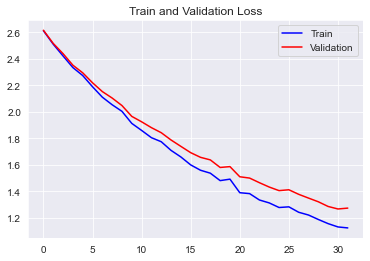

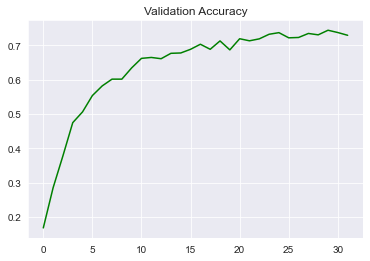

 35%|███▌      | 7/20 [1:49:06<3:44:53, 1037.97s/trial, best loss: 0.5665691477437336]

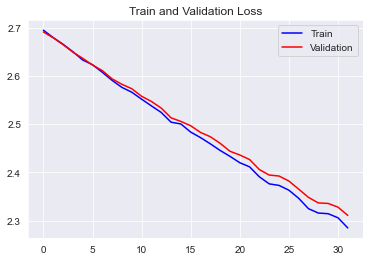

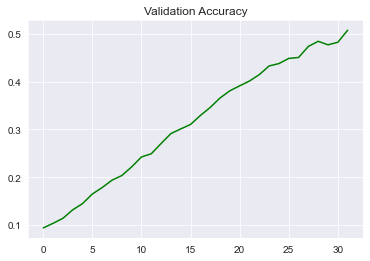

 40%|████      | 8/20 [2:10:39<3:43:49, 1119.10s/trial, best loss: 0.5665691477437336]

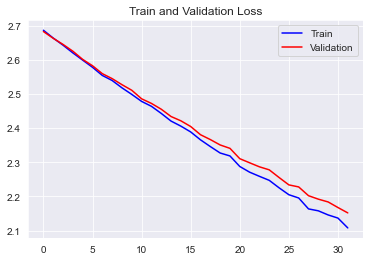

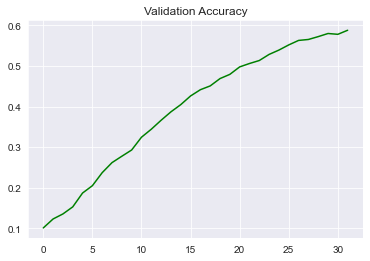

 45%|████▌     | 9/20 [2:34:09<3:41:51, 1210.12s/trial, best loss: 0.5665691477437336]

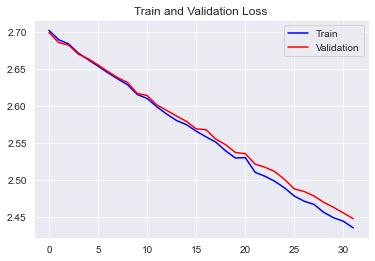

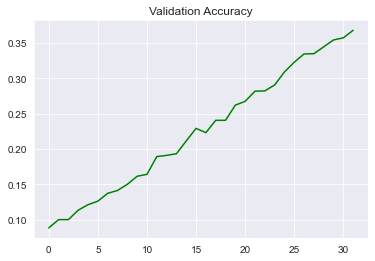

 50%|█████     | 10/20 [2:59:37<3:38:00, 1308.07s/trial, best loss: 0.5665691477437336]

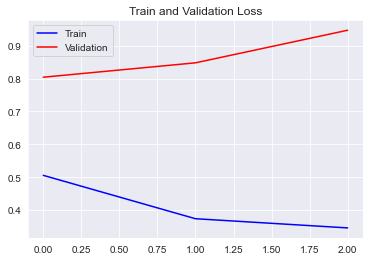

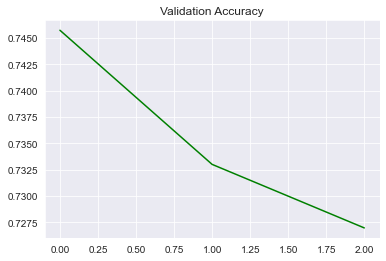

 55%|█████▌    | 11/20 [3:02:28<2:24:02, 960.30s/trial, best loss: 0.5665691477437336] 

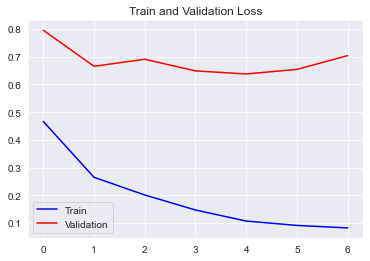

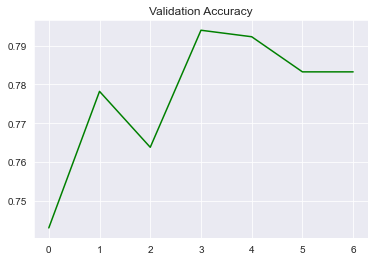

 60%|██████    | 12/20 [3:08:32<1:43:49, 778.66s/trial, best loss: 0.5665691477437336]

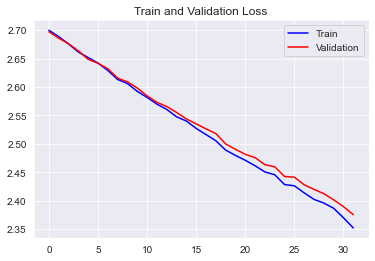

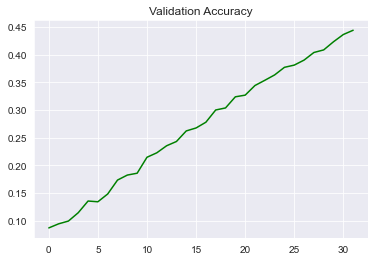

 65%|██████▌   | 13/20 [3:37:12<2:04:06, 1063.85s/trial, best loss: 0.5665691477437336]

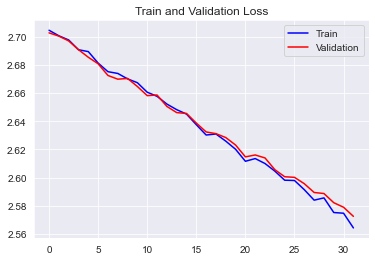

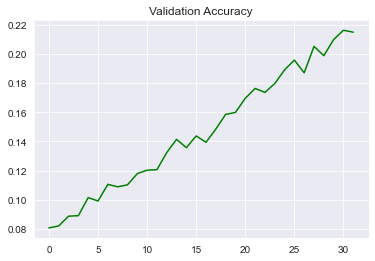

 70%|███████   | 14/20 [4:03:20<2:01:36, 1216.14s/trial, best loss: 0.5665691477437336]

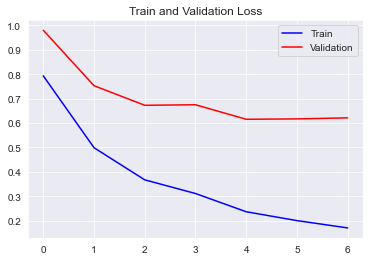

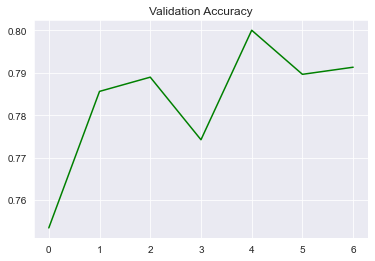

 75%|███████▌  | 15/20 [4:09:38<1:20:18, 963.68s/trial, best loss: 0.5665691477437336] 

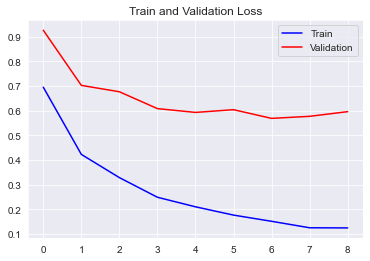

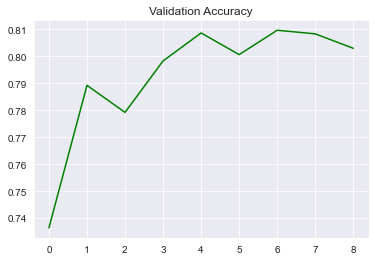

 80%|████████  | 16/20 [4:18:21<55:23, 830.92s/trial, best loss: 0.5665691477437336]  

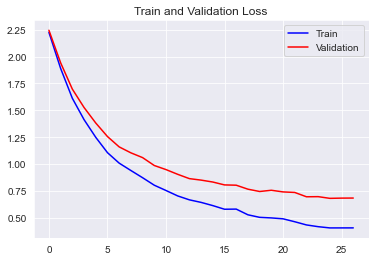

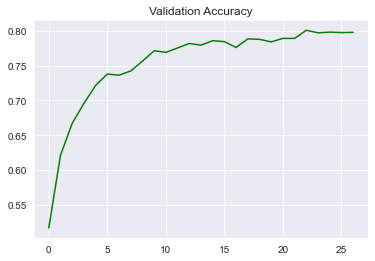

 85%|████████▌ | 17/20 [4:39:49<48:25, 968.34s/trial, best loss: 0.5665691477437336]

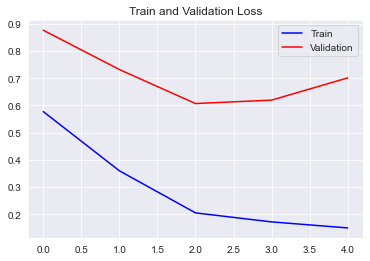

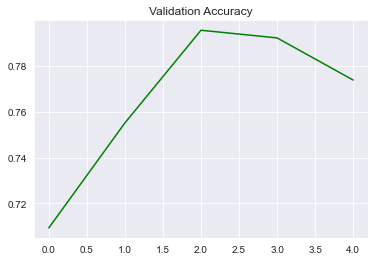

 90%|█████████ | 18/20 [4:43:49<24:59, 749.56s/trial, best loss: 0.5665691477437336]

In [ ]:
best_pert_model = load_model("outputs/optimized runs/pretext_only_perturbation_lr10-5_bs15_ep10_20230824_225325/model_epoch_9.pt",
                             num_classes=2, evaluation_mode=False)
# TORUN
# Actual scene classification task
modify_classification_head(best_pert_model, num_classes=NUM_CLASSES)

# make all layers of classifier trainable
make_trainable(best_pert_model, train_features=False, train_classifier=True)

train_config = TrainConfig(num_epochs=32)

best, trials = train_hyperopt(best_pert_model, train_config, descr="clf-pert-pretext-lr10-5")

results = HYPEROPT_MODEL_PARAMS["all_results"]
plot_paramsearch(results)

In [ ]:
best_pert_model = load_model("outputs/optimized runs/pretext_only_perturbation_lr10-5_bs15_ep10_20230824_225325/model_epoch_9.pt", num_classes=2, evaluation_mode=False)
modify_classification_head(best_pert_model, num_classes=NUM_CLASSES)
make_trainable(best_pert_model, train_features=False, train_classifier=True)
train_config = TrainConfig(lr=, batch_size=, num_epochs=32)
# torun (save model in trainlogger)

best_rot_only_model, train_log = train_on_custom_batch_size(best_pert_model, train_config,
                                      log_descr="clf-pert-pretext-optimized-final", pretext_task=None)

train_log.analysis()

In [ ]:
# torun, same, but lower start epoch
best_pert_model = load_model("outputs/optimized runs/pretext_only_perturbation_lr10-5_bs15_ep10_20230824_225325/model_epoch_2.pt",
                             num_classes=2, evaluation_mode=False)
# TORUN
# Actual scene classification task
modify_classification_head(best_pert_model, num_classes=NUM_CLASSES)

# make all layers of classifier trainable
make_trainable(best_pert_model, train_features=False, train_classifier=True)

train_config = TrainConfig(num_epochs=32)

best, trials = train_hyperopt(best_pert_model, train_config, descr="clf-pert-pretext-lr10-5")

results = HYPEROPT_MODEL_PARAMS["all_results"]
plot_paramsearch(results)

In [ ]:
best_pert_model = load_model("outputs/optimized runs/pretext_only_perturbation_lr10-5_bs15_ep10_20230824_225325/model_epoch_5.pt",
                             num_classes=2, evaluation_mode=False)
# TORUN
# Actual scene classification task
modify_classification_head(best_pert_model, num_classes=NUM_CLASSES)

# make all layers of classifier trainable
make_trainable(best_pert_model, train_features=False, train_classifier=True)

train_config = TrainConfig(num_epochs=32)

best, trials = train_hyperopt(best_pert_model, train_config, descr="clf-pert-pretext-lr10-5")

results = HYPEROPT_MODEL_PARAMS["all_results"]
plot_paramsearch(results)

# Model explanation and interpretation
In this section, you are requested to explain and interpret the models trained following the
fully-supervised and self-supervised procedures.

In [19]:
MODEL_SAVES = {
    "supervised": "outputs/supervised_20230612_181931/model.pt",
    "pretext_rotation": "outputs/pretext_rotation_20230612_191753/model.pt",
    "pretext_perturbation": "outputs/pretext_perturbation_20230612_194842/model.pt"
}


## Explanation

In [77]:
from torchcam.methods import ScoreCAM

def get_explanation(model, image, layer, label=None):
    # image = image.unsqueeze(0)

    cam = ScoreCAM(model)#, target_layer=layer)

    out = model(image)

    label_idx = out.argmax() # todo: out.squeezee(0) or not?

    if label is None:
        label = label_idx

    if not label_idx == label:
        print("Warning: model prediction is not equal to the actual label")

    explanation = cam(out.squeeze(0).argmax().item(), out) # int, out as parameter?

    return explanation


def get_last_conv_layer(sequence):
    # warning: this function doesn't work for nested sequences
    for layer in reversed(sequence):
        if isinstance(layer, torch.nn.Conv2d):
            return layer
    raise Exception("No convolutional layer found")


def explain_predictions(model, images):
    """
    :param model: model to explain (efficientnet modification)
    :param images: images to explain (batch, already as tensor) and labels
    """
    explanations_lower_layer_b1 = []
    explanations_lower_layer_b2 = []
    explanations_higher_layer = []

    # get the last convolutional layer in the EfficientNet-B0
    last_conv_layer = model.classifier[1]

    # get the last convolutional layer in the first and second block of the EfficientNet-B0 architecture
    block0 = model.features[0]
    block1 = model.features[1]
    first_block = block0[0]
    second_block = block1[0].block[2]

    explenations = []

    for image, label in zip(images[0], images[1]):
        # get the explanation for the higher layer
        explanation_higher_layer = get_explanation(model, image, last_conv_layer, label)
        explanations_higher_layer.append(explanation_higher_layer)

        # get the explanation for the lower layer
        explanation_lower_layer_b1 = get_explanation(model, image, first_block, label)
        explanations_lower_layer_b1.append(explanation_lower_layer_b1)

        explanation_lower_layer_b2 = get_explanation(model, image, second_block, label)
        explanations_lower_layer_b2.append(explanation_lower_layer_b2)

        # explanations = [(explanations_lower_layer_b1, "Conv b1"), (explanations_lower_layer_b2, "Conv b2"),
        #                 (explanations_higher_layer, "Last conv")]

        expl = {"img": image,
                "label": label,
                "convb1": explanations_lower_layer_b1,
                "convb2": explanations_lower_layer_b2,
                "lastconv": explanations_higher_layer}

        explenations.append(expl)

    return explenations


In [74]:
def get_correctly_predicted_images(model, loader, num_images=8):
    """
    :param model: model to explain (efficientnet modification)
    :param loader: loader to get images from
    :param num_images: number of images to get
    :return: list of images and labels
    """
    images = []
    labels = []
    for image_batch, label_batch in loader:
        for image, label in zip(image_batch, label_batch):
            image = image.unsqueeze(0)
            prediction = model(image)
            prediction = torch.argmax(prediction, dim=1)
            if prediction == label:
                images.append(image)
                labels.append(label)
            if len(images) == num_images:
                break
        if len(images) == num_images:
            break
    return images, labels

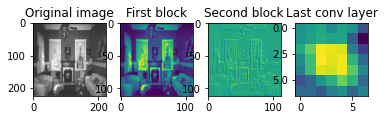

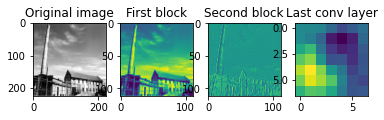

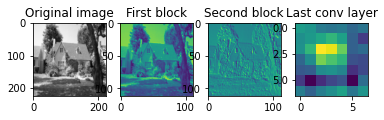

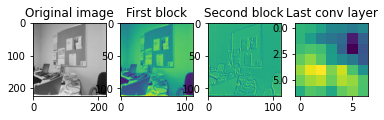

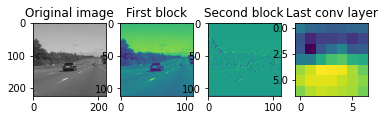

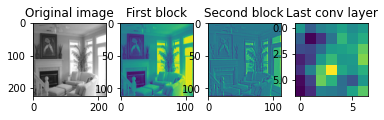

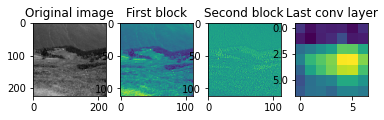

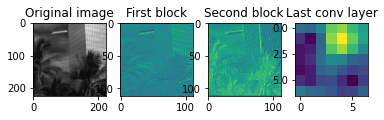

In [102]:
from torchvision.io.image import read_image
from torchvision.transforms.functional import normalize, resize, to_pil_image
from torchvision.models import resnet18
from torchcam.methods import SmoothGradCAMpp

model_str = "supervised"

model = load_model(MODEL_SAVES[model_str])

tmp = get_correctly_predicted_images(model, val_loader, num_images=8)
# img, label = tmp[0][0], tmp[1][0]

for img, labl in zip(tmp[0], tmp[1]):
    # Get your input

    # get the last convolutional layer in the EfficientNet-B0
    last_conv_layer = model.features[-1]

    # get the last convolutional layer in the first and second block of the EfficientNet-B0 architecture
    block0 = model.features[0]
    block1 = model.features[1]
    first_block = block0[0]
    second_block = block1[0].block[2]

    layers = {
        "last_conv_layer": last_conv_layer,
        "first_block": first_block,
        "second_block": second_block
    }

    activation_maps = []
    for layer_id, layer in layers.items():
        # Preprocess it for your chosen model
        # input_tensor = normalize(resize(img, (224, 224)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        input_tensor = img

        cam_extractor = ScoreCAM(model, target_layer=layer)
        # Preprocess your data and feed it to the model
        out = model(input_tensor)
        # Retrieve the CAM by passing the class index and the model output
        label_idx = out.squeeze(0).argmax().item()
        activation_map = cam_extractor(label_idx, out)

        activation_maps.append(activation_map)

        # break

    # plot the image and the activation maps
    fig, ax = plt.subplots(1, 4)
    ax[0].imshow(to_pil_image(img.squeeze(0)))
    ax[0].set_title("Original image")
    ax[1].imshow(to_pil_image(activation_maps[1][0]))
    ax[1].set_title("First block")
    ax[2].imshow(to_pil_image(activation_maps[2][0]))
    ax[2].set_title("Second block")
    ax[3].imshow(to_pil_image(activation_maps[0][0]))
    ax[3].set_title("Last conv layer")

    rand = np.random.randint(0, 1000)
    filename = f"explanations_{model_str}_{labl}_{rand}.png"
    plt.savefig(filename)

    plt.show()


    # plt.imshow(activation_map[0].squeeze(0).numpy()); plt.axis('off'); plt.tight_layout(); plt.show()

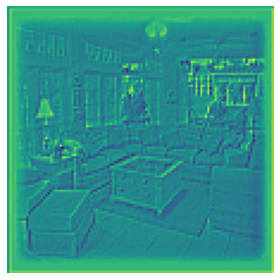

In [93]:
import matplotlib.pyplot as plt
# Visualize the raw CAM
plt.imshow(activation_map[0].squeeze(0).numpy()); plt.axis('off'); plt.tight_layout(); plt.show()

In [78]:
model = load_model(MODEL_SAVES["supervised"])
images_to_explain = get_correctly_predicted_images(model, val_loader, num_images=1)
explain_predictions(model, images_to_explain)

[{'img': tensor([[[[0.0902, 0.0902, 0.0902,  ..., 0.0431, 0.0431, 0.0431],
            [0.0902, 0.0902, 0.0902,  ..., 0.0471, 0.0431, 0.0431],
            [0.0902, 0.0902, 0.0902,  ..., 0.0471, 0.0471, 0.0431],
            ...,
            [0.0471, 0.0510, 0.0510,  ..., 0.0784, 0.0863, 0.0784],
            [0.0471, 0.0510, 0.0510,  ..., 0.0902, 0.1020, 0.1255],
            [0.0471, 0.0510, 0.0510,  ..., 0.0863, 0.0902, 0.1490]],
  
           [[0.0902, 0.0902, 0.0902,  ..., 0.0431, 0.0431, 0.0431],
            [0.0902, 0.0902, 0.0902,  ..., 0.0471, 0.0431, 0.0431],
            [0.0902, 0.0902, 0.0902,  ..., 0.0471, 0.0471, 0.0431],
            ...,
            [0.0471, 0.0510, 0.0510,  ..., 0.0784, 0.0863, 0.0784],
            [0.0471, 0.0510, 0.0510,  ..., 0.0902, 0.1020, 0.1255],
            [0.0471, 0.0510, 0.0510,  ..., 0.0863, 0.0902, 0.1490]],
  
           [[0.0902, 0.0902, 0.0902,  ..., 0.0431, 0.0431, 0.0431],
            [0.0902, 0.0902, 0.0902,  ..., 0.0471, 0.0431, 0.0431],

In [ ]:
def plot_explanations(explanations):
    for expl_dict in explanations:
        img = expl_dict["img"]
        label = expl_dict["label"]
        convb1 = expl_dict["convb1"]
        convb2 = expl_dict["convb2"]
        lastconv = expl_dict["lastconv"]

        # plot the image
        plt.imshow(img.squeeze(0).permute(1, 2, 0).numpy())
        plt.title(f"Label: {label}")

        # plot the explanations
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        axs[0].imshow(convb1[0].squeeze(0).numpy())
        axs[0].set_title("Conv b1")
        axs[1].imshow(convb2[0].squeeze(0).numpy())
        axs[1].set_title("Conv b2")
        axs[2].imshow(lastconv[0].squeeze(0).numpy())
        axs[2].set_title("Last conv")
        plt.show()

        plt.clf()

In [ ]:
model = load_model(MODEL_SAVES["pretext_rotation"])
images_to_explain = get_correctly_predicted_images(model, val_loader)
explain_predictions(model, images_to_explain)

In [ ]:
model = load_model(MODEL_SAVES["pretext_perturbation"])
images_to_explain = get_correctly_predicted_images(model, val_loader)
explain_predictions(model, images_to_explain)

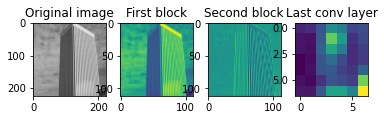

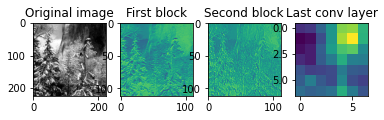

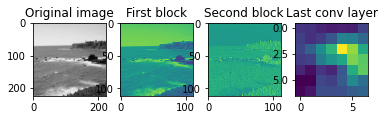

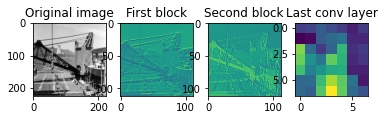

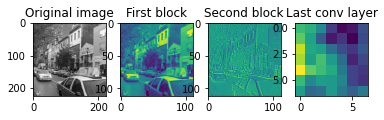

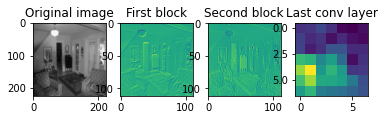

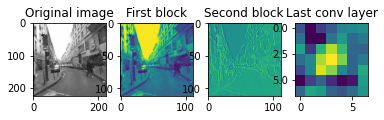

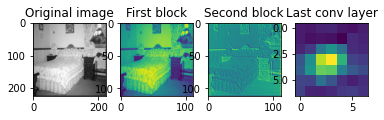

In [103]:
from torchvision.io.image import read_image
from torchvision.transforms.functional import normalize, resize, to_pil_image
from torchvision.models import resnet18
from torchcam.methods import SmoothGradCAMpp

model_str = "pretext_rotation"

model = load_model(MODEL_SAVES[model_str])

tmp = get_correctly_predicted_images(model, val_loader, num_images=8)
# img, label = tmp[0][0], tmp[1][0]

for img, labl in zip(tmp[0], tmp[1]):
    # Get your input

    # get the last convolutional layer in the EfficientNet-B0
    last_conv_layer = model.features[-1]

    # get the last convolutional layer in the first and second block of the EfficientNet-B0 architecture
    block0 = model.features[0]
    block1 = model.features[1]
    first_block = block0[0]
    second_block = block1[0].block[2]

    layers = {
        "last_conv_layer": last_conv_layer,
        "first_block": first_block,
        "second_block": second_block
    }

    activation_maps = []
    for layer_id, layer in layers.items():
        # Preprocess it for your chosen model
        # input_tensor = normalize(resize(img, (224, 224)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        input_tensor = img

        cam_extractor = ScoreCAM(model, target_layer=layer)
        # Preprocess your data and feed it to the model
        out = model(input_tensor)
        # Retrieve the CAM by passing the class index and the model output
        label_idx = out.squeeze(0).argmax().item()
        activation_map = cam_extractor(label_idx, out)

        activation_maps.append(activation_map)

        # break

    # plot the image and the activation maps
    fig, ax = plt.subplots(1, 4)
    ax[0].imshow(to_pil_image(img.squeeze(0)))
    ax[0].set_title("Original image")
    ax[1].imshow(to_pil_image(activation_maps[1][0]))
    ax[1].set_title("First block")
    ax[2].imshow(to_pil_image(activation_maps[2][0]))
    ax[2].set_title("Second block")
    ax[3].imshow(to_pil_image(activation_maps[0][0]))
    ax[3].set_title("Last conv layer")

    rand = np.random.randint(0, 1000)
    filename = f"explanations_{model_str}_{labl}_{rand}.png"
    plt.savefig(filename)

    plt.show()


    # plt.imshow(activation_map[0].squeeze(0).numpy()); plt.axis('off'); plt.tight_layout(); plt.show()

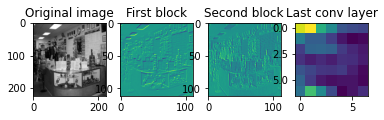

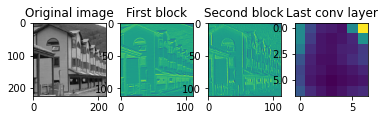

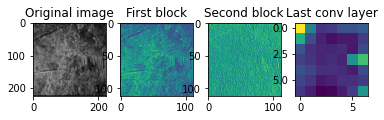

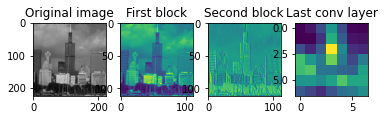

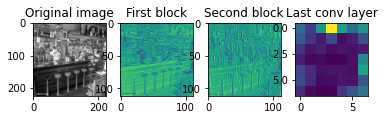

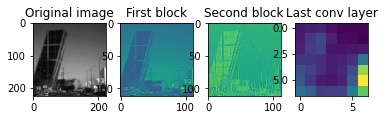

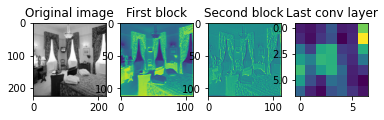

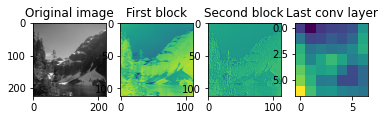

In [104]:
from torchvision.io.image import read_image
from torchvision.transforms.functional import normalize, resize, to_pil_image
from torchvision.models import resnet18
from torchcam.methods import SmoothGradCAMpp

model_str = "pretext_perturbation"

model = load_model(MODEL_SAVES[model_str])

tmp = get_correctly_predicted_images(model, val_loader, num_images=8)
# img, label = tmp[0][0], tmp[1][0]

for img, labl in zip(tmp[0], tmp[1]):
    # Get your input

    # get the last convolutional layer in the EfficientNet-B0
    last_conv_layer = model.features[-1]

    # get the last convolutional layer in the first and second block of the EfficientNet-B0 architecture
    block0 = model.features[0]
    block1 = model.features[1]
    first_block = block0[0]
    second_block = block1[0].block[2]

    layers = {
        "last_conv_layer": last_conv_layer,
        "first_block": first_block,
        "second_block": second_block
    }

    activation_maps = []
    for layer_id, layer in layers.items():
        # Preprocess it for your chosen model
        # input_tensor = normalize(resize(img, (224, 224)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        input_tensor = img

        cam_extractor = ScoreCAM(model, target_layer=layer)
        # Preprocess your data and feed it to the model
        out = model(input_tensor)
        # Retrieve the CAM by passing the class index and the model output
        label_idx = out.squeeze(0).argmax().item()
        activation_map = cam_extractor(label_idx, out)

        activation_maps.append(activation_map)

        # break

    # plot the image and the activation maps
    fig, ax = plt.subplots(1, 4)
    ax[0].imshow(to_pil_image(img.squeeze(0)))
    ax[0].set_title("Original image")
    ax[1].imshow(to_pil_image(activation_maps[1][0]))
    ax[1].set_title("First block")
    ax[2].imshow(to_pil_image(activation_maps[2][0]))
    ax[2].set_title("Second block")
    ax[3].imshow(to_pil_image(activation_maps[0][0]))
    ax[3].set_title("Last conv layer")

    rand = np.random.randint(0, 1000)
    filename = f"explanations_{model_str}_{labl}_{rand}.png"
    plt.savefig(filename)

    plt.show()


    # plt.imshow(activation_map[0].squeeze(0).numpy()); plt.axis('off'); plt.tight_layout(); plt.show()

In [30]:
model = models.efficientnet_b0(weights="IMAGENET1K_V1")
batch = next(iter(val_loader))
explain_predictions(model, batch)

ValueError: Input and output must have the same number of spatial dimensions, but got input with spatial dimensions of [] and output size of torch.Size([224, 224]). Please provide input tensor in (N, C, d1, d2, ...,dK) format and output size in (o1, o2, ...,oK) format.


## Interpretation
For the interpretation part, you should utilize the model inversion method proposed
in [3]. This model inversion technique is part of the last exercise session.

In [113]:
from RegularizedUnitSpecificImageGeneration import RegularizedClassSpecificImageGeneration

# select 5 classes randomly
target_classes = np.random.choice(LABELS, 5, replace=False)
target_classes = ["street", "forest", "opencountry", "mountain", "tallbuilding"]

def get_interpretation(model, output_dir):
    for target_class in target_classes:
        print(f"Generating interpretation for class {target_class}")
        target_class_idx = LABELS.index(target_class)

        csig = RegularizedClassSpecificImageGeneration(model, target_class_idx, output_dir=output_dir, grayscale=False)

        # model.train(True)

        with torch.enable_grad(): # it's not calculating the grads for all models except for efficientnet, no idea whats the difference, since only the image has grads and the model is frozen. Probably pytorch version issues.
            csig.generate(iterations=1000)

In [114]:
model = load_model(MODEL_SAVES["supervised"])
get_interpretation(model, output_dir="outputs/interpretations/supervised")

Generating interpretation for class street


C:\Users\arnod\PycharmProjects\ANN-Self-Supervised-Scene-Classification\RegularizedUnitSpecificImageGeneration.py:95: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(


Iteration: 111 Loss -0.05
Iteration: 222 Loss -0.28
Iteration: 333 Loss 0.28
Iteration: 444 Loss -0.26
Iteration: 555 Loss -0.41
Iteration: 666 Loss -0.14
Iteration: 777 Loss -0.06
Iteration: 888 Loss -0.39


FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'outputs/interpretations/supervised/class_12' -> 'outputs/interpretations/supervised/class_12_blurfreq_4_blurrad_1_wd0.0001'

In [25]:
model = load_model(MODEL_SAVES["pretext_rotation"])
get_interpretation(model, output_dir="outputs/interpretations/pretext_rotation")

Generating interpretation for class street


C:\Users\arnod\PycharmProjects\ANN-Self-Supervised-Scene-Classification\RegularizedUnitSpecificImageGeneration.py:94: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(


Iteration: 111 Loss 0.75
Iteration: 222 Loss 0.44
Iteration: 333 Loss 0.77
Iteration: 444 Loss 0.48
Iteration: 555 Loss 0.47
Iteration: 666 Loss 0.70
Iteration: 777 Loss 0.44
Iteration: 888 Loss 0.22
Generating interpretation for class forest
Iteration: 111 Loss 0.97
Iteration: 222 Loss 0.75
Iteration: 333 Loss 1.10
Iteration: 444 Loss 0.45
Iteration: 555 Loss 0.46
Iteration: 666 Loss 1.21


KeyboardInterrupt: 

In [ ]:
model = load_model(MODEL_SAVES["pretext_perturbation"])
get_interpretation(model, output_dir="outputs/interpretations/pretext_perturbation")

In [36]:
model_efficient_b0 = models.efficientnet_b0(weights='IMAGENET1K_V1')
get_interpretation(model_efficient_b0, output_dir="outputs/interpretations/efficient_b0")

Generating interpretation for class street
Iteration: 111 Loss 0.26
Iteration: 222 Loss -0.18
Iteration: 333 Loss 0.24
Iteration: 444 Loss -0.66
Iteration: 555 Loss -0.68
Iteration: 666 Loss -0.27
Iteration: 777 Loss -0.20
Iteration: 888 Loss -0.78
Generating interpretation for class forest
Iteration: 111 Loss -0.13
Iteration: 222 Loss -0.42
Iteration: 333 Loss 0.01
Iteration: 444 Loss -0.88
Iteration: 555 Loss -0.61
Iteration: 666 Loss -0.97
Iteration: 777 Loss -0.63
Iteration: 888 Loss -0.79
Generating interpretation for class opencountry
Iteration: 111 Loss -0.30


KeyboardInterrupt: 

# Evaluation

In [17]:
def evaluation_report(model, loader):
    """
    :param model: the model to be evaluated
    :param loader: the loader to be used for evaluation
    :return: the classification report and the confusion matrix
    """
    y_true = []
    y_pred = []

    for images, labels in loader:
        y_true.extend(labels.numpy())
        predictions = model(images)
        predictions = torch.argmax(predictions, dim=1)
        y_pred.extend(predictions.numpy())


    return classification_report(y_true, y_pred, target_names=LABELS), confusion_matrix(y_true, y_pred)

In [ ]:



def explain_predictions(model, val_batch):
    """
    Takesimages from the validation set and generates a Score-CAM explanation for each of them.
    :param model: the model to be explained
    :param val_batch: the validation set images and labels to explain
    """

    explanations = []

    images = val_batch[0]
    labels = val_batch[1]

    for image, label in zip(images, labels):
        # get the explanation for the final layr
        target_layer = model._modules.get('classifier')  # tODO: dit of model.classifier[-1]
        cam_extractor = ScoreCAM(model=model, target_layer=target_layer)

        # get the explanation for the image
        explanation = cam_extractor(image, target_category=label)
        explanations.append(explanation)

        # create plots, where each row contais the original image, the heatmap and the heatmap overlayed on the original image
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        ax[0].imshow(image.permute(1, 2, 0))
        ax[0].set_title("Original image")

        ax[1].imshow(explanation.squeeze().permute(1, 2, 0))
        ax[1].set_title("Heatmap")

        ax[2].imshow(image.permute(1, 2, 0))
        ax[2].imshow(explanation.squeeze().permute(1, 2, 0), alpha=0.5)
        ax[2].set_title("Heatmap overlayed on the original image")


images_to_explain = next(iter(val_loader))[0][:3]

In [18]:
for model_name in MODEL_SAVES:
    model = load_model(MODEL_SAVES[model_name])
    report, confusion = evaluation_report(model, val_loader)
    print(f"Model: {model_name}")
    print(report)
    print(confusion)

    # print latex table of the confusion matrix
    table = pd.DataFrame(confusion, index=LABELS, columns=LABELS)
    print(table.to_latex())

    print("\n\n")



Model: supervised
              precision    recall  f1-score   support

     bedroom       0.86      0.88      0.87       116
       coast       0.90      0.97      0.93       260
      forest       0.94      0.96      0.95       228
     highway       0.93      0.96      0.95       160
  industrial       0.93      0.90      0.91       211
  insidecity       0.91      0.93      0.92       208
     kitchen       0.93      0.95      0.94       110
  livingroom       0.91      0.90      0.91       189
    mountain       0.96      0.95      0.95       274
      office       0.96      0.97      0.97       115
 opencountry       0.93      0.87      0.90       310
       store       0.98      0.96      0.97       215
      street       0.95      0.93      0.94       192
      suburb       0.98      1.00      0.99       141
tallbuilding       0.97      0.95      0.96       256

    accuracy                           0.94      2985
   macro avg       0.94      0.94      0.94      2985
weighted

C:\Users\arnod\AppData\Local\Temp/ipykernel_18036/2072257027.py:10: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(table.to_latex())


Model: pretext_rotation
              precision    recall  f1-score   support

     bedroom       0.64      0.75      0.69       116
       coast       0.76      0.74      0.75       260
      forest       0.80      0.74      0.77       228
     highway       0.70      0.80      0.75       160
  industrial       0.83      0.40      0.54       211
  insidecity       0.78      0.63      0.70       208
     kitchen       0.43      0.65      0.52       110
  livingroom       0.69      0.50      0.58       189
    mountain       0.77      0.74      0.76       274
      office       0.62      0.73      0.67       115
 opencountry       0.62      0.71      0.66       310
       store       0.71      0.74      0.73       215
      street       0.73      0.85      0.78       192
      suburb       0.77      0.96      0.85       141
tallbuilding       0.82      0.82      0.82       256

    accuracy                           0.71      2985
   macro avg       0.71      0.72      0.70      2985
we

C:\Users\arnod\AppData\Local\Temp/ipykernel_18036/2072257027.py:10: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(table.to_latex())


Model: pretext_perturbation
              precision    recall  f1-score   support

     bedroom       0.59      0.79      0.68       116
       coast       0.67      0.58      0.62       260
      forest       0.73      0.70      0.71       228
     highway       0.66      0.79      0.72       160
  industrial       0.77      0.55      0.64       211
  insidecity       0.71      0.62      0.66       208
     kitchen       0.62      0.72      0.67       110
  livingroom       0.78      0.56      0.65       189
    mountain       0.68      0.74      0.71       274
      office       0.70      0.90      0.79       115
 opencountry       0.56      0.55      0.56       310
       store       0.85      0.80      0.82       215
      street       0.69      0.76      0.72       192
      suburb       0.77      0.92      0.84       141
tallbuilding       0.76      0.79      0.78       256

    accuracy                           0.70      2985
   macro avg       0.70      0.72      0.70      298

C:\Users\arnod\AppData\Local\Temp/ipykernel_18036/2072257027.py:10: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(table.to_latex())
